Nome: João Gabriel Andrade de Araujo Josephik NUSP: 12542265

Link do colab:https://colab.research.google.com/drive/1HF8JkqIa-DZR4dF3HQZysYw4q4e5piep?usp=sharing

Resultados do treinamento: https://drive.google.com/drive/folders/1xtccTdVPHG-2WlsBl12y3Zu84XjZPcoV?usp=drive_link

O notebook abaixo contém o desenvolvimento de um autoencoder para o dataset do MNIST. Foram utilizados bloco convolucionais com batch normalization para feature extraction e uma camada linear para projetá-las no espaço latente. Para os dois primeiros modelos, foi escolhido um espaço latente de dimensão 5. Para o último, foi escolhido um espaço de dimensão 2.

Várias fontes foram consultadas. Entre elas:
- https://avandekleut.github.io/vae/
- https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
- https://github.com/Jackson-Kang/Pytorch-VAE-tutorial

Obesrvação interessante:
A curva de treinamento do VAE têm um comportamento oscilatório intrigante. Não tive tempo, infelizmente, de investigar o que está causando isso a tempo para a entrega da Task.

In [1]:
import os
import gc
import torch
from torch import nn, optim
import pandas as pd
from skimage import io, transform, morphology
from skimage.morphology import binary_dilation, star
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets import MNIST
import torch

from torch.optim import lr_scheduler as schd
from tqdm import tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploração dos dados

In [3]:
class AutoEncoderDataset(Dataset):

  def __init__(self, data, size=-1, input_transform=None):
    self.data = data
    self.size=size
    self.input_transform = input_transform
  def __len__(self):
    if self.size > 0:
      return self.size
    return len(self.data)

  def __getitem__(self, idx):
    input=self.data[idx][0]
    target=self.data[idx][0]
    if self.input_transform:
      input=self.input_transform(input)
    return (input, target)

In [4]:
# source: https://github.com/pytorch/vision/issues/6192
def gauss_noise_tensor(img):

    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)

    sigma = 0.3

    out = torch.clamp(img + sigma * torch.randn_like(img), 0, 1)

    if out.dtype != dtype:
        out = out.to(dtype)

    return out

In [5]:

train_data=AutoEncoderDataset(MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor()))
test_data=AutoEncoderDataset(MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), size=4096)


train_data_noise=AutoEncoderDataset(MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor()), input_transform=gauss_noise_tensor)
test_data_noise=AutoEncoderDataset(MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), size=4096, input_transform=gauss_noise_tensor)

100%|██████████| 9912422/9912422 [00:00<00:00, 118194410.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24412675.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29000001.66it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3968033.49it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([9, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])


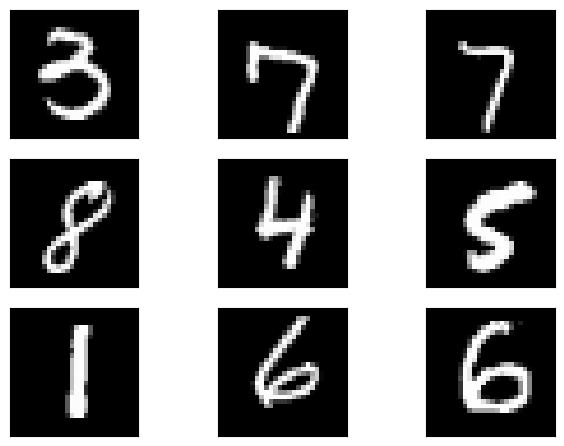

In [ ]:
import matplotlib.pyplot as plt
length=9
begin=3
visualization_range = np.random.choice(len(train_data), length)
example_data = torch.stack([train_data[i][0] for i in visualization_range])


fig = plt.figure()
print(example_data.shape)
for i in range(length):
  print(example_data[i].shape)

  data = example_data[i].movedim(0, 2)

  print(data.shape)
  plt.subplot(3,3, i + 1)
  plt.tight_layout()
  plt.imshow(data, cmap='gray', vmin=0, vmax=1)
  plt.xticks([])
  plt.yticks([])





torch.Size([9, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])


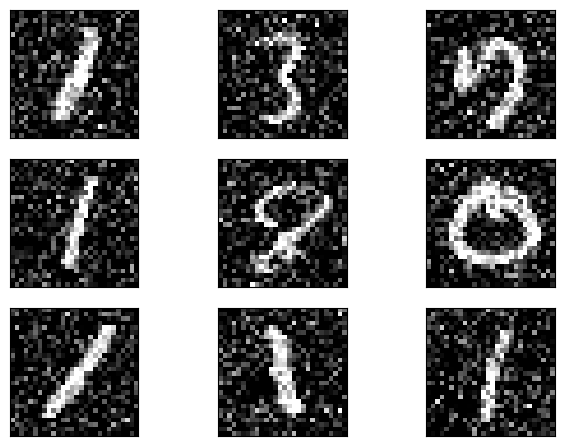

In [ ]:
import matplotlib.pyplot as plt
length=9
begin=3
visualization_range = np.random.choice(len(train_data_noise), length)
example_data = torch.stack([train_data_noise[i][0] for i in visualization_range])


fig = plt.figure()
print(example_data.shape)
for i in range(length):
  print(example_data[i].shape)

  data = example_data[i].movedim(0, 2)

  print(data.shape)
  plt.subplot(3,3, i + 1)
  plt.tight_layout()
  plt.imshow(data, cmap='gray', vmin=0, vmax=1)
  plt.xticks([])
  plt.yticks([])


In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
def train(network, train_loader, epoch, optimizer, loss_fn, log_interval, batch_size_train, train_losses, train_counter):
  network.train()
  for batch_idx, (data, target ),  in enumerate(train_loader):
    gc.collect()
    torch.cuda.empty_cache()
    data = data.to(device)
    target = target.to(device)


    optimizer.zero_grad()
    output = network(data)

    loss = loss_fn(output, target)

    loss = loss.mean()

    loss.backward()

    optimizer.step()

    data = None
    target = None
    weight = None
    gc.collect()
    torch.cuda.empty_cache()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * batch_size_train, len(train_loader.dataset),
        100 * batch_idx / len(train_loader), loss))

    train_losses.append(loss.item())
    train_counter.append((batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))


In [ ]:
def test(network, test_loader, loss_fn, batch_size_test, test_losses, test_counter):

  network.eval()
  test_loss=0
  correct=0
  batches=0
  total=0
  with torch.no_grad():
    for data, target in test_loader:
      gc.collect()
      torch.cuda.empty_cache()
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      loss = loss_fn(output, target )
      test_loss += loss.mean()*data.shape[0]
      total += data.shape[0]
  test_loss /= total
  test_losses.append(test_loss)
  test_counter.append((test_counter[-1] + len(test_loader.dataset))if len(test_counter) > 0 else 0)
  print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))

  with torch.no_grad():
    fig = plt.figure()
    ind = np.random.randint(0, len(test_loader.dataset))
    input=test_loader.dataset[ind][0]
    target=test_loader.dataset[ind][1]
    plt.subplot(1,3,1)
    plt.imshow(input.movedim(0, 2), cmap='gray', vmin=0, vmax=1)
    plt.subplot(1,3,2)
    plt.imshow(target.movedim(0, 2), cmap='gray', vmin=0, vmax=1)
    plt.subplot(1,3,3)
    output=network(input.unsqueeze(0).to(device)).cpu().squeeze(0).movedim(0, 2)
    plt.imshow(output, cmap='gray', vmin=0, vmax=1)
    plt.show()

In [ ]:
def get_stats_latent(test_loader, encoder):
  network.eval()
  total=0
  mean=0
  mean_sqr=0
  max_val=0
  min_val=0

  with torch.no_grad():
    for data, target in test_loader:
      gc.collect()
      torch.cuda.empty_cache()
      data = data.to(device)
      output = encoder(data)
      total += data.shape[0]
      mean += data.shape[0]*torch.mean(output)
      mean_sqr +=data.shape[0]*torch.mean(output*output)
      max_val = max(max_val, torch.max(output))
      min_val = min(min_val, torch.min(output))

  mean /= total
  mean_sqr /= total
  return mean, (mean_sqr - mean*mean), max_val, min_val


## Autoencoder


In [ ]:
#Based on RESNET block
class AEBlock(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()
    # self.conv1 = nn.Conv2d(in_channels, out_channels, 1, padding='same')
    self.seq=nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, padding='same'),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, 3, padding='same'),
      nn.BatchNorm2d(out_channels))



  def forward(self, x):
    # return self.final_activation(self.conv1(x) + self.seq(x))
    return self.seq(x)

class UpConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.ct= nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
      nn.ReLU())


  def forward(self, x):
    o = self.ct(x)
    return o

class Encoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()

    self.e1=AEBlock(1, 8)
    self.me1=nn.MaxPool2d(2)
    self.e2=AEBlock(8, 16)
    self.me2=nn.MaxPool2d(2)

    self.bt=nn.Linear(784, latent_size)

    self.norm=nn.BatchNorm1d(latent_size)

  def forward(self, x):
    i1 = self.e1(x)
    i2 = self.e2(self.me1(i1))

    pb = self.me2(i2)

    b=self.bt(pb.view(pb.shape[0], -1))

    return self.norm(b)

class Decoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()

    self.bt=nn.Linear(latent_size, 784)


    self.ct1=UpConvBlock(16, 16)
    self.d1=AEBlock(16, 8)

    self.ct2=UpConvBlock(8, 8)
    self.d2=AEBlock(8, 1)


  def forward(self, x):
    b = self.bt(x).view((x.shape[0], 16, 7, 7))


    o1 = self.d1( self.ct1(b) )
    o2 = self.d2( self.ct2(o1) )

    return o2


class AutoEncoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()


        self.Encoder = Encoder(latent_size)
        self.Decoder = Decoder(latent_size)





    def forward(self, x):

        return self.Decoder(self.Encoder(x))





In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
parameters_file='/content/drive/MyDrive/modelos/AE_MNIST/parameters.pth'
saved_parameters_file='/content/drive/MyDrive/modelos/AE_MNIST/best_parameters.pth'
training_data_file='/content/drive/MyDrive/modelos/AE_MNIST/treinamento.pickle'
batch_size_train = 2048
batch_size_test = 2048
train_loader = torch.utils.data.DataLoader(
  train_data,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_data,
  batch_size=batch_size_test, shuffle=True)
device

'cpu'

In [ ]:
gc.collect()
torch.cuda.empty_cache()
n_epochs = 50

learning_rate = 1e-3

log_interval=1

network = AutoEncoder(5).to(device)

optimizer = optim.Adam(network.parameters(), lr=learning_rate)
loss_fn=nn.MSELoss(reduction='mean', )
scheduler = schd.StepLR(optimizer, 15, 0.5)

train_losses = []
train_counter = []
test_losses = []
test_counter=[]


In [ ]:
count_parameters(network)

16054


Test set: Avg. loss: 0.1217


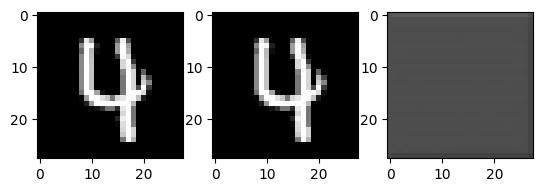

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.105035
Train Epoch: 1 [2048/60000 (3%)]	Loss: 1.087345
Train Epoch: 1 [4096/60000 (7%)]	Loss: 1.069508
Train Epoch: 1 [6144/60000 (10%)]	Loss: 1.051443
Train Epoch: 1 [8192/60000 (13%)]	Loss: 1.031421
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.013148
Train Epoch: 1 [12288/60000 (20%)]	Loss: 0.994648
Train Epoch: 1 [14336/60000 (23%)]	Loss: 0.978911
Train Epoch: 1 [16384/60000 (27%)]	Loss: 0.961224
Train Epoch: 1 [18432/60000 (30%)]	Loss: 0.945310
Train Epoch: 1 [20480/60000 (33%)]	Loss: 0.925904
Train Epoch: 1 [22528/60000 (37%)]	Loss: 0.912113
Train Epoch: 1 [24576/60000 (40%)]	Loss: 0.895035
Train Epoch: 1 [26624/60000 (43%)]	Loss: 0.880270
Train Epoch: 1 [28672/60000 (47%)]	Loss: 0.866532
Train Epoch: 1 [30720/60000 (50%)]	Loss: 0.853737
Train Epoch: 1 [32768/60000 (53%)]	Loss: 0.840984
Train Epoch: 1 [34816/60000 (57%)]	Loss: 0.829548
Train Epoch: 1 [36864/60000 (60%)]	Loss: 0.815063
Train Epoch: 1 [38912/60000 (63%)]	Loss: 0.802554
Train Epoch

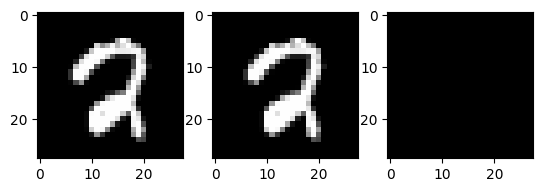

New best! Saving...
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.708728
Train Epoch: 2 [2048/60000 (3%)]	Loss: 0.698193
Train Epoch: 2 [4096/60000 (7%)]	Loss: 0.693218
Train Epoch: 2 [6144/60000 (10%)]	Loss: 0.689136
Train Epoch: 2 [8192/60000 (13%)]	Loss: 0.677325
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.672778
Train Epoch: 2 [12288/60000 (20%)]	Loss: 0.668200
Train Epoch: 2 [14336/60000 (23%)]	Loss: 0.662068
Train Epoch: 2 [16384/60000 (27%)]	Loss: 0.660331
Train Epoch: 2 [18432/60000 (30%)]	Loss: 0.652536
Train Epoch: 2 [20480/60000 (33%)]	Loss: 0.648116
Train Epoch: 2 [22528/60000 (37%)]	Loss: 0.640848
Train Epoch: 2 [24576/60000 (40%)]	Loss: 0.633424
Train Epoch: 2 [26624/60000 (43%)]	Loss: 0.633272
Train Epoch: 2 [28672/60000 (47%)]	Loss: 0.627294
Train Epoch: 2 [30720/60000 (50%)]	Loss: 0.626300
Train Epoch: 2 [32768/60000 (53%)]	Loss: 0.620320
Train Epoch: 2 [34816/60000 (57%)]	Loss: 0.617611
Train Epoch: 2 [36864/60000 (60%)]	Loss: 0.616731
Train Epoch: 2 [38912/60000 (63%)]	Loss: 

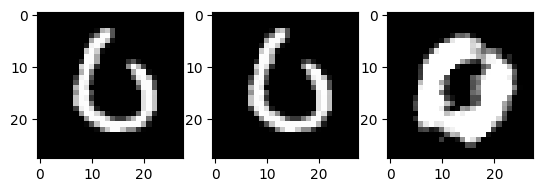

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.582081
Train Epoch: 3 [2048/60000 (3%)]	Loss: 0.577976
Train Epoch: 3 [4096/60000 (7%)]	Loss: 0.575403
Train Epoch: 3 [6144/60000 (10%)]	Loss: 0.572595
Train Epoch: 3 [8192/60000 (13%)]	Loss: 0.569370
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.565476
Train Epoch: 3 [12288/60000 (20%)]	Loss: 0.566735
Train Epoch: 3 [14336/60000 (23%)]	Loss: 0.563426
Train Epoch: 3 [16384/60000 (27%)]	Loss: 0.560536
Train Epoch: 3 [18432/60000 (30%)]	Loss: 0.561891
Train Epoch: 3 [20480/60000 (33%)]	Loss: 0.553761
Train Epoch: 3 [22528/60000 (37%)]	Loss: 0.556138
Train Epoch: 3 [24576/60000 (40%)]	Loss: 0.558597
Train Epoch: 3 [26624/60000 (43%)]	Loss: 0.551851
Train Epoch: 3 [28672/60000 (47%)]	Loss: 0.548342
Train Epoch: 3 [30720/60000 (50%)]	Loss: 0.548375
Train Epoch: 3 [32768/60000 (53%)]	Loss: 0.546050
Train Epoch: 3 [34816/60000 (57%)]	Loss: 0.542763
Train Epoch: 3 [36864/60000 (60%)]	Loss: 0.541004
Train Epoch: 3 [38912/60000 (63%)]	Loss: 0.538773
Train Epoch

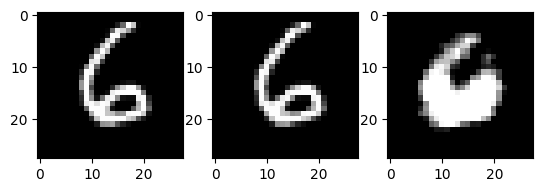

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.518196
Train Epoch: 4 [2048/60000 (3%)]	Loss: 0.518872
Train Epoch: 4 [4096/60000 (7%)]	Loss: 0.515865
Train Epoch: 4 [6144/60000 (10%)]	Loss: 0.515983
Train Epoch: 4 [8192/60000 (13%)]	Loss: 0.511504
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.506576
Train Epoch: 4 [12288/60000 (20%)]	Loss: 0.509566
Train Epoch: 4 [14336/60000 (23%)]	Loss: 0.507467
Train Epoch: 4 [16384/60000 (27%)]	Loss: 0.505038
Train Epoch: 4 [18432/60000 (30%)]	Loss: 0.506109
Train Epoch: 4 [20480/60000 (33%)]	Loss: 0.502030
Train Epoch: 4 [22528/60000 (37%)]	Loss: 0.500526
Train Epoch: 4 [24576/60000 (40%)]	Loss: 0.499609
Train Epoch: 4 [26624/60000 (43%)]	Loss: 0.500100
Train Epoch: 4 [28672/60000 (47%)]	Loss: 0.498401
Train Epoch: 4 [30720/60000 (50%)]	Loss: 0.493710
Train Epoch: 4 [32768/60000 (53%)]	Loss: 0.494368
Train Epoch: 4 [34816/60000 (57%)]	Loss: 0.493899
Train Epoch: 4 [36864/60000 (60%)]	Loss: 0.488858
Train Epoch: 4 [38912/60000 (63%)]	Loss: 0.488879
Train Epoch

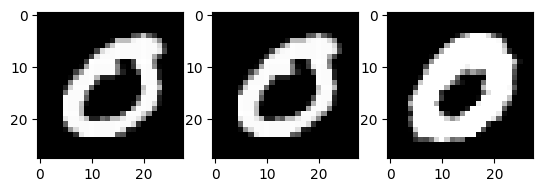

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.471920
Train Epoch: 5 [2048/60000 (3%)]	Loss: 0.466432
Train Epoch: 5 [4096/60000 (7%)]	Loss: 0.466221
Train Epoch: 5 [6144/60000 (10%)]	Loss: 0.466153
Train Epoch: 5 [8192/60000 (13%)]	Loss: 0.468351
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.466882
Train Epoch: 5 [12288/60000 (20%)]	Loss: 0.462025
Train Epoch: 5 [14336/60000 (23%)]	Loss: 0.462238
Train Epoch: 5 [16384/60000 (27%)]	Loss: 0.459465
Train Epoch: 5 [18432/60000 (30%)]	Loss: 0.457126
Train Epoch: 5 [20480/60000 (33%)]	Loss: 0.460998
Train Epoch: 5 [22528/60000 (37%)]	Loss: 0.455295
Train Epoch: 5 [24576/60000 (40%)]	Loss: 0.452060
Train Epoch: 5 [26624/60000 (43%)]	Loss: 0.455210
Train Epoch: 5 [28672/60000 (47%)]	Loss: 0.450051
Train Epoch: 5 [30720/60000 (50%)]	Loss: 0.452144
Train Epoch: 5 [32768/60000 (53%)]	Loss: 0.446825
Train Epoch: 5 [34816/60000 (57%)]	Loss: 0.448059
Train Epoch: 5 [36864/60000 (60%)]	Loss: 0.447581
Train Epoch: 5 [38912/60000 (63%)]	Loss: 0.445682
Train Epoch

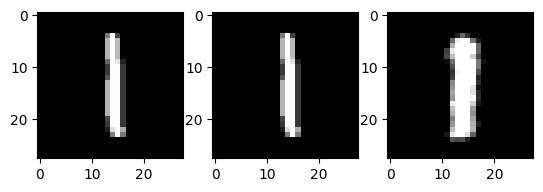

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.429783
Train Epoch: 6 [2048/60000 (3%)]	Loss: 0.427492
Train Epoch: 6 [4096/60000 (7%)]	Loss: 0.425655
Train Epoch: 6 [6144/60000 (10%)]	Loss: 0.425712
Train Epoch: 6 [8192/60000 (13%)]	Loss: 0.425892
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.423943
Train Epoch: 6 [12288/60000 (20%)]	Loss: 0.424981
Train Epoch: 6 [14336/60000 (23%)]	Loss: 0.421075
Train Epoch: 6 [16384/60000 (27%)]	Loss: 0.418654
Train Epoch: 6 [18432/60000 (30%)]	Loss: 0.419862
Train Epoch: 6 [20480/60000 (33%)]	Loss: 0.419262
Train Epoch: 6 [22528/60000 (37%)]	Loss: 0.416134
Train Epoch: 6 [24576/60000 (40%)]	Loss: 0.412625
Train Epoch: 6 [26624/60000 (43%)]	Loss: 0.415345
Train Epoch: 6 [28672/60000 (47%)]	Loss: 0.413196
Train Epoch: 6 [30720/60000 (50%)]	Loss: 0.411779
Train Epoch: 6 [32768/60000 (53%)]	Loss: 0.408915
Train Epoch: 6 [34816/60000 (57%)]	Loss: 0.410172
Train Epoch: 6 [36864/60000 (60%)]	Loss: 0.407242
Train Epoch: 6 [38912/60000 (63%)]	Loss: 0.405244
Train Epoch

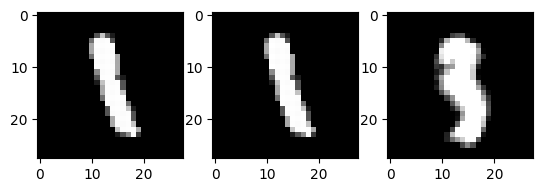

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.395226
Train Epoch: 7 [2048/60000 (3%)]	Loss: 0.391642
Train Epoch: 7 [4096/60000 (7%)]	Loss: 0.391352
Train Epoch: 7 [6144/60000 (10%)]	Loss: 0.390467
Train Epoch: 7 [8192/60000 (13%)]	Loss: 0.387350
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.388535
Train Epoch: 7 [12288/60000 (20%)]	Loss: 0.385520
Train Epoch: 7 [14336/60000 (23%)]	Loss: 0.385835
Train Epoch: 7 [16384/60000 (27%)]	Loss: 0.381346
Train Epoch: 7 [18432/60000 (30%)]	Loss: 0.380895
Train Epoch: 7 [20480/60000 (33%)]	Loss: 0.380463
Train Epoch: 7 [22528/60000 (37%)]	Loss: 0.380679
Train Epoch: 7 [24576/60000 (40%)]	Loss: 0.381458
Train Epoch: 7 [26624/60000 (43%)]	Loss: 0.378650
Train Epoch: 7 [28672/60000 (47%)]	Loss: 0.377386
Train Epoch: 7 [30720/60000 (50%)]	Loss: 0.377616
Train Epoch: 7 [32768/60000 (53%)]	Loss: 0.375185
Train Epoch: 7 [34816/60000 (57%)]	Loss: 0.373536
Train Epoch: 7 [36864/60000 (60%)]	Loss: 0.373896
Train Epoch: 7 [38912/60000 (63%)]	Loss: 0.370847
Train Epoch

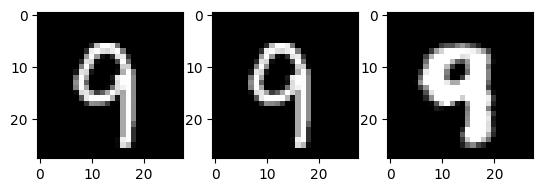

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.360067
Train Epoch: 8 [2048/60000 (3%)]	Loss: 0.356411
Train Epoch: 8 [4096/60000 (7%)]	Loss: 0.358385
Train Epoch: 8 [6144/60000 (10%)]	Loss: 0.359345
Train Epoch: 8 [8192/60000 (13%)]	Loss: 0.355241
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.355178
Train Epoch: 8 [12288/60000 (20%)]	Loss: 0.354910
Train Epoch: 8 [14336/60000 (23%)]	Loss: 0.351841
Train Epoch: 8 [16384/60000 (27%)]	Loss: 0.352506
Train Epoch: 8 [18432/60000 (30%)]	Loss: 0.353396
Train Epoch: 8 [20480/60000 (33%)]	Loss: 0.352521
Train Epoch: 8 [22528/60000 (37%)]	Loss: 0.347352
Train Epoch: 8 [24576/60000 (40%)]	Loss: 0.346857
Train Epoch: 8 [26624/60000 (43%)]	Loss: 0.345757
Train Epoch: 8 [28672/60000 (47%)]	Loss: 0.345490
Train Epoch: 8 [30720/60000 (50%)]	Loss: 0.343240
Train Epoch: 8 [32768/60000 (53%)]	Loss: 0.343257
Train Epoch: 8 [34816/60000 (57%)]	Loss: 0.344962
Train Epoch: 8 [36864/60000 (60%)]	Loss: 0.340626
Train Epoch: 8 [38912/60000 (63%)]	Loss: 0.340236
Train Epoch

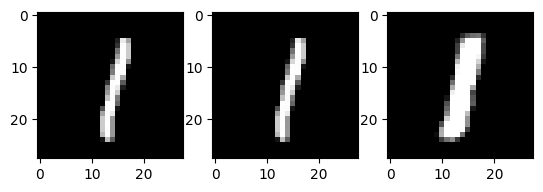

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.327817
Train Epoch: 9 [2048/60000 (3%)]	Loss: 0.327922
Train Epoch: 9 [4096/60000 (7%)]	Loss: 0.327459
Train Epoch: 9 [6144/60000 (10%)]	Loss: 0.327270
Train Epoch: 9 [8192/60000 (13%)]	Loss: 0.325957
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.324272
Train Epoch: 9 [12288/60000 (20%)]	Loss: 0.324480
Train Epoch: 9 [14336/60000 (23%)]	Loss: 0.323213
Train Epoch: 9 [16384/60000 (27%)]	Loss: 0.322604
Train Epoch: 9 [18432/60000 (30%)]	Loss: 0.322293
Train Epoch: 9 [20480/60000 (33%)]	Loss: 0.319954
Train Epoch: 9 [22528/60000 (37%)]	Loss: 0.319211
Train Epoch: 9 [24576/60000 (40%)]	Loss: 0.316591
Train Epoch: 9 [26624/60000 (43%)]	Loss: 0.317549
Train Epoch: 9 [28672/60000 (47%)]	Loss: 0.315153
Train Epoch: 9 [30720/60000 (50%)]	Loss: 0.314819
Train Epoch: 9 [32768/60000 (53%)]	Loss: 0.313496
Train Epoch: 9 [34816/60000 (57%)]	Loss: 0.314298
Train Epoch: 9 [36864/60000 (60%)]	Loss: 0.313981
Train Epoch: 9 [38912/60000 (63%)]	Loss: 0.313522
Train Epoch

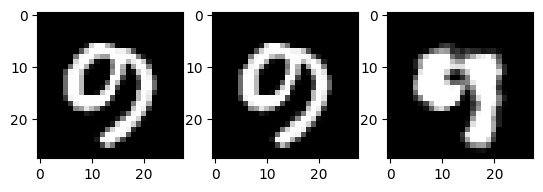

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.303323
Train Epoch: 10 [2048/60000 (3%)]	Loss: 0.301412
Train Epoch: 10 [4096/60000 (7%)]	Loss: 0.301372
Train Epoch: 10 [6144/60000 (10%)]	Loss: 0.297250
Train Epoch: 10 [8192/60000 (13%)]	Loss: 0.297074
Train Epoch: 10 [10240/60000 (17%)]	Loss: 0.297022
Train Epoch: 10 [12288/60000 (20%)]	Loss: 0.298533
Train Epoch: 10 [14336/60000 (23%)]	Loss: 0.295742
Train Epoch: 10 [16384/60000 (27%)]	Loss: 0.294821
Train Epoch: 10 [18432/60000 (30%)]	Loss: 0.295312
Train Epoch: 10 [20480/60000 (33%)]	Loss: 0.293578
Train Epoch: 10 [22528/60000 (37%)]	Loss: 0.294280
Train Epoch: 10 [24576/60000 (40%)]	Loss: 0.291001
Train Epoch: 10 [26624/60000 (43%)]	Loss: 0.288482
Train Epoch: 10 [28672/60000 (47%)]	Loss: 0.288803
Train Epoch: 10 [30720/60000 (50%)]	Loss: 0.290155
Train Epoch: 10 [32768/60000 (53%)]	Loss: 0.286447
Train Epoch: 10 [34816/60000 (57%)]	Loss: 0.288246
Train Epoch: 10 [36864/60000 (60%)]	Loss: 0.284696
Train Epoch: 10 [38912/60000 (63%)]	Loss: 

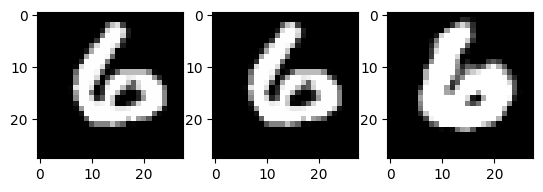

New best! Saving...
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.276344
Train Epoch: 11 [2048/60000 (3%)]	Loss: 0.274368
Train Epoch: 11 [4096/60000 (7%)]	Loss: 0.274712
Train Epoch: 11 [6144/60000 (10%)]	Loss: 0.273937
Train Epoch: 11 [8192/60000 (13%)]	Loss: 0.273983
Train Epoch: 11 [10240/60000 (17%)]	Loss: 0.272792
Train Epoch: 11 [12288/60000 (20%)]	Loss: 0.270931
Train Epoch: 11 [14336/60000 (23%)]	Loss: 0.269501
Train Epoch: 11 [16384/60000 (27%)]	Loss: 0.270993
Train Epoch: 11 [18432/60000 (30%)]	Loss: 0.270864
Train Epoch: 11 [20480/60000 (33%)]	Loss: 0.266826
Train Epoch: 11 [22528/60000 (37%)]	Loss: 0.266429
Train Epoch: 11 [24576/60000 (40%)]	Loss: 0.267102
Train Epoch: 11 [26624/60000 (43%)]	Loss: 0.267210
Train Epoch: 11 [28672/60000 (47%)]	Loss: 0.263914
Train Epoch: 11 [30720/60000 (50%)]	Loss: 0.263339
Train Epoch: 11 [32768/60000 (53%)]	Loss: 0.263105
Train Epoch: 11 [34816/60000 (57%)]	Loss: 0.263365
Train Epoch: 11 [36864/60000 (60%)]	Loss: 0.261445
Train Epoch: 11 [38912

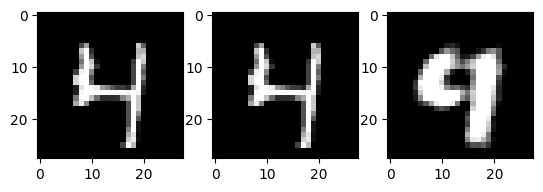

New best! Saving...
Train Epoch: 12 [0/60000 (0%)]	Loss: 0.252874
Train Epoch: 12 [2048/60000 (3%)]	Loss: 0.253449
Train Epoch: 12 [4096/60000 (7%)]	Loss: 0.251023
Train Epoch: 12 [6144/60000 (10%)]	Loss: 0.251654
Train Epoch: 12 [8192/60000 (13%)]	Loss: 0.250185
Train Epoch: 12 [10240/60000 (17%)]	Loss: 0.249579
Train Epoch: 12 [12288/60000 (20%)]	Loss: 0.248393
Train Epoch: 12 [14336/60000 (23%)]	Loss: 0.249576
Train Epoch: 12 [16384/60000 (27%)]	Loss: 0.245802
Train Epoch: 12 [18432/60000 (30%)]	Loss: 0.244891
Train Epoch: 12 [20480/60000 (33%)]	Loss: 0.244840
Train Epoch: 12 [22528/60000 (37%)]	Loss: 0.246860
Train Epoch: 12 [24576/60000 (40%)]	Loss: 0.246070
Train Epoch: 12 [26624/60000 (43%)]	Loss: 0.242073
Train Epoch: 12 [28672/60000 (47%)]	Loss: 0.242669
Train Epoch: 12 [30720/60000 (50%)]	Loss: 0.242895
Train Epoch: 12 [32768/60000 (53%)]	Loss: 0.239374
Train Epoch: 12 [34816/60000 (57%)]	Loss: 0.240021
Train Epoch: 12 [36864/60000 (60%)]	Loss: 0.237923
Train Epoch: 12 [38912

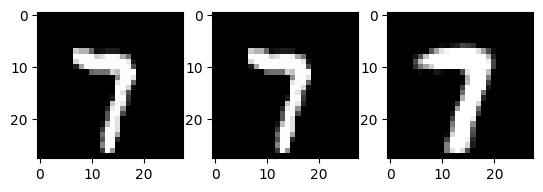

New best! Saving...
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.229357
Train Epoch: 13 [2048/60000 (3%)]	Loss: 0.231784
Train Epoch: 13 [4096/60000 (7%)]	Loss: 0.230777
Train Epoch: 13 [6144/60000 (10%)]	Loss: 0.229792
Train Epoch: 13 [8192/60000 (13%)]	Loss: 0.228033
Train Epoch: 13 [10240/60000 (17%)]	Loss: 0.227121
Train Epoch: 13 [12288/60000 (20%)]	Loss: 0.225728
Train Epoch: 13 [14336/60000 (23%)]	Loss: 0.225984
Train Epoch: 13 [16384/60000 (27%)]	Loss: 0.226042
Train Epoch: 13 [18432/60000 (30%)]	Loss: 0.225741
Train Epoch: 13 [20480/60000 (33%)]	Loss: 0.224318
Train Epoch: 13 [22528/60000 (37%)]	Loss: 0.224012
Train Epoch: 13 [24576/60000 (40%)]	Loss: 0.224452
Train Epoch: 13 [26624/60000 (43%)]	Loss: 0.222851
Train Epoch: 13 [28672/60000 (47%)]	Loss: 0.220579
Train Epoch: 13 [30720/60000 (50%)]	Loss: 0.221327
Train Epoch: 13 [32768/60000 (53%)]	Loss: 0.221049
Train Epoch: 13 [34816/60000 (57%)]	Loss: 0.220848
Train Epoch: 13 [36864/60000 (60%)]	Loss: 0.218746
Train Epoch: 13 [38912

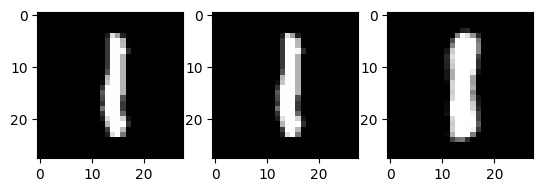

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.212078
Train Epoch: 14 [2048/60000 (3%)]	Loss: 0.210545
Train Epoch: 14 [4096/60000 (7%)]	Loss: 0.208698
Train Epoch: 14 [6144/60000 (10%)]	Loss: 0.206822
Train Epoch: 14 [8192/60000 (13%)]	Loss: 0.208972
Train Epoch: 14 [10240/60000 (17%)]	Loss: 0.208536
Train Epoch: 14 [12288/60000 (20%)]	Loss: 0.208476
Train Epoch: 14 [14336/60000 (23%)]	Loss: 0.206321
Train Epoch: 14 [16384/60000 (27%)]	Loss: 0.207736
Train Epoch: 14 [18432/60000 (30%)]	Loss: 0.205737
Train Epoch: 14 [20480/60000 (33%)]	Loss: 0.206311
Train Epoch: 14 [22528/60000 (37%)]	Loss: 0.204048
Train Epoch: 14 [24576/60000 (40%)]	Loss: 0.203632
Train Epoch: 14 [26624/60000 (43%)]	Loss: 0.202710
Train Epoch: 14 [28672/60000 (47%)]	Loss: 0.201625
Train Epoch: 14 [30720/60000 (50%)]	Loss: 0.203976
Train Epoch: 14 [32768/60000 (53%)]	Loss: 0.202566
Train Epoch: 14 [34816/60000 (57%)]	Loss: 0.201420
Train Epoch: 14 [36864/60000 (60%)]	Loss: 0.198980
Train Epoch: 14 [38912/60000 (63%)]	Loss: 

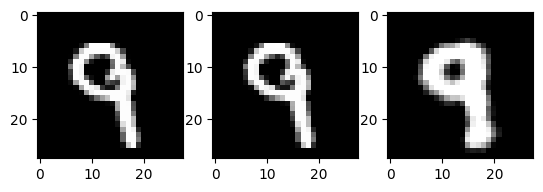

New best! Saving...
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.193109
Train Epoch: 15 [2048/60000 (3%)]	Loss: 0.190792
Train Epoch: 15 [4096/60000 (7%)]	Loss: 0.192717
Train Epoch: 15 [6144/60000 (10%)]	Loss: 0.191544
Train Epoch: 15 [8192/60000 (13%)]	Loss: 0.191436
Train Epoch: 15 [10240/60000 (17%)]	Loss: 0.188304
Train Epoch: 15 [12288/60000 (20%)]	Loss: 0.190455
Train Epoch: 15 [14336/60000 (23%)]	Loss: 0.191630
Train Epoch: 15 [16384/60000 (27%)]	Loss: 0.187794
Train Epoch: 15 [18432/60000 (30%)]	Loss: 0.186111
Train Epoch: 15 [20480/60000 (33%)]	Loss: 0.188195
Train Epoch: 15 [22528/60000 (37%)]	Loss: 0.188248
Train Epoch: 15 [24576/60000 (40%)]	Loss: 0.184759
Train Epoch: 15 [26624/60000 (43%)]	Loss: 0.185494
Train Epoch: 15 [28672/60000 (47%)]	Loss: 0.185762
Train Epoch: 15 [30720/60000 (50%)]	Loss: 0.184862
Train Epoch: 15 [32768/60000 (53%)]	Loss: 0.185174
Train Epoch: 15 [34816/60000 (57%)]	Loss: 0.183268
Train Epoch: 15 [36864/60000 (60%)]	Loss: 0.181877
Train Epoch: 15 [38912

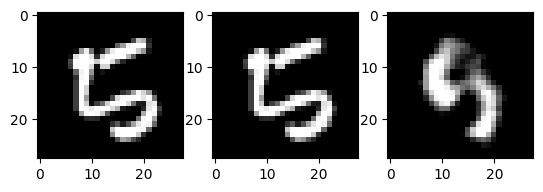

New best! Saving...
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.176057
Train Epoch: 16 [2048/60000 (3%)]	Loss: 0.176250
Train Epoch: 16 [4096/60000 (7%)]	Loss: 0.176987
Train Epoch: 16 [6144/60000 (10%)]	Loss: 0.174962
Train Epoch: 16 [8192/60000 (13%)]	Loss: 0.175019
Train Epoch: 16 [10240/60000 (17%)]	Loss: 0.176551
Train Epoch: 16 [12288/60000 (20%)]	Loss: 0.175398
Train Epoch: 16 [14336/60000 (23%)]	Loss: 0.173493
Train Epoch: 16 [16384/60000 (27%)]	Loss: 0.173635
Train Epoch: 16 [18432/60000 (30%)]	Loss: 0.173583
Train Epoch: 16 [20480/60000 (33%)]	Loss: 0.173170
Train Epoch: 16 [22528/60000 (37%)]	Loss: 0.174696
Train Epoch: 16 [24576/60000 (40%)]	Loss: 0.173276
Train Epoch: 16 [26624/60000 (43%)]	Loss: 0.173635
Train Epoch: 16 [28672/60000 (47%)]	Loss: 0.173429
Train Epoch: 16 [30720/60000 (50%)]	Loss: 0.171723
Train Epoch: 16 [32768/60000 (53%)]	Loss: 0.170237
Train Epoch: 16 [34816/60000 (57%)]	Loss: 0.172987
Train Epoch: 16 [36864/60000 (60%)]	Loss: 0.170443
Train Epoch: 16 [38912

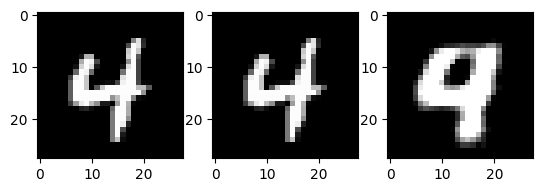

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.168459
Train Epoch: 17 [2048/60000 (3%)]	Loss: 0.168268
Train Epoch: 17 [4096/60000 (7%)]	Loss: 0.167030
Train Epoch: 17 [6144/60000 (10%)]	Loss: 0.166137
Train Epoch: 17 [8192/60000 (13%)]	Loss: 0.166754
Train Epoch: 17 [10240/60000 (17%)]	Loss: 0.167332
Train Epoch: 17 [12288/60000 (20%)]	Loss: 0.165866
Train Epoch: 17 [14336/60000 (23%)]	Loss: 0.166358
Train Epoch: 17 [16384/60000 (27%)]	Loss: 0.167123
Train Epoch: 17 [18432/60000 (30%)]	Loss: 0.165153
Train Epoch: 17 [20480/60000 (33%)]	Loss: 0.166794
Train Epoch: 17 [22528/60000 (37%)]	Loss: 0.164838
Train Epoch: 17 [24576/60000 (40%)]	Loss: 0.165276
Train Epoch: 17 [26624/60000 (43%)]	Loss: 0.164921
Train Epoch: 17 [28672/60000 (47%)]	Loss: 0.165217
Train Epoch: 17 [30720/60000 (50%)]	Loss: 0.165070
Train Epoch: 17 [32768/60000 (53%)]	Loss: 0.163298
Train Epoch: 17 [34816/60000 (57%)]	Loss: 0.164411
Train Epoch: 17 [36864/60000 (60%)]	Loss: 0.163249
Train Epoch: 17 [38912/60000 (63%)]	Loss: 

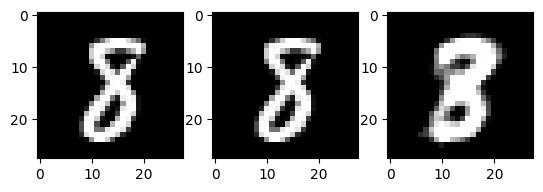

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.161476
Train Epoch: 18 [2048/60000 (3%)]	Loss: 0.160665
Train Epoch: 18 [4096/60000 (7%)]	Loss: 0.161312
Train Epoch: 18 [6144/60000 (10%)]	Loss: 0.159502
Train Epoch: 18 [8192/60000 (13%)]	Loss: 0.159614
Train Epoch: 18 [10240/60000 (17%)]	Loss: 0.158753
Train Epoch: 18 [12288/60000 (20%)]	Loss: 0.160836
Train Epoch: 18 [14336/60000 (23%)]	Loss: 0.158779
Train Epoch: 18 [16384/60000 (27%)]	Loss: 0.159237
Train Epoch: 18 [18432/60000 (30%)]	Loss: 0.157915
Train Epoch: 18 [20480/60000 (33%)]	Loss: 0.157576
Train Epoch: 18 [22528/60000 (37%)]	Loss: 0.159104
Train Epoch: 18 [24576/60000 (40%)]	Loss: 0.157221
Train Epoch: 18 [26624/60000 (43%)]	Loss: 0.157641
Train Epoch: 18 [28672/60000 (47%)]	Loss: 0.156318
Train Epoch: 18 [30720/60000 (50%)]	Loss: 0.157380
Train Epoch: 18 [32768/60000 (53%)]	Loss: 0.157272
Train Epoch: 18 [34816/60000 (57%)]	Loss: 0.156119
Train Epoch: 18 [36864/60000 (60%)]	Loss: 0.156281
Train Epoch: 18 [38912/60000 (63%)]	Loss: 

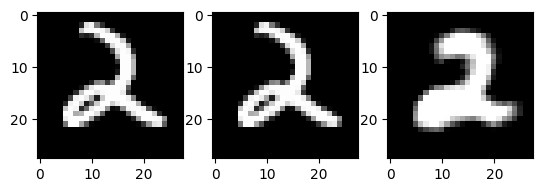

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.154258
Train Epoch: 19 [2048/60000 (3%)]	Loss: 0.152577
Train Epoch: 19 [4096/60000 (7%)]	Loss: 0.152013
Train Epoch: 19 [6144/60000 (10%)]	Loss: 0.152550
Train Epoch: 19 [8192/60000 (13%)]	Loss: 0.153146
Train Epoch: 19 [10240/60000 (17%)]	Loss: 0.152139
Train Epoch: 19 [12288/60000 (20%)]	Loss: 0.152046
Train Epoch: 19 [14336/60000 (23%)]	Loss: 0.152126
Train Epoch: 19 [16384/60000 (27%)]	Loss: 0.150783
Train Epoch: 19 [18432/60000 (30%)]	Loss: 0.149716
Train Epoch: 19 [20480/60000 (33%)]	Loss: 0.151292
Train Epoch: 19 [22528/60000 (37%)]	Loss: 0.151784
Train Epoch: 19 [24576/60000 (40%)]	Loss: 0.149845
Train Epoch: 19 [26624/60000 (43%)]	Loss: 0.149069
Train Epoch: 19 [28672/60000 (47%)]	Loss: 0.150828
Train Epoch: 19 [30720/60000 (50%)]	Loss: 0.150698
Train Epoch: 19 [32768/60000 (53%)]	Loss: 0.149221
Train Epoch: 19 [34816/60000 (57%)]	Loss: 0.150196
Train Epoch: 19 [36864/60000 (60%)]	Loss: 0.148004
Train Epoch: 19 [38912/60000 (63%)]	Loss: 

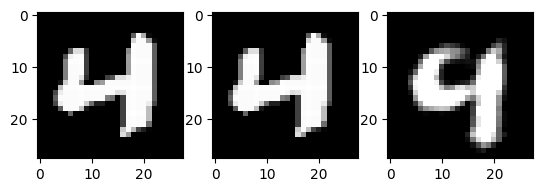

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.144903
Train Epoch: 20 [2048/60000 (3%)]	Loss: 0.146521
Train Epoch: 20 [4096/60000 (7%)]	Loss: 0.145797
Train Epoch: 20 [6144/60000 (10%)]	Loss: 0.145605
Train Epoch: 20 [8192/60000 (13%)]	Loss: 0.146370
Train Epoch: 20 [10240/60000 (17%)]	Loss: 0.145693
Train Epoch: 20 [12288/60000 (20%)]	Loss: 0.145361
Train Epoch: 20 [14336/60000 (23%)]	Loss: 0.147073
Train Epoch: 20 [16384/60000 (27%)]	Loss: 0.144604
Train Epoch: 20 [18432/60000 (30%)]	Loss: 0.145451
Train Epoch: 20 [20480/60000 (33%)]	Loss: 0.144489
Train Epoch: 20 [22528/60000 (37%)]	Loss: 0.143625
Train Epoch: 20 [24576/60000 (40%)]	Loss: 0.143569
Train Epoch: 20 [26624/60000 (43%)]	Loss: 0.143974
Train Epoch: 20 [28672/60000 (47%)]	Loss: 0.143526
Train Epoch: 20 [30720/60000 (50%)]	Loss: 0.144571
Train Epoch: 20 [32768/60000 (53%)]	Loss: 0.142172
Train Epoch: 20 [34816/60000 (57%)]	Loss: 0.140303
Train Epoch: 20 [36864/60000 (60%)]	Loss: 0.141971
Train Epoch: 20 [38912/60000 (63%)]	Loss: 

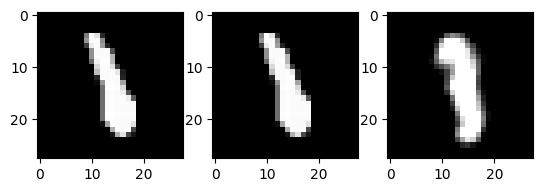

Train Epoch: 21 [0/60000 (0%)]	Loss: 0.140500
Train Epoch: 21 [2048/60000 (3%)]	Loss: 0.139526
Train Epoch: 21 [4096/60000 (7%)]	Loss: 0.139705
Train Epoch: 21 [6144/60000 (10%)]	Loss: 0.139295
Train Epoch: 21 [8192/60000 (13%)]	Loss: 0.137926
Train Epoch: 21 [10240/60000 (17%)]	Loss: 0.138807
Train Epoch: 21 [12288/60000 (20%)]	Loss: 0.138607
Train Epoch: 21 [14336/60000 (23%)]	Loss: 0.139338
Train Epoch: 21 [16384/60000 (27%)]	Loss: 0.137226
Train Epoch: 21 [18432/60000 (30%)]	Loss: 0.138728
Train Epoch: 21 [20480/60000 (33%)]	Loss: 0.136698
Train Epoch: 21 [22528/60000 (37%)]	Loss: 0.136399
Train Epoch: 21 [24576/60000 (40%)]	Loss: 0.138687
Train Epoch: 21 [26624/60000 (43%)]	Loss: 0.137012
Train Epoch: 21 [28672/60000 (47%)]	Loss: 0.135495
Train Epoch: 21 [30720/60000 (50%)]	Loss: 0.137529
Train Epoch: 21 [32768/60000 (53%)]	Loss: 0.136503
Train Epoch: 21 [34816/60000 (57%)]	Loss: 0.136694
Train Epoch: 21 [36864/60000 (60%)]	Loss: 0.134986
Train Epoch: 21 [38912/60000 (63%)]	Loss: 

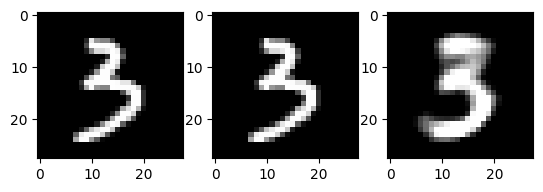

Train Epoch: 22 [0/60000 (0%)]	Loss: 0.133815
Train Epoch: 22 [2048/60000 (3%)]	Loss: 0.132495
Train Epoch: 22 [4096/60000 (7%)]	Loss: 0.133829
Train Epoch: 22 [6144/60000 (10%)]	Loss: 0.132182
Train Epoch: 22 [8192/60000 (13%)]	Loss: 0.133414
Train Epoch: 22 [10240/60000 (17%)]	Loss: 0.132525
Train Epoch: 22 [12288/60000 (20%)]	Loss: 0.133145
Train Epoch: 22 [14336/60000 (23%)]	Loss: 0.131751
Train Epoch: 22 [16384/60000 (27%)]	Loss: 0.132138
Train Epoch: 22 [18432/60000 (30%)]	Loss: 0.131155
Train Epoch: 22 [20480/60000 (33%)]	Loss: 0.131335
Train Epoch: 22 [22528/60000 (37%)]	Loss: 0.131631
Train Epoch: 22 [24576/60000 (40%)]	Loss: 0.130661
Train Epoch: 22 [26624/60000 (43%)]	Loss: 0.130180
Train Epoch: 22 [28672/60000 (47%)]	Loss: 0.130229
Train Epoch: 22 [30720/60000 (50%)]	Loss: 0.129530
Train Epoch: 22 [32768/60000 (53%)]	Loss: 0.130406
Train Epoch: 22 [34816/60000 (57%)]	Loss: 0.129589
Train Epoch: 22 [36864/60000 (60%)]	Loss: 0.129939
Train Epoch: 22 [38912/60000 (63%)]	Loss: 

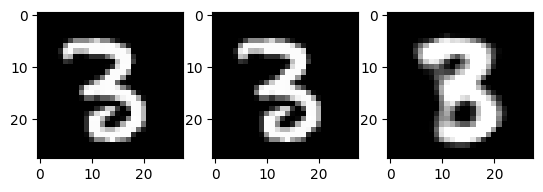

New best! Saving...
Train Epoch: 23 [0/60000 (0%)]	Loss: 0.127971
Train Epoch: 23 [2048/60000 (3%)]	Loss: 0.126984
Train Epoch: 23 [4096/60000 (7%)]	Loss: 0.126283
Train Epoch: 23 [6144/60000 (10%)]	Loss: 0.126551
Train Epoch: 23 [8192/60000 (13%)]	Loss: 0.126081
Train Epoch: 23 [10240/60000 (17%)]	Loss: 0.125672
Train Epoch: 23 [12288/60000 (20%)]	Loss: 0.125536
Train Epoch: 23 [14336/60000 (23%)]	Loss: 0.126297
Train Epoch: 23 [16384/60000 (27%)]	Loss: 0.125645
Train Epoch: 23 [18432/60000 (30%)]	Loss: 0.124340
Train Epoch: 23 [20480/60000 (33%)]	Loss: 0.125681
Train Epoch: 23 [22528/60000 (37%)]	Loss: 0.125242
Train Epoch: 23 [24576/60000 (40%)]	Loss: 0.124433
Train Epoch: 23 [26624/60000 (43%)]	Loss: 0.124529
Train Epoch: 23 [28672/60000 (47%)]	Loss: 0.124937
Train Epoch: 23 [30720/60000 (50%)]	Loss: 0.124208
Train Epoch: 23 [32768/60000 (53%)]	Loss: 0.122626
Train Epoch: 23 [34816/60000 (57%)]	Loss: 0.123162
Train Epoch: 23 [36864/60000 (60%)]	Loss: 0.124157
Train Epoch: 23 [38912

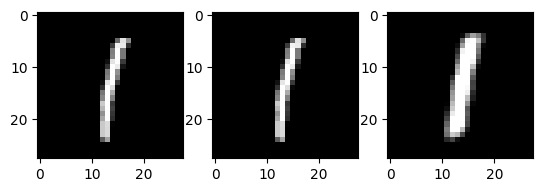

New best! Saving...
Train Epoch: 24 [0/60000 (0%)]	Loss: 0.121487
Train Epoch: 24 [2048/60000 (3%)]	Loss: 0.121554
Train Epoch: 24 [4096/60000 (7%)]	Loss: 0.120344
Train Epoch: 24 [6144/60000 (10%)]	Loss: 0.120638
Train Epoch: 24 [8192/60000 (13%)]	Loss: 0.119882
Train Epoch: 24 [10240/60000 (17%)]	Loss: 0.120018
Train Epoch: 24 [12288/60000 (20%)]	Loss: 0.120562
Train Epoch: 24 [14336/60000 (23%)]	Loss: 0.119602
Train Epoch: 24 [16384/60000 (27%)]	Loss: 0.120595
Train Epoch: 24 [18432/60000 (30%)]	Loss: 0.118051
Train Epoch: 24 [20480/60000 (33%)]	Loss: 0.119844
Train Epoch: 24 [22528/60000 (37%)]	Loss: 0.119673
Train Epoch: 24 [24576/60000 (40%)]	Loss: 0.120871
Train Epoch: 24 [26624/60000 (43%)]	Loss: 0.119116
Train Epoch: 24 [28672/60000 (47%)]	Loss: 0.118266
Train Epoch: 24 [30720/60000 (50%)]	Loss: 0.118627
Train Epoch: 24 [32768/60000 (53%)]	Loss: 0.119293
Train Epoch: 24 [34816/60000 (57%)]	Loss: 0.118128
Train Epoch: 24 [36864/60000 (60%)]	Loss: 0.116208
Train Epoch: 24 [38912

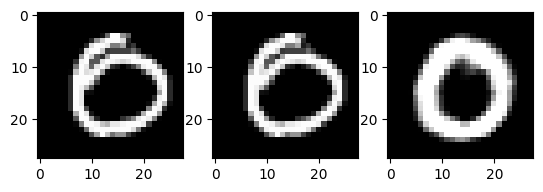

New best! Saving...
Train Epoch: 25 [0/60000 (0%)]	Loss: 0.115435
Train Epoch: 25 [2048/60000 (3%)]	Loss: 0.115698
Train Epoch: 25 [4096/60000 (7%)]	Loss: 0.115600
Train Epoch: 25 [6144/60000 (10%)]	Loss: 0.115129
Train Epoch: 25 [8192/60000 (13%)]	Loss: 0.115170
Train Epoch: 25 [10240/60000 (17%)]	Loss: 0.113895
Train Epoch: 25 [12288/60000 (20%)]	Loss: 0.114397
Train Epoch: 25 [14336/60000 (23%)]	Loss: 0.113802
Train Epoch: 25 [16384/60000 (27%)]	Loss: 0.112917
Train Epoch: 25 [18432/60000 (30%)]	Loss: 0.113627
Train Epoch: 25 [20480/60000 (33%)]	Loss: 0.112727
Train Epoch: 25 [22528/60000 (37%)]	Loss: 0.113337
Train Epoch: 25 [24576/60000 (40%)]	Loss: 0.113748
Train Epoch: 25 [26624/60000 (43%)]	Loss: 0.113243
Train Epoch: 25 [28672/60000 (47%)]	Loss: 0.113739
Train Epoch: 25 [30720/60000 (50%)]	Loss: 0.112151
Train Epoch: 25 [32768/60000 (53%)]	Loss: 0.112570
Train Epoch: 25 [34816/60000 (57%)]	Loss: 0.113698
Train Epoch: 25 [36864/60000 (60%)]	Loss: 0.112635
Train Epoch: 25 [38912

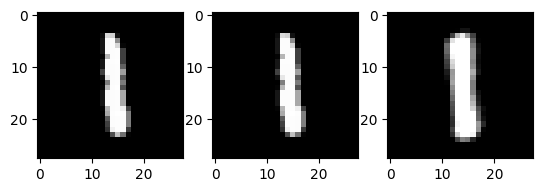

Train Epoch: 26 [0/60000 (0%)]	Loss: 0.110415
Train Epoch: 26 [2048/60000 (3%)]	Loss: 0.109511
Train Epoch: 26 [4096/60000 (7%)]	Loss: 0.110287
Train Epoch: 26 [6144/60000 (10%)]	Loss: 0.111329
Train Epoch: 26 [8192/60000 (13%)]	Loss: 0.110127
Train Epoch: 26 [10240/60000 (17%)]	Loss: 0.108405
Train Epoch: 26 [12288/60000 (20%)]	Loss: 0.108697
Train Epoch: 26 [14336/60000 (23%)]	Loss: 0.109404
Train Epoch: 26 [16384/60000 (27%)]	Loss: 0.109199
Train Epoch: 26 [18432/60000 (30%)]	Loss: 0.108830
Train Epoch: 26 [20480/60000 (33%)]	Loss: 0.108350
Train Epoch: 26 [22528/60000 (37%)]	Loss: 0.107337
Train Epoch: 26 [24576/60000 (40%)]	Loss: 0.106833
Train Epoch: 26 [26624/60000 (43%)]	Loss: 0.107209
Train Epoch: 26 [28672/60000 (47%)]	Loss: 0.107472
Train Epoch: 26 [30720/60000 (50%)]	Loss: 0.106244
Train Epoch: 26 [32768/60000 (53%)]	Loss: 0.106668
Train Epoch: 26 [34816/60000 (57%)]	Loss: 0.105578
Train Epoch: 26 [36864/60000 (60%)]	Loss: 0.106654
Train Epoch: 26 [38912/60000 (63%)]	Loss: 

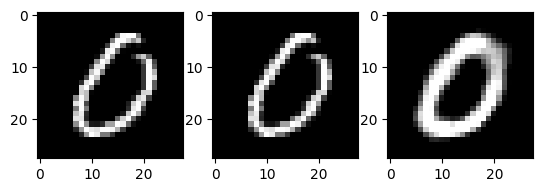

New best! Saving...
Train Epoch: 27 [0/60000 (0%)]	Loss: 0.105433
Train Epoch: 27 [2048/60000 (3%)]	Loss: 0.104030
Train Epoch: 27 [4096/60000 (7%)]	Loss: 0.104578
Train Epoch: 27 [6144/60000 (10%)]	Loss: 0.104408
Train Epoch: 27 [8192/60000 (13%)]	Loss: 0.103396
Train Epoch: 27 [10240/60000 (17%)]	Loss: 0.104395
Train Epoch: 27 [12288/60000 (20%)]	Loss: 0.104971
Train Epoch: 27 [14336/60000 (23%)]	Loss: 0.104002
Train Epoch: 27 [16384/60000 (27%)]	Loss: 0.103372
Train Epoch: 27 [18432/60000 (30%)]	Loss: 0.102841
Train Epoch: 27 [20480/60000 (33%)]	Loss: 0.103609
Train Epoch: 27 [22528/60000 (37%)]	Loss: 0.103355
Train Epoch: 27 [24576/60000 (40%)]	Loss: 0.103425
Train Epoch: 27 [26624/60000 (43%)]	Loss: 0.103200
Train Epoch: 27 [28672/60000 (47%)]	Loss: 0.102469
Train Epoch: 27 [30720/60000 (50%)]	Loss: 0.102419
Train Epoch: 27 [32768/60000 (53%)]	Loss: 0.103366
Train Epoch: 27 [34816/60000 (57%)]	Loss: 0.102569
Train Epoch: 27 [36864/60000 (60%)]	Loss: 0.100364
Train Epoch: 27 [38912

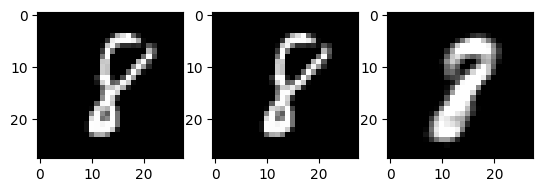

New best! Saving...
Train Epoch: 28 [0/60000 (0%)]	Loss: 0.100027
Train Epoch: 28 [2048/60000 (3%)]	Loss: 0.099311
Train Epoch: 28 [4096/60000 (7%)]	Loss: 0.099730
Train Epoch: 28 [6144/60000 (10%)]	Loss: 0.099159
Train Epoch: 28 [8192/60000 (13%)]	Loss: 0.099686
Train Epoch: 28 [10240/60000 (17%)]	Loss: 0.099166
Train Epoch: 28 [12288/60000 (20%)]	Loss: 0.098640
Train Epoch: 28 [14336/60000 (23%)]	Loss: 0.098543
Train Epoch: 28 [16384/60000 (27%)]	Loss: 0.098654
Train Epoch: 28 [18432/60000 (30%)]	Loss: 0.099282
Train Epoch: 28 [20480/60000 (33%)]	Loss: 0.099127
Train Epoch: 28 [22528/60000 (37%)]	Loss: 0.098077
Train Epoch: 28 [24576/60000 (40%)]	Loss: 0.098767
Train Epoch: 28 [26624/60000 (43%)]	Loss: 0.098248
Train Epoch: 28 [28672/60000 (47%)]	Loss: 0.097958
Train Epoch: 28 [30720/60000 (50%)]	Loss: 0.096913
Train Epoch: 28 [32768/60000 (53%)]	Loss: 0.096501
Train Epoch: 28 [34816/60000 (57%)]	Loss: 0.097950
Train Epoch: 28 [36864/60000 (60%)]	Loss: 0.098783
Train Epoch: 28 [38912

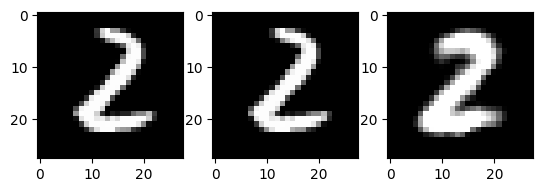

New best! Saving...
Train Epoch: 29 [0/60000 (0%)]	Loss: 0.094723
Train Epoch: 29 [2048/60000 (3%)]	Loss: 0.094246
Train Epoch: 29 [4096/60000 (7%)]	Loss: 0.094955
Train Epoch: 29 [6144/60000 (10%)]	Loss: 0.095206
Train Epoch: 29 [8192/60000 (13%)]	Loss: 0.094302
Train Epoch: 29 [10240/60000 (17%)]	Loss: 0.095178
Train Epoch: 29 [12288/60000 (20%)]	Loss: 0.093947
Train Epoch: 29 [14336/60000 (23%)]	Loss: 0.094459
Train Epoch: 29 [16384/60000 (27%)]	Loss: 0.094969
Train Epoch: 29 [18432/60000 (30%)]	Loss: 0.093713
Train Epoch: 29 [20480/60000 (33%)]	Loss: 0.094256
Train Epoch: 29 [22528/60000 (37%)]	Loss: 0.093384
Train Epoch: 29 [24576/60000 (40%)]	Loss: 0.094172
Train Epoch: 29 [26624/60000 (43%)]	Loss: 0.093924
Train Epoch: 29 [28672/60000 (47%)]	Loss: 0.093225
Train Epoch: 29 [30720/60000 (50%)]	Loss: 0.092761
Train Epoch: 29 [32768/60000 (53%)]	Loss: 0.092543
Train Epoch: 29 [34816/60000 (57%)]	Loss: 0.092009
Train Epoch: 29 [36864/60000 (60%)]	Loss: 0.092760
Train Epoch: 29 [38912

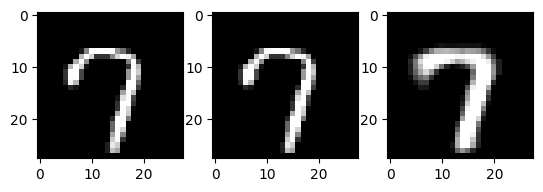

Train Epoch: 30 [0/60000 (0%)]	Loss: 0.091032
Train Epoch: 30 [2048/60000 (3%)]	Loss: 0.091430
Train Epoch: 30 [4096/60000 (7%)]	Loss: 0.090315
Train Epoch: 30 [6144/60000 (10%)]	Loss: 0.090360
Train Epoch: 30 [8192/60000 (13%)]	Loss: 0.089970
Train Epoch: 30 [10240/60000 (17%)]	Loss: 0.089551
Train Epoch: 30 [12288/60000 (20%)]	Loss: 0.090545
Train Epoch: 30 [14336/60000 (23%)]	Loss: 0.089302
Train Epoch: 30 [16384/60000 (27%)]	Loss: 0.090079
Train Epoch: 30 [18432/60000 (30%)]	Loss: 0.089087
Train Epoch: 30 [20480/60000 (33%)]	Loss: 0.089153
Train Epoch: 30 [22528/60000 (37%)]	Loss: 0.088033
Train Epoch: 30 [24576/60000 (40%)]	Loss: 0.087734
Train Epoch: 30 [26624/60000 (43%)]	Loss: 0.089853
Train Epoch: 30 [28672/60000 (47%)]	Loss: 0.089263
Train Epoch: 30 [30720/60000 (50%)]	Loss: 0.089343
Train Epoch: 30 [32768/60000 (53%)]	Loss: 0.089124
Train Epoch: 30 [34816/60000 (57%)]	Loss: 0.089265
Train Epoch: 30 [36864/60000 (60%)]	Loss: 0.088235
Train Epoch: 30 [38912/60000 (63%)]	Loss: 

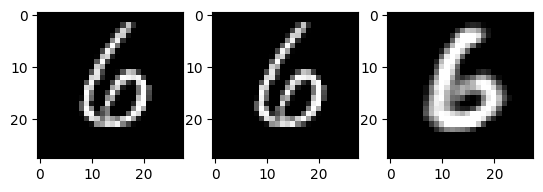

Train Epoch: 31 [0/60000 (0%)]	Loss: 0.086208
Train Epoch: 31 [2048/60000 (3%)]	Loss: 0.084712
Train Epoch: 31 [4096/60000 (7%)]	Loss: 0.085434
Train Epoch: 31 [6144/60000 (10%)]	Loss: 0.086625
Train Epoch: 31 [8192/60000 (13%)]	Loss: 0.084629
Train Epoch: 31 [10240/60000 (17%)]	Loss: 0.085212
Train Epoch: 31 [12288/60000 (20%)]	Loss: 0.085508
Train Epoch: 31 [14336/60000 (23%)]	Loss: 0.086746
Train Epoch: 31 [16384/60000 (27%)]	Loss: 0.085003
Train Epoch: 31 [18432/60000 (30%)]	Loss: 0.086779
Train Epoch: 31 [20480/60000 (33%)]	Loss: 0.086990
Train Epoch: 31 [22528/60000 (37%)]	Loss: 0.087392
Train Epoch: 31 [24576/60000 (40%)]	Loss: 0.085805
Train Epoch: 31 [26624/60000 (43%)]	Loss: 0.085269
Train Epoch: 31 [28672/60000 (47%)]	Loss: 0.085017
Train Epoch: 31 [30720/60000 (50%)]	Loss: 0.085351
Train Epoch: 31 [32768/60000 (53%)]	Loss: 0.085579
Train Epoch: 31 [34816/60000 (57%)]	Loss: 0.085207
Train Epoch: 31 [36864/60000 (60%)]	Loss: 0.085098
Train Epoch: 31 [38912/60000 (63%)]	Loss: 

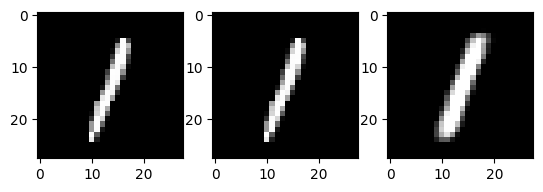

Train Epoch: 32 [0/60000 (0%)]	Loss: 0.084399
Train Epoch: 32 [2048/60000 (3%)]	Loss: 0.083981
Train Epoch: 32 [4096/60000 (7%)]	Loss: 0.084680
Train Epoch: 32 [6144/60000 (10%)]	Loss: 0.085376
Train Epoch: 32 [8192/60000 (13%)]	Loss: 0.083583
Train Epoch: 32 [10240/60000 (17%)]	Loss: 0.083364
Train Epoch: 32 [12288/60000 (20%)]	Loss: 0.084330
Train Epoch: 32 [14336/60000 (23%)]	Loss: 0.084909
Train Epoch: 32 [16384/60000 (27%)]	Loss: 0.082970
Train Epoch: 32 [18432/60000 (30%)]	Loss: 0.084655
Train Epoch: 32 [20480/60000 (33%)]	Loss: 0.083554
Train Epoch: 32 [22528/60000 (37%)]	Loss: 0.083023
Train Epoch: 32 [24576/60000 (40%)]	Loss: 0.082757
Train Epoch: 32 [26624/60000 (43%)]	Loss: 0.083603
Train Epoch: 32 [28672/60000 (47%)]	Loss: 0.083492
Train Epoch: 32 [30720/60000 (50%)]	Loss: 0.083309
Train Epoch: 32 [32768/60000 (53%)]	Loss: 0.084284
Train Epoch: 32 [34816/60000 (57%)]	Loss: 0.083607
Train Epoch: 32 [36864/60000 (60%)]	Loss: 0.083563
Train Epoch: 32 [38912/60000 (63%)]	Loss: 

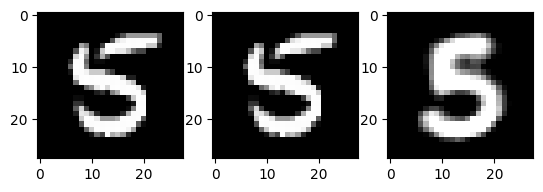

New best! Saving...
Train Epoch: 33 [0/60000 (0%)]	Loss: 0.082794
Train Epoch: 33 [2048/60000 (3%)]	Loss: 0.081529
Train Epoch: 33 [4096/60000 (7%)]	Loss: 0.081807
Train Epoch: 33 [6144/60000 (10%)]	Loss: 0.082901
Train Epoch: 33 [8192/60000 (13%)]	Loss: 0.082065
Train Epoch: 33 [10240/60000 (17%)]	Loss: 0.082782
Train Epoch: 33 [12288/60000 (20%)]	Loss: 0.082102
Train Epoch: 33 [14336/60000 (23%)]	Loss: 0.082554
Train Epoch: 33 [16384/60000 (27%)]	Loss: 0.081652
Train Epoch: 33 [18432/60000 (30%)]	Loss: 0.081683
Train Epoch: 33 [20480/60000 (33%)]	Loss: 0.080659
Train Epoch: 33 [22528/60000 (37%)]	Loss: 0.081826
Train Epoch: 33 [24576/60000 (40%)]	Loss: 0.082730
Train Epoch: 33 [26624/60000 (43%)]	Loss: 0.081481
Train Epoch: 33 [28672/60000 (47%)]	Loss: 0.082370
Train Epoch: 33 [30720/60000 (50%)]	Loss: 0.081628
Train Epoch: 33 [32768/60000 (53%)]	Loss: 0.081319
Train Epoch: 33 [34816/60000 (57%)]	Loss: 0.081556
Train Epoch: 33 [36864/60000 (60%)]	Loss: 0.081781
Train Epoch: 33 [38912

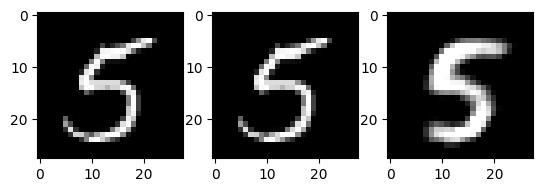

New best! Saving...
Train Epoch: 34 [0/60000 (0%)]	Loss: 0.080119
Train Epoch: 34 [2048/60000 (3%)]	Loss: 0.080992
Train Epoch: 34 [4096/60000 (7%)]	Loss: 0.080139
Train Epoch: 34 [6144/60000 (10%)]	Loss: 0.079458
Train Epoch: 34 [8192/60000 (13%)]	Loss: 0.078688
Train Epoch: 34 [10240/60000 (17%)]	Loss: 0.079592
Train Epoch: 34 [12288/60000 (20%)]	Loss: 0.079451
Train Epoch: 34 [14336/60000 (23%)]	Loss: 0.080279
Train Epoch: 34 [16384/60000 (27%)]	Loss: 0.080660
Train Epoch: 34 [18432/60000 (30%)]	Loss: 0.080641
Train Epoch: 34 [20480/60000 (33%)]	Loss: 0.080312
Train Epoch: 34 [22528/60000 (37%)]	Loss: 0.081375
Train Epoch: 34 [24576/60000 (40%)]	Loss: 0.078539
Train Epoch: 34 [26624/60000 (43%)]	Loss: 0.080990
Train Epoch: 34 [28672/60000 (47%)]	Loss: 0.079570
Train Epoch: 34 [30720/60000 (50%)]	Loss: 0.079035
Train Epoch: 34 [32768/60000 (53%)]	Loss: 0.080499
Train Epoch: 34 [34816/60000 (57%)]	Loss: 0.079246
Train Epoch: 34 [36864/60000 (60%)]	Loss: 0.080298
Train Epoch: 34 [38912

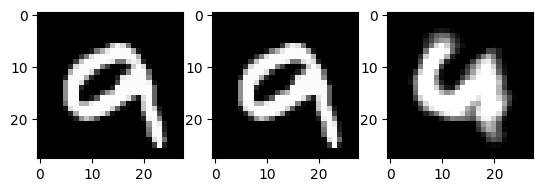

New best! Saving...
Train Epoch: 35 [0/60000 (0%)]	Loss: 0.078985
Train Epoch: 35 [2048/60000 (3%)]	Loss: 0.078522
Train Epoch: 35 [4096/60000 (7%)]	Loss: 0.078729
Train Epoch: 35 [6144/60000 (10%)]	Loss: 0.079141
Train Epoch: 35 [8192/60000 (13%)]	Loss: 0.077719
Train Epoch: 35 [10240/60000 (17%)]	Loss: 0.077788
Train Epoch: 35 [12288/60000 (20%)]	Loss: 0.078266
Train Epoch: 35 [14336/60000 (23%)]	Loss: 0.077847
Train Epoch: 35 [16384/60000 (27%)]	Loss: 0.076406
Train Epoch: 35 [18432/60000 (30%)]	Loss: 0.078644
Train Epoch: 35 [20480/60000 (33%)]	Loss: 0.077547
Train Epoch: 35 [22528/60000 (37%)]	Loss: 0.077967
Train Epoch: 35 [24576/60000 (40%)]	Loss: 0.078016
Train Epoch: 35 [26624/60000 (43%)]	Loss: 0.078171
Train Epoch: 35 [28672/60000 (47%)]	Loss: 0.078146
Train Epoch: 35 [30720/60000 (50%)]	Loss: 0.077591
Train Epoch: 35 [32768/60000 (53%)]	Loss: 0.078429
Train Epoch: 35 [34816/60000 (57%)]	Loss: 0.078571
Train Epoch: 35 [36864/60000 (60%)]	Loss: 0.077163
Train Epoch: 35 [38912

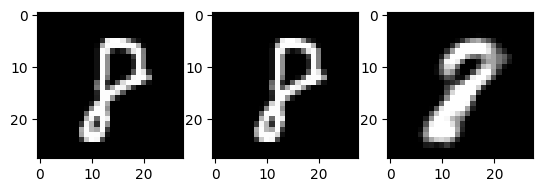

Train Epoch: 36 [0/60000 (0%)]	Loss: 0.076317
Train Epoch: 36 [2048/60000 (3%)]	Loss: 0.076369
Train Epoch: 36 [4096/60000 (7%)]	Loss: 0.076368
Train Epoch: 36 [6144/60000 (10%)]	Loss: 0.077176
Train Epoch: 36 [8192/60000 (13%)]	Loss: 0.075910
Train Epoch: 36 [10240/60000 (17%)]	Loss: 0.076486
Train Epoch: 36 [12288/60000 (20%)]	Loss: 0.077509
Train Epoch: 36 [14336/60000 (23%)]	Loss: 0.076245
Train Epoch: 36 [16384/60000 (27%)]	Loss: 0.075831
Train Epoch: 36 [18432/60000 (30%)]	Loss: 0.076433
Train Epoch: 36 [20480/60000 (33%)]	Loss: 0.075521
Train Epoch: 36 [22528/60000 (37%)]	Loss: 0.076163
Train Epoch: 36 [24576/60000 (40%)]	Loss: 0.075244
Train Epoch: 36 [26624/60000 (43%)]	Loss: 0.076508
Train Epoch: 36 [28672/60000 (47%)]	Loss: 0.074648
Train Epoch: 36 [30720/60000 (50%)]	Loss: 0.075019
Train Epoch: 36 [32768/60000 (53%)]	Loss: 0.075556
Train Epoch: 36 [34816/60000 (57%)]	Loss: 0.076009
Train Epoch: 36 [36864/60000 (60%)]	Loss: 0.076904
Train Epoch: 36 [38912/60000 (63%)]	Loss: 

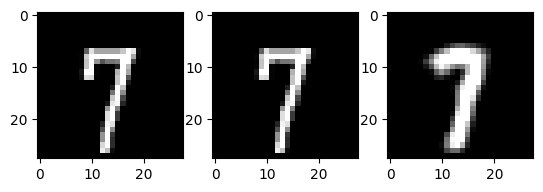

New best! Saving...
Train Epoch: 37 [0/60000 (0%)]	Loss: 0.075105
Train Epoch: 37 [2048/60000 (3%)]	Loss: 0.075220
Train Epoch: 37 [4096/60000 (7%)]	Loss: 0.074312
Train Epoch: 37 [6144/60000 (10%)]	Loss: 0.074100
Train Epoch: 37 [8192/60000 (13%)]	Loss: 0.075563
Train Epoch: 37 [10240/60000 (17%)]	Loss: 0.073965
Train Epoch: 37 [12288/60000 (20%)]	Loss: 0.074560
Train Epoch: 37 [14336/60000 (23%)]	Loss: 0.073918
Train Epoch: 37 [16384/60000 (27%)]	Loss: 0.074495
Train Epoch: 37 [18432/60000 (30%)]	Loss: 0.073737
Train Epoch: 37 [20480/60000 (33%)]	Loss: 0.074321
Train Epoch: 37 [22528/60000 (37%)]	Loss: 0.074833


In [ ]:
test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
best=float('inf')
for epoch in range(1, n_epochs + 1):
  train(network, train_loader, epoch, optimizer, loss_fn, log_interval, batch_size_train, train_losses, train_counter)
  test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
  if test_losses[-1] < best:
    best=test_losses[-1]
    print("New best! Saving...")
    torch.save(network.state_dict(), parameters_file)
  scheduler.step()

torch.save((train_counter, train_losses, test_losses), training_data_file)

cpu
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])


<Figure size 640x480 with 0 Axes>

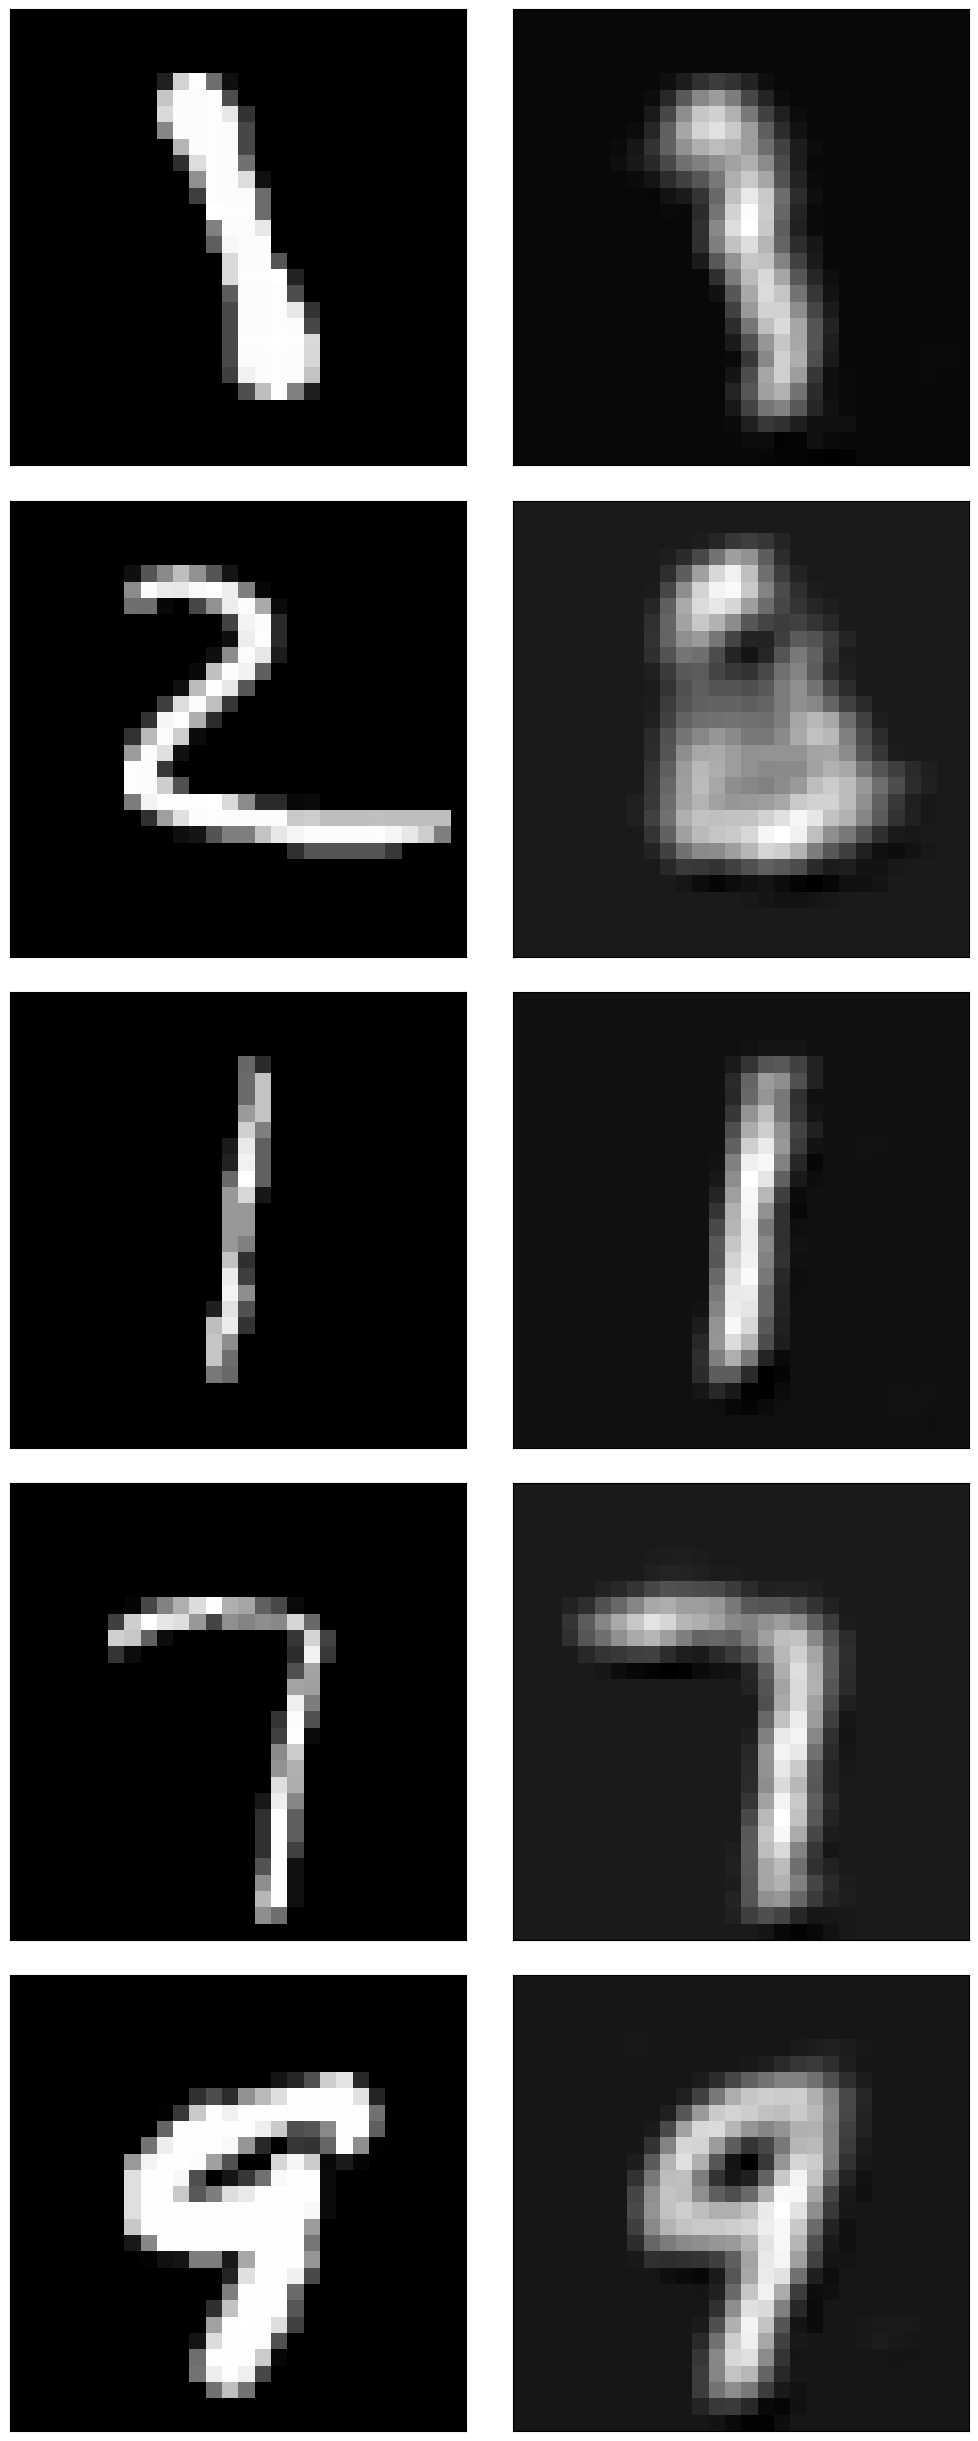

In [ ]:
print(device)
network.load_state_dict(torch.load(parameters_file, map_location=torch.device(device)))
network.eval()
fig = plt.figure()
length=5
begin=0
visualization_range = np.random.choice(len(test_data), length)
example_data = torch.stack([test_data[i][0] for i in visualization_range])
network.eval()
plt.figure(figsize=(2*5, length*5))
for i in range(length):
  print(example_data[i].shape)

  data = example_data[i].movedim(0, 2)

  print(data.shape)
  plt.subplot(length,2,2*i+1)
  plt.tight_layout()
  plt.imshow(data, cmap='gray')
  plt.xticks([])
  plt.yticks([])




  with torch.no_grad():
    output = network(example_data[i].to(device).unsqueeze(0)).squeeze(0)
    print (output.shape)
    plt.subplot(length,2,2*i+2)
    plt.tight_layout()
    plt.imshow(output.cpu().movedim(0, 2) , cmap='gray')
    plt.xticks([])
    plt.yticks([])


In [ ]:
encoder = network.Encoder
decoder = network.Decoder
latent_shape = encoder(train_data[0][0].unsqueeze(0).to(device)).shape

In [ ]:
mean, var, max_val, min_val = get_stats_latent(test_loader, encoder)

In [ ]:
print(mean, var, max_val, min_val)

NameError: ignored

torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 

<Figure size 640x480 with 0 Axes>

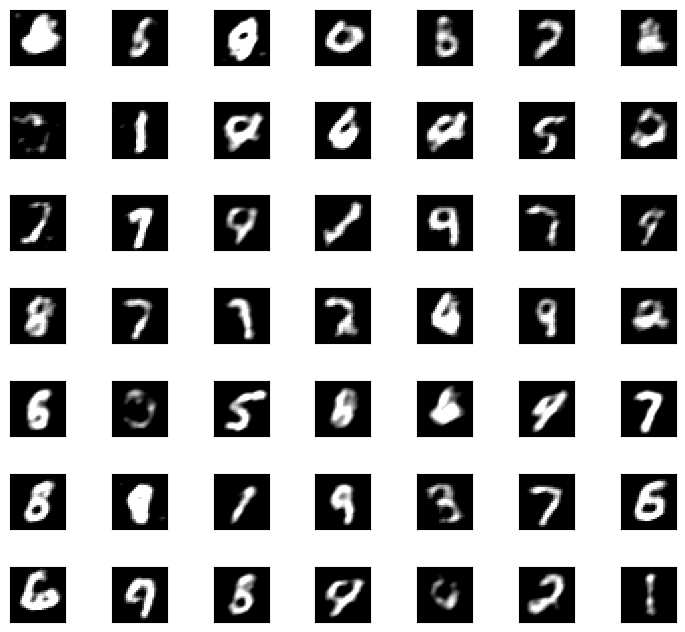

In [ ]:
network.eval()
with torch.no_grad():
  out_shape=(49, latent_shape[1])
  mean_tensor = torch.full(out_shape, mean)
  std_tensor = torch.full(out_shape, torch.sqrt(var))
  sample=torch.normal(mean_tensor, std_tensor)
  generated=decoder(sample.to(device)).to('cpu')

fig = plt.figure()
length=49
begin=0
network.eval()
plt.figure(figsize=(7, 7))
for i in range(length):

  data = generated[i].movedim(0, 2)

  print(data.shape)
  plt.subplot(7,7,i+1)
  plt.tight_layout()
  plt.imshow(data, cmap='gray', vmin=0, vmax=1)
  plt.xticks([])
  plt.yticks([])



Best: 0.049087703227996826


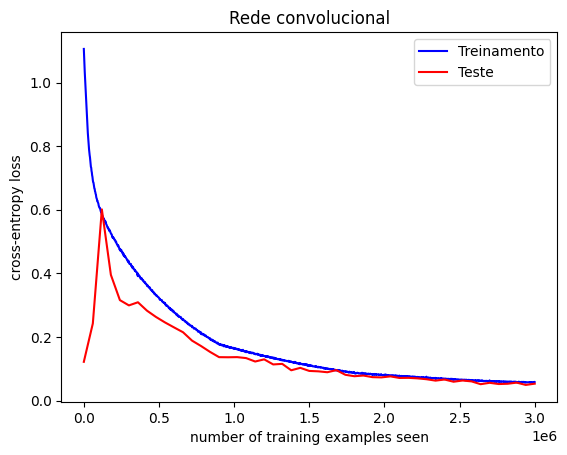

In [ ]:
(train_counter, train_losses, test_losses) = torch.load( training_data_file, map_location=device)
fig = plt.figure()
test_counter = [i*len(train_loader.dataset) for i in range(len(test_losses))]



for i in range(len(test_losses)):
  test_losses[i]=test_losses[i].item()

plt.plot(train_counter, train_losses, color='blue', label='Treinamento')
plt.plot(test_counter, test_losses, color='red', label='Teste')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross-entropy loss')
plt.legend()
plt.title("Rede convolucional")

print(f"Best: {min(test_losses)}")

In [ ]:
gc.collect()
torch.cuda.empty_cache()

## Denoising Autoencoder

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
parameters_file='/content/drive/MyDrive/modelos/AE_MNIST/parameters_noise.pth'
saved_parameters_file='/content/drive/MyDrive/modelos/AE_MNIST/best_parameters_noise.pth'
training_data_file='/content/drive/MyDrive/modelos/AE_MNIST/treinamento_noise.pickle'
batch_size_train = 512
batch_size_test = 512
train_loader = torch.utils.data.DataLoader(
  train_data_noise,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_data_noise,
  batch_size=batch_size_test, shuffle=True)
device

'cpu'

In [ ]:
gc.collect()
torch.cuda.empty_cache()
n_epochs = 30

learning_rate = 1e-3

log_interval=1

network = AutoEncoder(5).to(device)

optimizer = optim.Adam(network.parameters(), lr=learning_rate)
loss_fn=nn.MSELoss(reduction='none', )
scheduler = schd.StepLR(optimizer, 5, 0.5)

train_losses = []
train_counter = []
test_losses = []
test_counter=[]


In [ ]:
count_parameters(network)

16054


Test set: Avg. loss: 0.1637


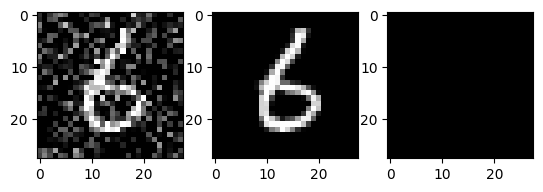

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.104988
Train Epoch: 1 [512/60000 (1%)]	Loss: 1.078436
Train Epoch: 1 [1024/60000 (2%)]	Loss: 1.045991
Train Epoch: 1 [1536/60000 (3%)]	Loss: 1.016638
Train Epoch: 1 [2048/60000 (3%)]	Loss: 0.992924
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.972898
Train Epoch: 1 [3072/60000 (5%)]	Loss: 0.951351
Train Epoch: 1 [3584/60000 (6%)]	Loss: 0.934937
Train Epoch: 1 [4096/60000 (7%)]	Loss: 0.917027
Train Epoch: 1 [4608/60000 (8%)]	Loss: 0.899289
Train Epoch: 1 [5120/60000 (8%)]	Loss: 0.887886
Train Epoch: 1 [5632/60000 (9%)]	Loss: 0.871988
Train Epoch: 1 [6144/60000 (10%)]	Loss: 0.861612
Train Epoch: 1 [6656/60000 (11%)]	Loss: 0.855676
Train Epoch: 1 [7168/60000 (12%)]	Loss: 0.844407
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.833040
Train Epoch: 1 [8192/60000 (14%)]	Loss: 0.827693
Train Epoch: 1 [8704/60000 (14%)]	Loss: 0.819249
Train Epoch: 1 [9216/60000 (15%)]	Loss: 0.810764
Train Epoch: 1 [9728/60000 (16%)]	Loss: 0.804582
Train Epoch: 1 [10240/60000 (17%)]	L

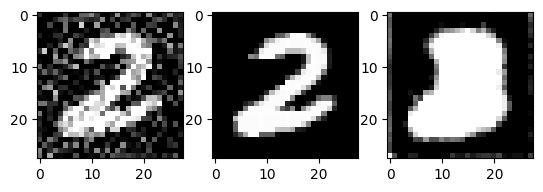

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.528080
Train Epoch: 2 [512/60000 (1%)]	Loss: 0.523566
Train Epoch: 2 [1024/60000 (2%)]	Loss: 0.528426
Train Epoch: 2 [1536/60000 (3%)]	Loss: 0.520460
Train Epoch: 2 [2048/60000 (3%)]	Loss: 0.518889
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.518147
Train Epoch: 2 [3072/60000 (5%)]	Loss: 0.517998
Train Epoch: 2 [3584/60000 (6%)]	Loss: 0.515319
Train Epoch: 2 [4096/60000 (7%)]	Loss: 0.515716
Train Epoch: 2 [4608/60000 (8%)]	Loss: 0.514751
Train Epoch: 2 [5120/60000 (8%)]	Loss: 0.510976
Train Epoch: 2 [5632/60000 (9%)]	Loss: 0.507591
Train Epoch: 2 [6144/60000 (10%)]	Loss: 0.506381
Train Epoch: 2 [6656/60000 (11%)]	Loss: 0.508819
Train Epoch: 2 [7168/60000 (12%)]	Loss: 0.507427
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.507354
Train Epoch: 2 [8192/60000 (14%)]	Loss: 0.505713
Train Epoch: 2 [8704/60000 (14%)]	Loss: 0.501604
Train Epoch: 2 [9216/60000 (15%)]	Loss: 0.499147
Train Epoch: 2 [9728/60000 (16%)]	Loss: 0.495492
Train Epoch: 2 [10240/60000 (17%)]	L

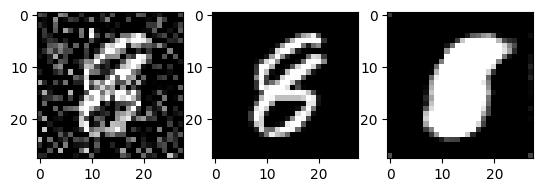

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.377852
Train Epoch: 3 [512/60000 (1%)]	Loss: 0.371813
Train Epoch: 3 [1024/60000 (2%)]	Loss: 0.373644
Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.367329
Train Epoch: 3 [2048/60000 (3%)]	Loss: 0.369481
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.366948
Train Epoch: 3 [3072/60000 (5%)]	Loss: 0.366951
Train Epoch: 3 [3584/60000 (6%)]	Loss: 0.366883
Train Epoch: 3 [4096/60000 (7%)]	Loss: 0.365214
Train Epoch: 3 [4608/60000 (8%)]	Loss: 0.361478
Train Epoch: 3 [5120/60000 (8%)]	Loss: 0.355098
Train Epoch: 3 [5632/60000 (9%)]	Loss: 0.363175
Train Epoch: 3 [6144/60000 (10%)]	Loss: 0.358170
Train Epoch: 3 [6656/60000 (11%)]	Loss: 0.358453
Train Epoch: 3 [7168/60000 (12%)]	Loss: 0.360683
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.359872
Train Epoch: 3 [8192/60000 (14%)]	Loss: 0.354235
Train Epoch: 3 [8704/60000 (14%)]	Loss: 0.357069
Train Epoch: 3 [9216/60000 (15%)]	Loss: 0.355836
Train Epoch: 3 [9728/60000 (16%)]	Loss: 0.350947
Train Epoch: 3 [10240/60000 (17%)]	L

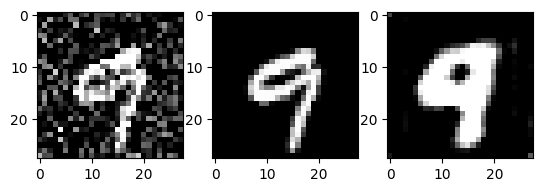

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.266174
Train Epoch: 4 [512/60000 (1%)]	Loss: 0.268275
Train Epoch: 4 [1024/60000 (2%)]	Loss: 0.265063
Train Epoch: 4 [1536/60000 (3%)]	Loss: 0.264824
Train Epoch: 4 [2048/60000 (3%)]	Loss: 0.266177
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.259995
Train Epoch: 4 [3072/60000 (5%)]	Loss: 0.265733
Train Epoch: 4 [3584/60000 (6%)]	Loss: 0.265611
Train Epoch: 4 [4096/60000 (7%)]	Loss: 0.258822
Train Epoch: 4 [4608/60000 (8%)]	Loss: 0.258712
Train Epoch: 4 [5120/60000 (8%)]	Loss: 0.259486
Train Epoch: 4 [5632/60000 (9%)]	Loss: 0.260108
Train Epoch: 4 [6144/60000 (10%)]	Loss: 0.257232
Train Epoch: 4 [6656/60000 (11%)]	Loss: 0.258633
Train Epoch: 4 [7168/60000 (12%)]	Loss: 0.254301
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.257049
Train Epoch: 4 [8192/60000 (14%)]	Loss: 0.258977
Train Epoch: 4 [8704/60000 (14%)]	Loss: 0.252911
Train Epoch: 4 [9216/60000 (15%)]	Loss: 0.252088
Train Epoch: 4 [9728/60000 (16%)]	Loss: 0.249533
Train Epoch: 4 [10240/60000 (17%)]	L

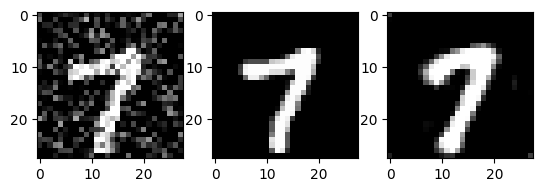

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.190032
Train Epoch: 5 [512/60000 (1%)]	Loss: 0.190167
Train Epoch: 5 [1024/60000 (2%)]	Loss: 0.190058
Train Epoch: 5 [1536/60000 (3%)]	Loss: 0.187113
Train Epoch: 5 [2048/60000 (3%)]	Loss: 0.186904
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.187099
Train Epoch: 5 [3072/60000 (5%)]	Loss: 0.181982
Train Epoch: 5 [3584/60000 (6%)]	Loss: 0.186271
Train Epoch: 5 [4096/60000 (7%)]	Loss: 0.186507
Train Epoch: 5 [4608/60000 (8%)]	Loss: 0.184977
Train Epoch: 5 [5120/60000 (8%)]	Loss: 0.183861
Train Epoch: 5 [5632/60000 (9%)]	Loss: 0.181437
Train Epoch: 5 [6144/60000 (10%)]	Loss: 0.180400
Train Epoch: 5 [6656/60000 (11%)]	Loss: 0.184235
Train Epoch: 5 [7168/60000 (12%)]	Loss: 0.181588
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.177946
Train Epoch: 5 [8192/60000 (14%)]	Loss: 0.180515
Train Epoch: 5 [8704/60000 (14%)]	Loss: 0.180804
Train Epoch: 5 [9216/60000 (15%)]	Loss: 0.178107
Train Epoch: 5 [9728/60000 (16%)]	Loss: 0.176351
Train Epoch: 5 [10240/60000 (17%)]	L

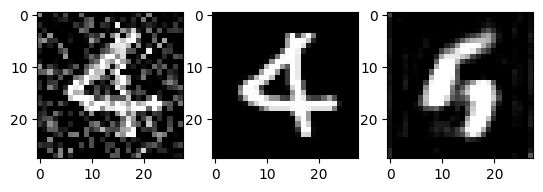

New best! Saving...
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.130093
Train Epoch: 6 [512/60000 (1%)]	Loss: 0.131761
Train Epoch: 6 [1024/60000 (2%)]	Loss: 0.130405
Train Epoch: 6 [1536/60000 (3%)]	Loss: 0.130123
Train Epoch: 6 [2048/60000 (3%)]	Loss: 0.129758
Train Epoch: 6 [2560/60000 (4%)]	Loss: 0.129970
Train Epoch: 6 [3072/60000 (5%)]	Loss: 0.130555
Train Epoch: 6 [3584/60000 (6%)]	Loss: 0.129121
Train Epoch: 6 [4096/60000 (7%)]	Loss: 0.129944
Train Epoch: 6 [4608/60000 (8%)]	Loss: 0.130322
Train Epoch: 6 [5120/60000 (8%)]	Loss: 0.125875
Train Epoch: 6 [5632/60000 (9%)]	Loss: 0.128164
Train Epoch: 6 [6144/60000 (10%)]	Loss: 0.129302
Train Epoch: 6 [6656/60000 (11%)]	Loss: 0.126383
Train Epoch: 6 [7168/60000 (12%)]	Loss: 0.128051
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.126662
Train Epoch: 6 [8192/60000 (14%)]	Loss: 0.129235
Train Epoch: 6 [8704/60000 (14%)]	Loss: 0.125863
Train Epoch: 6 [9216/60000 (15%)]	Loss: 0.127517
Train Epoch: 6 [9728/60000 (16%)]	Loss: 0.124640
Train Epoch: 6 [

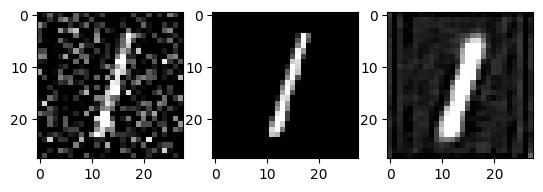

New best! Saving...
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.104424
Train Epoch: 7 [512/60000 (1%)]	Loss: 0.104170
Train Epoch: 7 [1024/60000 (2%)]	Loss: 0.102824
Train Epoch: 7 [1536/60000 (3%)]	Loss: 0.101897
Train Epoch: 7 [2048/60000 (3%)]	Loss: 0.102189
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.103098
Train Epoch: 7 [3072/60000 (5%)]	Loss: 0.102073
Train Epoch: 7 [3584/60000 (6%)]	Loss: 0.101324
Train Epoch: 7 [4096/60000 (7%)]	Loss: 0.099207
Train Epoch: 7 [4608/60000 (8%)]	Loss: 0.096287
Train Epoch: 7 [5120/60000 (8%)]	Loss: 0.098255
Train Epoch: 7 [5632/60000 (9%)]	Loss: 0.097322
Train Epoch: 7 [6144/60000 (10%)]	Loss: 0.093645
Train Epoch: 7 [6656/60000 (11%)]	Loss: 0.094302
Train Epoch: 7 [7168/60000 (12%)]	Loss: 0.095517
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.092368
Train Epoch: 7 [8192/60000 (14%)]	Loss: 0.092462
Train Epoch: 7 [8704/60000 (14%)]	Loss: 0.090102
Train Epoch: 7 [9216/60000 (15%)]	Loss: 0.091175
Train Epoch: 7 [9728/60000 (16%)]	Loss: 0.088243
Train Epoch: 7 [

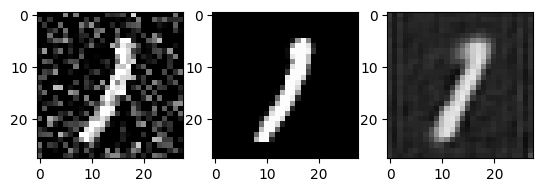

New best! Saving...
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.037797
Train Epoch: 8 [512/60000 (1%)]	Loss: 0.037199
Train Epoch: 8 [1024/60000 (2%)]	Loss: 0.037576
Train Epoch: 8 [1536/60000 (3%)]	Loss: 0.037517
Train Epoch: 8 [2048/60000 (3%)]	Loss: 0.037970
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.037326
Train Epoch: 8 [3072/60000 (5%)]	Loss: 0.037696
Train Epoch: 8 [3584/60000 (6%)]	Loss: 0.038053
Train Epoch: 8 [4096/60000 (7%)]	Loss: 0.037504
Train Epoch: 8 [4608/60000 (8%)]	Loss: 0.037119
Train Epoch: 8 [5120/60000 (8%)]	Loss: 0.036911
Train Epoch: 8 [5632/60000 (9%)]	Loss: 0.036741
Train Epoch: 8 [6144/60000 (10%)]	Loss: 0.037518
Train Epoch: 8 [6656/60000 (11%)]	Loss: 0.036741
Train Epoch: 8 [7168/60000 (12%)]	Loss: 0.037740
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.036082
Train Epoch: 8 [8192/60000 (14%)]	Loss: 0.035735
Train Epoch: 8 [8704/60000 (14%)]	Loss: 0.037693
Train Epoch: 8 [9216/60000 (15%)]	Loss: 0.035776
Train Epoch: 8 [9728/60000 (16%)]	Loss: 0.037237
Train Epoch: 8 [

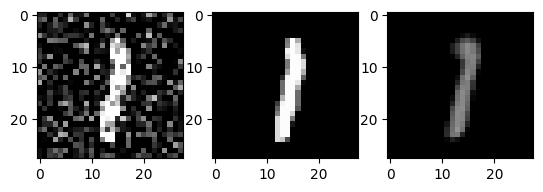

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.035421
Train Epoch: 9 [512/60000 (1%)]	Loss: 0.037365
Train Epoch: 9 [1024/60000 (2%)]	Loss: 0.036356
Train Epoch: 9 [1536/60000 (3%)]	Loss: 0.036500
Train Epoch: 9 [2048/60000 (3%)]	Loss: 0.036201
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.036119
Train Epoch: 9 [3072/60000 (5%)]	Loss: 0.036448
Train Epoch: 9 [3584/60000 (6%)]	Loss: 0.036371
Train Epoch: 9 [4096/60000 (7%)]	Loss: 0.036050
Train Epoch: 9 [4608/60000 (8%)]	Loss: 0.036770
Train Epoch: 9 [5120/60000 (8%)]	Loss: 0.036748
Train Epoch: 9 [5632/60000 (9%)]	Loss: 0.035202
Train Epoch: 9 [6144/60000 (10%)]	Loss: 0.035761
Train Epoch: 9 [6656/60000 (11%)]	Loss: 0.035028
Train Epoch: 9 [7168/60000 (12%)]	Loss: 0.036050
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.036907
Train Epoch: 9 [8192/60000 (14%)]	Loss: 0.035556
Train Epoch: 9 [8704/60000 (14%)]	Loss: 0.035320
Train Epoch: 9 [9216/60000 (15%)]	Loss: 0.036600
Train Epoch: 9 [9728/60000 (16%)]	Loss: 0.035700
Train Epoch: 9 [10240/60000 (17%)]	L

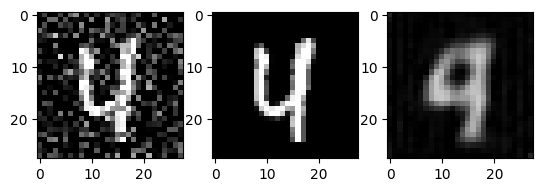

New best! Saving...
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.035421
Train Epoch: 10 [512/60000 (1%)]	Loss: 0.035706
Train Epoch: 10 [1024/60000 (2%)]	Loss: 0.034835
Train Epoch: 10 [1536/60000 (3%)]	Loss: 0.034771
Train Epoch: 10 [2048/60000 (3%)]	Loss: 0.034977
Train Epoch: 10 [2560/60000 (4%)]	Loss: 0.035513
Train Epoch: 10 [3072/60000 (5%)]	Loss: 0.036481
Train Epoch: 10 [3584/60000 (6%)]	Loss: 0.036832
Train Epoch: 10 [4096/60000 (7%)]	Loss: 0.034928
Train Epoch: 10 [4608/60000 (8%)]	Loss: 0.035351
Train Epoch: 10 [5120/60000 (8%)]	Loss: 0.035781
Train Epoch: 10 [5632/60000 (9%)]	Loss: 0.034502
Train Epoch: 10 [6144/60000 (10%)]	Loss: 0.035520
Train Epoch: 10 [6656/60000 (11%)]	Loss: 0.034922
Train Epoch: 10 [7168/60000 (12%)]	Loss: 0.034758
Train Epoch: 10 [7680/60000 (13%)]	Loss: 0.035430
Train Epoch: 10 [8192/60000 (14%)]	Loss: 0.034861
Train Epoch: 10 [8704/60000 (14%)]	Loss: 0.037778
Train Epoch: 10 [9216/60000 (15%)]	Loss: 0.035710
Train Epoch: 10 [9728/60000 (16%)]	Loss: 0.034

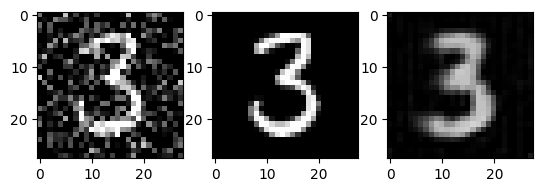

New best! Saving...
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.034238
Train Epoch: 11 [512/60000 (1%)]	Loss: 0.036404
Train Epoch: 11 [1024/60000 (2%)]	Loss: 0.034258
Train Epoch: 11 [1536/60000 (3%)]	Loss: 0.034964
Train Epoch: 11 [2048/60000 (3%)]	Loss: 0.033724
Train Epoch: 11 [2560/60000 (4%)]	Loss: 0.035118
Train Epoch: 11 [3072/60000 (5%)]	Loss: 0.035704
Train Epoch: 11 [3584/60000 (6%)]	Loss: 0.034906
Train Epoch: 11 [4096/60000 (7%)]	Loss: 0.034353
Train Epoch: 11 [4608/60000 (8%)]	Loss: 0.035015
Train Epoch: 11 [5120/60000 (8%)]	Loss: 0.034778
Train Epoch: 11 [5632/60000 (9%)]	Loss: 0.034594
Train Epoch: 11 [6144/60000 (10%)]	Loss: 0.035315
Train Epoch: 11 [6656/60000 (11%)]	Loss: 0.034845
Train Epoch: 11 [7168/60000 (12%)]	Loss: 0.034883
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.035153
Train Epoch: 11 [8192/60000 (14%)]	Loss: 0.036057
Train Epoch: 11 [8704/60000 (14%)]	Loss: 0.034586
Train Epoch: 11 [9216/60000 (15%)]	Loss: 0.035158
Train Epoch: 11 [9728/60000 (16%)]	Loss: 0.034

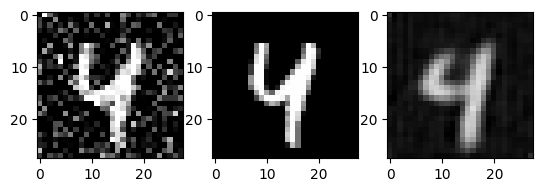

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.034659
Train Epoch: 12 [512/60000 (1%)]	Loss: 0.035477
Train Epoch: 12 [1024/60000 (2%)]	Loss: 0.034797
Train Epoch: 12 [1536/60000 (3%)]	Loss: 0.033620
Train Epoch: 12 [2048/60000 (3%)]	Loss: 0.034739
Train Epoch: 12 [2560/60000 (4%)]	Loss: 0.034138
Train Epoch: 12 [3072/60000 (5%)]	Loss: 0.033603
Train Epoch: 12 [3584/60000 (6%)]	Loss: 0.034884
Train Epoch: 12 [4096/60000 (7%)]	Loss: 0.033655
Train Epoch: 12 [4608/60000 (8%)]	Loss: 0.034189
Train Epoch: 12 [5120/60000 (8%)]	Loss: 0.034801
Train Epoch: 12 [5632/60000 (9%)]	Loss: 0.034666
Train Epoch: 12 [6144/60000 (10%)]	Loss: 0.033862
Train Epoch: 12 [6656/60000 (11%)]	Loss: 0.034558
Train Epoch: 12 [7168/60000 (12%)]	Loss: 0.034209
Train Epoch: 12 [7680/60000 (13%)]	Loss: 0.033182
Train Epoch: 12 [8192/60000 (14%)]	Loss: 0.034277
Train Epoch: 12 [8704/60000 (14%)]	Loss: 0.034696
Train Epoch: 12 [9216/60000 (15%)]	Loss: 0.034037
Train Epoch: 12 [9728/60000 (16%)]	Loss: 0.036241
Train Epoch: 12 

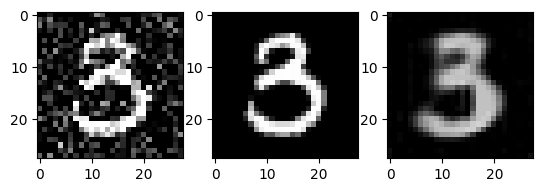

New best! Saving...
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.035341
Train Epoch: 13 [512/60000 (1%)]	Loss: 0.034806
Train Epoch: 13 [1024/60000 (2%)]	Loss: 0.035438
Train Epoch: 13 [1536/60000 (3%)]	Loss: 0.034257
Train Epoch: 13 [2048/60000 (3%)]	Loss: 0.033656
Train Epoch: 13 [2560/60000 (4%)]	Loss: 0.033235
Train Epoch: 13 [3072/60000 (5%)]	Loss: 0.034913
Train Epoch: 13 [3584/60000 (6%)]	Loss: 0.033949
Train Epoch: 13 [4096/60000 (7%)]	Loss: 0.035398
Train Epoch: 13 [4608/60000 (8%)]	Loss: 0.034666
Train Epoch: 13 [5120/60000 (8%)]	Loss: 0.033652
Train Epoch: 13 [5632/60000 (9%)]	Loss: 0.034443
Train Epoch: 13 [6144/60000 (10%)]	Loss: 0.033702
Train Epoch: 13 [6656/60000 (11%)]	Loss: 0.033343
Train Epoch: 13 [7168/60000 (12%)]	Loss: 0.034000
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.033635
Train Epoch: 13 [8192/60000 (14%)]	Loss: 0.034111
Train Epoch: 13 [8704/60000 (14%)]	Loss: 0.034314
Train Epoch: 13 [9216/60000 (15%)]	Loss: 0.034076
Train Epoch: 13 [9728/60000 (16%)]	Loss: 0.033

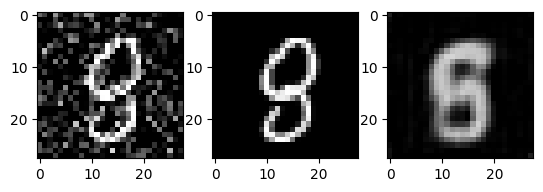

New best! Saving...
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.034690
Train Epoch: 14 [512/60000 (1%)]	Loss: 0.033686
Train Epoch: 14 [1024/60000 (2%)]	Loss: 0.034715
Train Epoch: 14 [1536/60000 (3%)]	Loss: 0.033328
Train Epoch: 14 [2048/60000 (3%)]	Loss: 0.034775
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.034563
Train Epoch: 14 [3072/60000 (5%)]	Loss: 0.033641
Train Epoch: 14 [3584/60000 (6%)]	Loss: 0.034362
Train Epoch: 14 [4096/60000 (7%)]	Loss: 0.033237
Train Epoch: 14 [4608/60000 (8%)]	Loss: 0.033630
Train Epoch: 14 [5120/60000 (8%)]	Loss: 0.035976
Train Epoch: 14 [5632/60000 (9%)]	Loss: 0.032706
Train Epoch: 14 [6144/60000 (10%)]	Loss: 0.033304
Train Epoch: 14 [6656/60000 (11%)]	Loss: 0.033699
Train Epoch: 14 [7168/60000 (12%)]	Loss: 0.033460
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.034277
Train Epoch: 14 [8192/60000 (14%)]	Loss: 0.033725
Train Epoch: 14 [8704/60000 (14%)]	Loss: 0.033483
Train Epoch: 14 [9216/60000 (15%)]	Loss: 0.033383
Train Epoch: 14 [9728/60000 (16%)]	Loss: 0.033

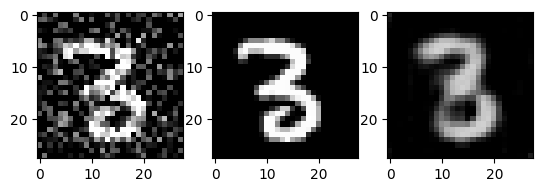

New best! Saving...
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.034115
Train Epoch: 15 [512/60000 (1%)]	Loss: 0.034414
Train Epoch: 15 [1024/60000 (2%)]	Loss: 0.032863
Train Epoch: 15 [1536/60000 (3%)]	Loss: 0.034549
Train Epoch: 15 [2048/60000 (3%)]	Loss: 0.032936
Train Epoch: 15 [2560/60000 (4%)]	Loss: 0.032411
Train Epoch: 15 [3072/60000 (5%)]	Loss: 0.033132
Train Epoch: 15 [3584/60000 (6%)]	Loss: 0.032825
Train Epoch: 15 [4096/60000 (7%)]	Loss: 0.033180
Train Epoch: 15 [4608/60000 (8%)]	Loss: 0.032514
Train Epoch: 15 [5120/60000 (8%)]	Loss: 0.032169
Train Epoch: 15 [5632/60000 (9%)]	Loss: 0.034516
Train Epoch: 15 [6144/60000 (10%)]	Loss: 0.033274
Train Epoch: 15 [6656/60000 (11%)]	Loss: 0.033438
Train Epoch: 15 [7168/60000 (12%)]	Loss: 0.033264
Train Epoch: 15 [7680/60000 (13%)]	Loss: 0.033256
Train Epoch: 15 [8192/60000 (14%)]	Loss: 0.033911
Train Epoch: 15 [8704/60000 (14%)]	Loss: 0.033316
Train Epoch: 15 [9216/60000 (15%)]	Loss: 0.034138
Train Epoch: 15 [9728/60000 (16%)]	Loss: 0.034

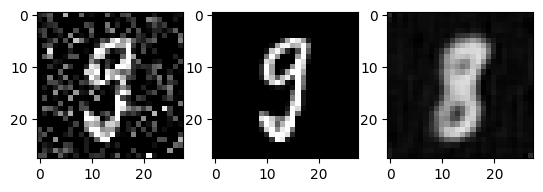

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.033511
Train Epoch: 16 [512/60000 (1%)]	Loss: 0.033965
Train Epoch: 16 [1024/60000 (2%)]	Loss: 0.032523
Train Epoch: 16 [1536/60000 (3%)]	Loss: 0.032982
Train Epoch: 16 [2048/60000 (3%)]	Loss: 0.032290
Train Epoch: 16 [2560/60000 (4%)]	Loss: 0.032852
Train Epoch: 16 [3072/60000 (5%)]	Loss: 0.033336
Train Epoch: 16 [3584/60000 (6%)]	Loss: 0.032781
Train Epoch: 16 [4096/60000 (7%)]	Loss: 0.032196
Train Epoch: 16 [4608/60000 (8%)]	Loss: 0.033492
Train Epoch: 16 [5120/60000 (8%)]	Loss: 0.031960
Train Epoch: 16 [5632/60000 (9%)]	Loss: 0.032939
Train Epoch: 16 [6144/60000 (10%)]	Loss: 0.032215
Train Epoch: 16 [6656/60000 (11%)]	Loss: 0.033400
Train Epoch: 16 [7168/60000 (12%)]	Loss: 0.033289
Train Epoch: 16 [7680/60000 (13%)]	Loss: 0.032220
Train Epoch: 16 [8192/60000 (14%)]	Loss: 0.034048
Train Epoch: 16 [8704/60000 (14%)]	Loss: 0.031814
Train Epoch: 16 [9216/60000 (15%)]	Loss: 0.032961
Train Epoch: 16 [9728/60000 (16%)]	Loss: 0.032011
Train Epoch: 16 

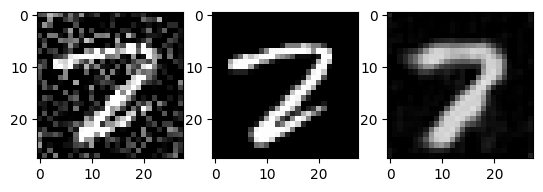

New best! Saving...
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.032785
Train Epoch: 17 [512/60000 (1%)]	Loss: 0.032832
Train Epoch: 17 [1024/60000 (2%)]	Loss: 0.032565
Train Epoch: 17 [1536/60000 (3%)]	Loss: 0.032788
Train Epoch: 17 [2048/60000 (3%)]	Loss: 0.032710
Train Epoch: 17 [2560/60000 (4%)]	Loss: 0.033098
Train Epoch: 17 [3072/60000 (5%)]	Loss: 0.030936
Train Epoch: 17 [3584/60000 (6%)]	Loss: 0.031762
Train Epoch: 17 [4096/60000 (7%)]	Loss: 0.032324
Train Epoch: 17 [4608/60000 (8%)]	Loss: 0.032764
Train Epoch: 17 [5120/60000 (8%)]	Loss: 0.032971
Train Epoch: 17 [5632/60000 (9%)]	Loss: 0.031999
Train Epoch: 17 [6144/60000 (10%)]	Loss: 0.032727
Train Epoch: 17 [6656/60000 (11%)]	Loss: 0.032428
Train Epoch: 17 [7168/60000 (12%)]	Loss: 0.032305
Train Epoch: 17 [7680/60000 (13%)]	Loss: 0.032339
Train Epoch: 17 [8192/60000 (14%)]	Loss: 0.032483
Train Epoch: 17 [8704/60000 (14%)]	Loss: 0.033380
Train Epoch: 17 [9216/60000 (15%)]	Loss: 0.032184
Train Epoch: 17 [9728/60000 (16%)]	Loss: 0.032

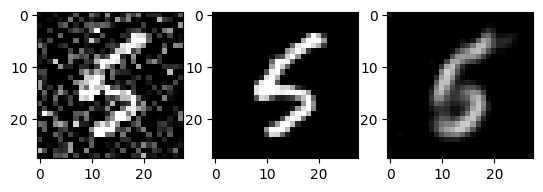

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.031307
Train Epoch: 18 [512/60000 (1%)]	Loss: 0.032854
Train Epoch: 18 [1024/60000 (2%)]	Loss: 0.031734
Train Epoch: 18 [1536/60000 (3%)]	Loss: 0.031156
Train Epoch: 18 [2048/60000 (3%)]	Loss: 0.032475
Train Epoch: 18 [2560/60000 (4%)]	Loss: 0.032954
Train Epoch: 18 [3072/60000 (5%)]	Loss: 0.034194
Train Epoch: 18 [3584/60000 (6%)]	Loss: 0.032158
Train Epoch: 18 [4096/60000 (7%)]	Loss: 0.032562
Train Epoch: 18 [4608/60000 (8%)]	Loss: 0.032580
Train Epoch: 18 [5120/60000 (8%)]	Loss: 0.032238
Train Epoch: 18 [5632/60000 (9%)]	Loss: 0.032678
Train Epoch: 18 [6144/60000 (10%)]	Loss: 0.031626
Train Epoch: 18 [6656/60000 (11%)]	Loss: 0.032982
Train Epoch: 18 [7168/60000 (12%)]	Loss: 0.032543
Train Epoch: 18 [7680/60000 (13%)]	Loss: 0.033367
Train Epoch: 18 [8192/60000 (14%)]	Loss: 0.032483
Train Epoch: 18 [8704/60000 (14%)]	Loss: 0.033494
Train Epoch: 18 [9216/60000 (15%)]	Loss: 0.032631
Train Epoch: 18 [9728/60000 (16%)]	Loss: 0.031982
Train Epoch: 18 

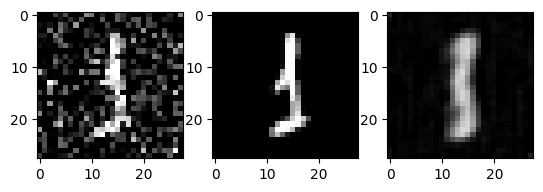

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.031608
Train Epoch: 19 [512/60000 (1%)]	Loss: 0.032738
Train Epoch: 19 [1024/60000 (2%)]	Loss: 0.031218
Train Epoch: 19 [1536/60000 (3%)]	Loss: 0.031375
Train Epoch: 19 [2048/60000 (3%)]	Loss: 0.032007
Train Epoch: 19 [2560/60000 (4%)]	Loss: 0.032818
Train Epoch: 19 [3072/60000 (5%)]	Loss: 0.030699
Train Epoch: 19 [3584/60000 (6%)]	Loss: 0.032164
Train Epoch: 19 [4096/60000 (7%)]	Loss: 0.032146
Train Epoch: 19 [4608/60000 (8%)]	Loss: 0.033405
Train Epoch: 19 [5120/60000 (8%)]	Loss: 0.032203
Train Epoch: 19 [5632/60000 (9%)]	Loss: 0.032832
Train Epoch: 19 [6144/60000 (10%)]	Loss: 0.032060
Train Epoch: 19 [6656/60000 (11%)]	Loss: 0.031957
Train Epoch: 19 [7168/60000 (12%)]	Loss: 0.032813
Train Epoch: 19 [7680/60000 (13%)]	Loss: 0.032648
Train Epoch: 19 [8192/60000 (14%)]	Loss: 0.031717
Train Epoch: 19 [8704/60000 (14%)]	Loss: 0.031481
Train Epoch: 19 [9216/60000 (15%)]	Loss: 0.032080
Train Epoch: 19 [9728/60000 (16%)]	Loss: 0.032142
Train Epoch: 19 

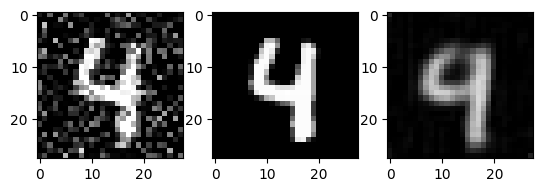

New best! Saving...
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.032489
Train Epoch: 20 [512/60000 (1%)]	Loss: 0.032102
Train Epoch: 20 [1024/60000 (2%)]	Loss: 0.031694
Train Epoch: 20 [1536/60000 (3%)]	Loss: 0.032222
Train Epoch: 20 [2048/60000 (3%)]	Loss: 0.032941
Train Epoch: 20 [2560/60000 (4%)]	Loss: 0.032742
Train Epoch: 20 [3072/60000 (5%)]	Loss: 0.032771
Train Epoch: 20 [3584/60000 (6%)]	Loss: 0.030754
Train Epoch: 20 [4096/60000 (7%)]	Loss: 0.032856
Train Epoch: 20 [4608/60000 (8%)]	Loss: 0.032732
Train Epoch: 20 [5120/60000 (8%)]	Loss: 0.031757
Train Epoch: 20 [5632/60000 (9%)]	Loss: 0.033140
Train Epoch: 20 [6144/60000 (10%)]	Loss: 0.032175
Train Epoch: 20 [6656/60000 (11%)]	Loss: 0.031746
Train Epoch: 20 [7168/60000 (12%)]	Loss: 0.032855
Train Epoch: 20 [7680/60000 (13%)]	Loss: 0.032086
Train Epoch: 20 [8192/60000 (14%)]	Loss: 0.033447
Train Epoch: 20 [8704/60000 (14%)]	Loss: 0.031722
Train Epoch: 20 [9216/60000 (15%)]	Loss: 0.032832
Train Epoch: 20 [9728/60000 (16%)]	Loss: 0.032

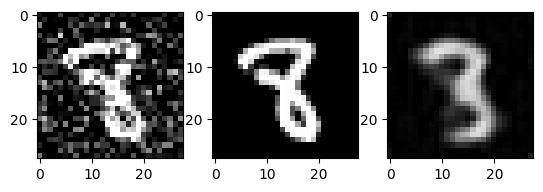

Train Epoch: 21 [0/60000 (0%)]	Loss: 0.032197
Train Epoch: 21 [512/60000 (1%)]	Loss: 0.031964
Train Epoch: 21 [1024/60000 (2%)]	Loss: 0.033000
Train Epoch: 21 [1536/60000 (3%)]	Loss: 0.032248
Train Epoch: 21 [2048/60000 (3%)]	Loss: 0.032143
Train Epoch: 21 [2560/60000 (4%)]	Loss: 0.031854
Train Epoch: 21 [3072/60000 (5%)]	Loss: 0.031899
Train Epoch: 21 [3584/60000 (6%)]	Loss: 0.031141
Train Epoch: 21 [4096/60000 (7%)]	Loss: 0.031688
Train Epoch: 21 [4608/60000 (8%)]	Loss: 0.032022
Train Epoch: 21 [5120/60000 (8%)]	Loss: 0.031762
Train Epoch: 21 [5632/60000 (9%)]	Loss: 0.033055
Train Epoch: 21 [6144/60000 (10%)]	Loss: 0.032563
Train Epoch: 21 [6656/60000 (11%)]	Loss: 0.031153
Train Epoch: 21 [7168/60000 (12%)]	Loss: 0.032209
Train Epoch: 21 [7680/60000 (13%)]	Loss: 0.031635
Train Epoch: 21 [8192/60000 (14%)]	Loss: 0.032083
Train Epoch: 21 [8704/60000 (14%)]	Loss: 0.032460
Train Epoch: 21 [9216/60000 (15%)]	Loss: 0.031779
Train Epoch: 21 [9728/60000 (16%)]	Loss: 0.032371
Train Epoch: 21 

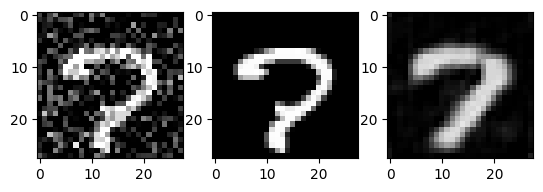

New best! Saving...
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.031173
Train Epoch: 22 [512/60000 (1%)]	Loss: 0.032098
Train Epoch: 22 [1024/60000 (2%)]	Loss: 0.031205
Train Epoch: 22 [1536/60000 (3%)]	Loss: 0.031966
Train Epoch: 22 [2048/60000 (3%)]	Loss: 0.031920
Train Epoch: 22 [2560/60000 (4%)]	Loss: 0.031238
Train Epoch: 22 [3072/60000 (5%)]	Loss: 0.031225
Train Epoch: 22 [3584/60000 (6%)]	Loss: 0.031656
Train Epoch: 22 [4096/60000 (7%)]	Loss: 0.031176
Train Epoch: 22 [4608/60000 (8%)]	Loss: 0.031889
Train Epoch: 22 [5120/60000 (8%)]	Loss: 0.031047
Train Epoch: 22 [5632/60000 (9%)]	Loss: 0.030981
Train Epoch: 22 [6144/60000 (10%)]	Loss: 0.032373
Train Epoch: 22 [6656/60000 (11%)]	Loss: 0.032201
Train Epoch: 22 [7168/60000 (12%)]	Loss: 0.032876
Train Epoch: 22 [7680/60000 (13%)]	Loss: 0.032406
Train Epoch: 22 [8192/60000 (14%)]	Loss: 0.033464
Train Epoch: 22 [8704/60000 (14%)]	Loss: 0.033292
Train Epoch: 22 [9216/60000 (15%)]	Loss: 0.032089
Train Epoch: 22 [9728/60000 (16%)]	Loss: 0.032

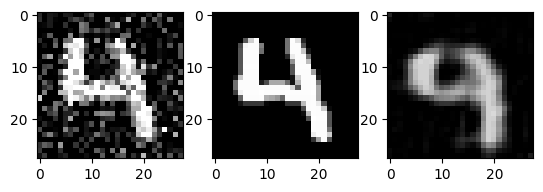

New best! Saving...
Train Epoch: 23 [0/60000 (0%)]	Loss: 0.032574
Train Epoch: 23 [512/60000 (1%)]	Loss: 0.032503
Train Epoch: 23 [1024/60000 (2%)]	Loss: 0.031622
Train Epoch: 23 [1536/60000 (3%)]	Loss: 0.031041
Train Epoch: 23 [2048/60000 (3%)]	Loss: 0.031117
Train Epoch: 23 [2560/60000 (4%)]	Loss: 0.030968
Train Epoch: 23 [3072/60000 (5%)]	Loss: 0.031859
Train Epoch: 23 [3584/60000 (6%)]	Loss: 0.031572
Train Epoch: 23 [4096/60000 (7%)]	Loss: 0.030781
Train Epoch: 23 [4608/60000 (8%)]	Loss: 0.031538
Train Epoch: 23 [5120/60000 (8%)]	Loss: 0.031710
Train Epoch: 23 [5632/60000 (9%)]	Loss: 0.031380
Train Epoch: 23 [6144/60000 (10%)]	Loss: 0.031727
Train Epoch: 23 [6656/60000 (11%)]	Loss: 0.031754
Train Epoch: 23 [7168/60000 (12%)]	Loss: 0.031270
Train Epoch: 23 [7680/60000 (13%)]	Loss: 0.031066
Train Epoch: 23 [8192/60000 (14%)]	Loss: 0.030650
Train Epoch: 23 [8704/60000 (14%)]	Loss: 0.030040
Train Epoch: 23 [9216/60000 (15%)]	Loss: 0.031216
Train Epoch: 23 [9728/60000 (16%)]	Loss: 0.031

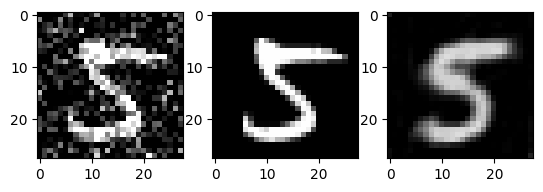

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.031517
Train Epoch: 24 [512/60000 (1%)]	Loss: 0.031117
Train Epoch: 24 [1024/60000 (2%)]	Loss: 0.032314
Train Epoch: 24 [1536/60000 (3%)]	Loss: 0.030792
Train Epoch: 24 [2048/60000 (3%)]	Loss: 0.030678
Train Epoch: 24 [2560/60000 (4%)]	Loss: 0.031492
Train Epoch: 24 [3072/60000 (5%)]	Loss: 0.031748
Train Epoch: 24 [3584/60000 (6%)]	Loss: 0.030950
Train Epoch: 24 [4096/60000 (7%)]	Loss: 0.031912
Train Epoch: 24 [4608/60000 (8%)]	Loss: 0.032067
Train Epoch: 24 [5120/60000 (8%)]	Loss: 0.032189
Train Epoch: 24 [5632/60000 (9%)]	Loss: 0.031444
Train Epoch: 24 [6144/60000 (10%)]	Loss: 0.031811
Train Epoch: 24 [6656/60000 (11%)]	Loss: 0.031725
Train Epoch: 24 [7168/60000 (12%)]	Loss: 0.032581
Train Epoch: 24 [7680/60000 (13%)]	Loss: 0.031191
Train Epoch: 24 [8192/60000 (14%)]	Loss: 0.031251
Train Epoch: 24 [8704/60000 (14%)]	Loss: 0.030771
Train Epoch: 24 [9216/60000 (15%)]	Loss: 0.032127
Train Epoch: 24 [9728/60000 (16%)]	Loss: 0.031847
Train Epoch: 24 

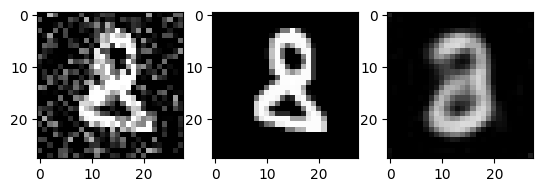

New best! Saving...
Train Epoch: 25 [0/60000 (0%)]	Loss: 0.032255
Train Epoch: 25 [512/60000 (1%)]	Loss: 0.032240
Train Epoch: 25 [1024/60000 (2%)]	Loss: 0.031500
Train Epoch: 25 [1536/60000 (3%)]	Loss: 0.031671
Train Epoch: 25 [2048/60000 (3%)]	Loss: 0.032034
Train Epoch: 25 [2560/60000 (4%)]	Loss: 0.032114
Train Epoch: 25 [3072/60000 (5%)]	Loss: 0.031490
Train Epoch: 25 [3584/60000 (6%)]	Loss: 0.032200
Train Epoch: 25 [4096/60000 (7%)]	Loss: 0.031609
Train Epoch: 25 [4608/60000 (8%)]	Loss: 0.032742
Train Epoch: 25 [5120/60000 (8%)]	Loss: 0.031283
Train Epoch: 25 [5632/60000 (9%)]	Loss: 0.030199
Train Epoch: 25 [6144/60000 (10%)]	Loss: 0.032917
Train Epoch: 25 [6656/60000 (11%)]	Loss: 0.031990
Train Epoch: 25 [7168/60000 (12%)]	Loss: 0.032227
Train Epoch: 25 [7680/60000 (13%)]	Loss: 0.031831
Train Epoch: 25 [8192/60000 (14%)]	Loss: 0.031227
Train Epoch: 25 [8704/60000 (14%)]	Loss: 0.031386
Train Epoch: 25 [9216/60000 (15%)]	Loss: 0.031839
Train Epoch: 25 [9728/60000 (16%)]	Loss: 0.032

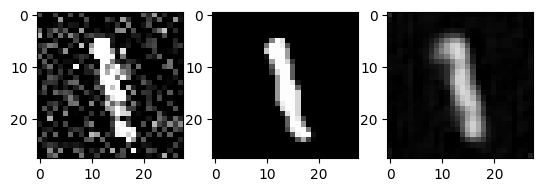

Train Epoch: 26 [0/60000 (0%)]	Loss: 0.032118
Train Epoch: 26 [512/60000 (1%)]	Loss: 0.031495
Train Epoch: 26 [1024/60000 (2%)]	Loss: 0.031812
Train Epoch: 26 [1536/60000 (3%)]	Loss: 0.031414
Train Epoch: 26 [2048/60000 (3%)]	Loss: 0.031977
Train Epoch: 26 [2560/60000 (4%)]	Loss: 0.031859
Train Epoch: 26 [3072/60000 (5%)]	Loss: 0.031364
Train Epoch: 26 [3584/60000 (6%)]	Loss: 0.031679
Train Epoch: 26 [4096/60000 (7%)]	Loss: 0.031660
Train Epoch: 26 [4608/60000 (8%)]	Loss: 0.030945
Train Epoch: 26 [5120/60000 (8%)]	Loss: 0.031877
Train Epoch: 26 [5632/60000 (9%)]	Loss: 0.030883
Train Epoch: 26 [6144/60000 (10%)]	Loss: 0.032308
Train Epoch: 26 [6656/60000 (11%)]	Loss: 0.031350
Train Epoch: 26 [7168/60000 (12%)]	Loss: 0.032920
Train Epoch: 26 [7680/60000 (13%)]	Loss: 0.031212
Train Epoch: 26 [8192/60000 (14%)]	Loss: 0.031751
Train Epoch: 26 [8704/60000 (14%)]	Loss: 0.032081
Train Epoch: 26 [9216/60000 (15%)]	Loss: 0.031988
Train Epoch: 26 [9728/60000 (16%)]	Loss: 0.031911
Train Epoch: 26 

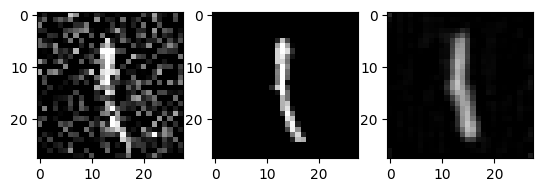

New best! Saving...
Train Epoch: 27 [0/60000 (0%)]	Loss: 0.031453
Train Epoch: 27 [512/60000 (1%)]	Loss: 0.032008
Train Epoch: 27 [1024/60000 (2%)]	Loss: 0.031638
Train Epoch: 27 [1536/60000 (3%)]	Loss: 0.032490
Train Epoch: 27 [2048/60000 (3%)]	Loss: 0.030851
Train Epoch: 27 [2560/60000 (4%)]	Loss: 0.031355
Train Epoch: 27 [3072/60000 (5%)]	Loss: 0.031091
Train Epoch: 27 [3584/60000 (6%)]	Loss: 0.032043
Train Epoch: 27 [4096/60000 (7%)]	Loss: 0.031735
Train Epoch: 27 [4608/60000 (8%)]	Loss: 0.030849
Train Epoch: 27 [5120/60000 (8%)]	Loss: 0.030597
Train Epoch: 27 [5632/60000 (9%)]	Loss: 0.032087
Train Epoch: 27 [6144/60000 (10%)]	Loss: 0.031032
Train Epoch: 27 [6656/60000 (11%)]	Loss: 0.032324
Train Epoch: 27 [7168/60000 (12%)]	Loss: 0.031888
Train Epoch: 27 [7680/60000 (13%)]	Loss: 0.031836
Train Epoch: 27 [8192/60000 (14%)]	Loss: 0.030995
Train Epoch: 27 [8704/60000 (14%)]	Loss: 0.031894
Train Epoch: 27 [9216/60000 (15%)]	Loss: 0.033194
Train Epoch: 27 [9728/60000 (16%)]	Loss: 0.031

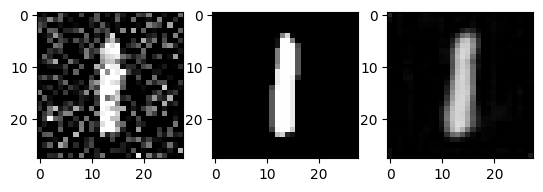

Train Epoch: 28 [0/60000 (0%)]	Loss: 0.031487
Train Epoch: 28 [512/60000 (1%)]	Loss: 0.032673
Train Epoch: 28 [1024/60000 (2%)]	Loss: 0.031301
Train Epoch: 28 [1536/60000 (3%)]	Loss: 0.031730
Train Epoch: 28 [2048/60000 (3%)]	Loss: 0.032344
Train Epoch: 28 [2560/60000 (4%)]	Loss: 0.032809
Train Epoch: 28 [3072/60000 (5%)]	Loss: 0.030802
Train Epoch: 28 [3584/60000 (6%)]	Loss: 0.029816
Train Epoch: 28 [4096/60000 (7%)]	Loss: 0.032641
Train Epoch: 28 [4608/60000 (8%)]	Loss: 0.032461
Train Epoch: 28 [5120/60000 (8%)]	Loss: 0.032186
Train Epoch: 28 [5632/60000 (9%)]	Loss: 0.031575
Train Epoch: 28 [6144/60000 (10%)]	Loss: 0.031887
Train Epoch: 28 [6656/60000 (11%)]	Loss: 0.030805
Train Epoch: 28 [7168/60000 (12%)]	Loss: 0.030085
Train Epoch: 28 [7680/60000 (13%)]	Loss: 0.030985
Train Epoch: 28 [8192/60000 (14%)]	Loss: 0.031636
Train Epoch: 28 [8704/60000 (14%)]	Loss: 0.031929
Train Epoch: 28 [9216/60000 (15%)]	Loss: 0.032587
Train Epoch: 28 [9728/60000 (16%)]	Loss: 0.031689
Train Epoch: 28 

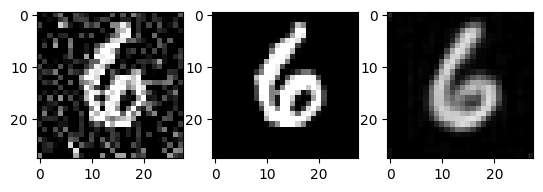

New best! Saving...
Train Epoch: 29 [0/60000 (0%)]	Loss: 0.030553
Train Epoch: 29 [512/60000 (1%)]	Loss: 0.032292
Train Epoch: 29 [1024/60000 (2%)]	Loss: 0.031122
Train Epoch: 29 [1536/60000 (3%)]	Loss: 0.030911
Train Epoch: 29 [2048/60000 (3%)]	Loss: 0.032323
Train Epoch: 29 [2560/60000 (4%)]	Loss: 0.031473
Train Epoch: 29 [3072/60000 (5%)]	Loss: 0.032174
Train Epoch: 29 [3584/60000 (6%)]	Loss: 0.031877
Train Epoch: 29 [4096/60000 (7%)]	Loss: 0.032952
Train Epoch: 29 [4608/60000 (8%)]	Loss: 0.031004
Train Epoch: 29 [5120/60000 (8%)]	Loss: 0.031890
Train Epoch: 29 [5632/60000 (9%)]	Loss: 0.031665
Train Epoch: 29 [6144/60000 (10%)]	Loss: 0.030814
Train Epoch: 29 [6656/60000 (11%)]	Loss: 0.031567
Train Epoch: 29 [7168/60000 (12%)]	Loss: 0.031000
Train Epoch: 29 [7680/60000 (13%)]	Loss: 0.032220
Train Epoch: 29 [8192/60000 (14%)]	Loss: 0.030503
Train Epoch: 29 [8704/60000 (14%)]	Loss: 0.032289
Train Epoch: 29 [9216/60000 (15%)]	Loss: 0.031374
Train Epoch: 29 [9728/60000 (16%)]	Loss: 0.031

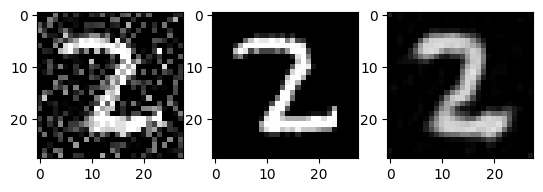

Train Epoch: 30 [0/60000 (0%)]	Loss: 0.031455
Train Epoch: 30 [512/60000 (1%)]	Loss: 0.031438
Train Epoch: 30 [1024/60000 (2%)]	Loss: 0.031898
Train Epoch: 30 [1536/60000 (3%)]	Loss: 0.031918
Train Epoch: 30 [2048/60000 (3%)]	Loss: 0.031155
Train Epoch: 30 [2560/60000 (4%)]	Loss: 0.031768
Train Epoch: 30 [3072/60000 (5%)]	Loss: 0.031513
Train Epoch: 30 [3584/60000 (6%)]	Loss: 0.031787
Train Epoch: 30 [4096/60000 (7%)]	Loss: 0.031237
Train Epoch: 30 [4608/60000 (8%)]	Loss: 0.031967
Train Epoch: 30 [5120/60000 (8%)]	Loss: 0.031318
Train Epoch: 30 [5632/60000 (9%)]	Loss: 0.031777
Train Epoch: 30 [6144/60000 (10%)]	Loss: 0.031740
Train Epoch: 30 [6656/60000 (11%)]	Loss: 0.031914
Train Epoch: 30 [7168/60000 (12%)]	Loss: 0.031806
Train Epoch: 30 [7680/60000 (13%)]	Loss: 0.032456
Train Epoch: 30 [8192/60000 (14%)]	Loss: 0.031276
Train Epoch: 30 [8704/60000 (14%)]	Loss: 0.031130
Train Epoch: 30 [9216/60000 (15%)]	Loss: 0.031453
Train Epoch: 30 [9728/60000 (16%)]	Loss: 0.032102
Train Epoch: 30 

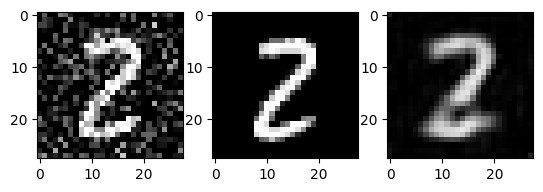

In [ ]:
test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
best=test_losses[-1]
for epoch in range(1, n_epochs + 1):
  train(network, train_loader, epoch, optimizer, loss_fn, log_interval, batch_size_train, train_losses, train_counter)
  test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
  if test_losses[-1] < best:
    best=test_losses[-1]
    print("New best! Saving...")
    torch.save(network.state_dict(), parameters_file)
  scheduler.step()

torch.save((train_counter, train_losses, test_losses), training_data_file)

Best: 0.03175927326083183


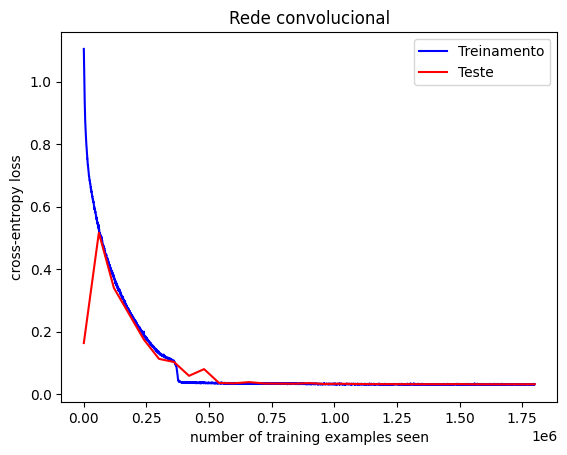

In [ ]:
fig = plt.figure()
(train_counter, train_losses, test_losses) = torch.load( training_data_file)

test_counter = [i*len(train_loader.dataset) for i in range(len(test_losses))]
for i in range(len(train_losses)):
  train_losses[i] = train_losses[i]

for i in range(len(test_losses)):
  test_losses[i] = test_losses[i].cpu().detach()

plt.plot(train_counter, train_losses, color='blue', label='Treinamento')
plt.plot(test_counter, test_losses, color='red', label='Teste')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross-entropy loss')
plt.legend()
plt.title("Rede convolucional")

print(f"Best: {min(test_losses)}")

torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])


<Figure size 640x480 with 0 Axes>

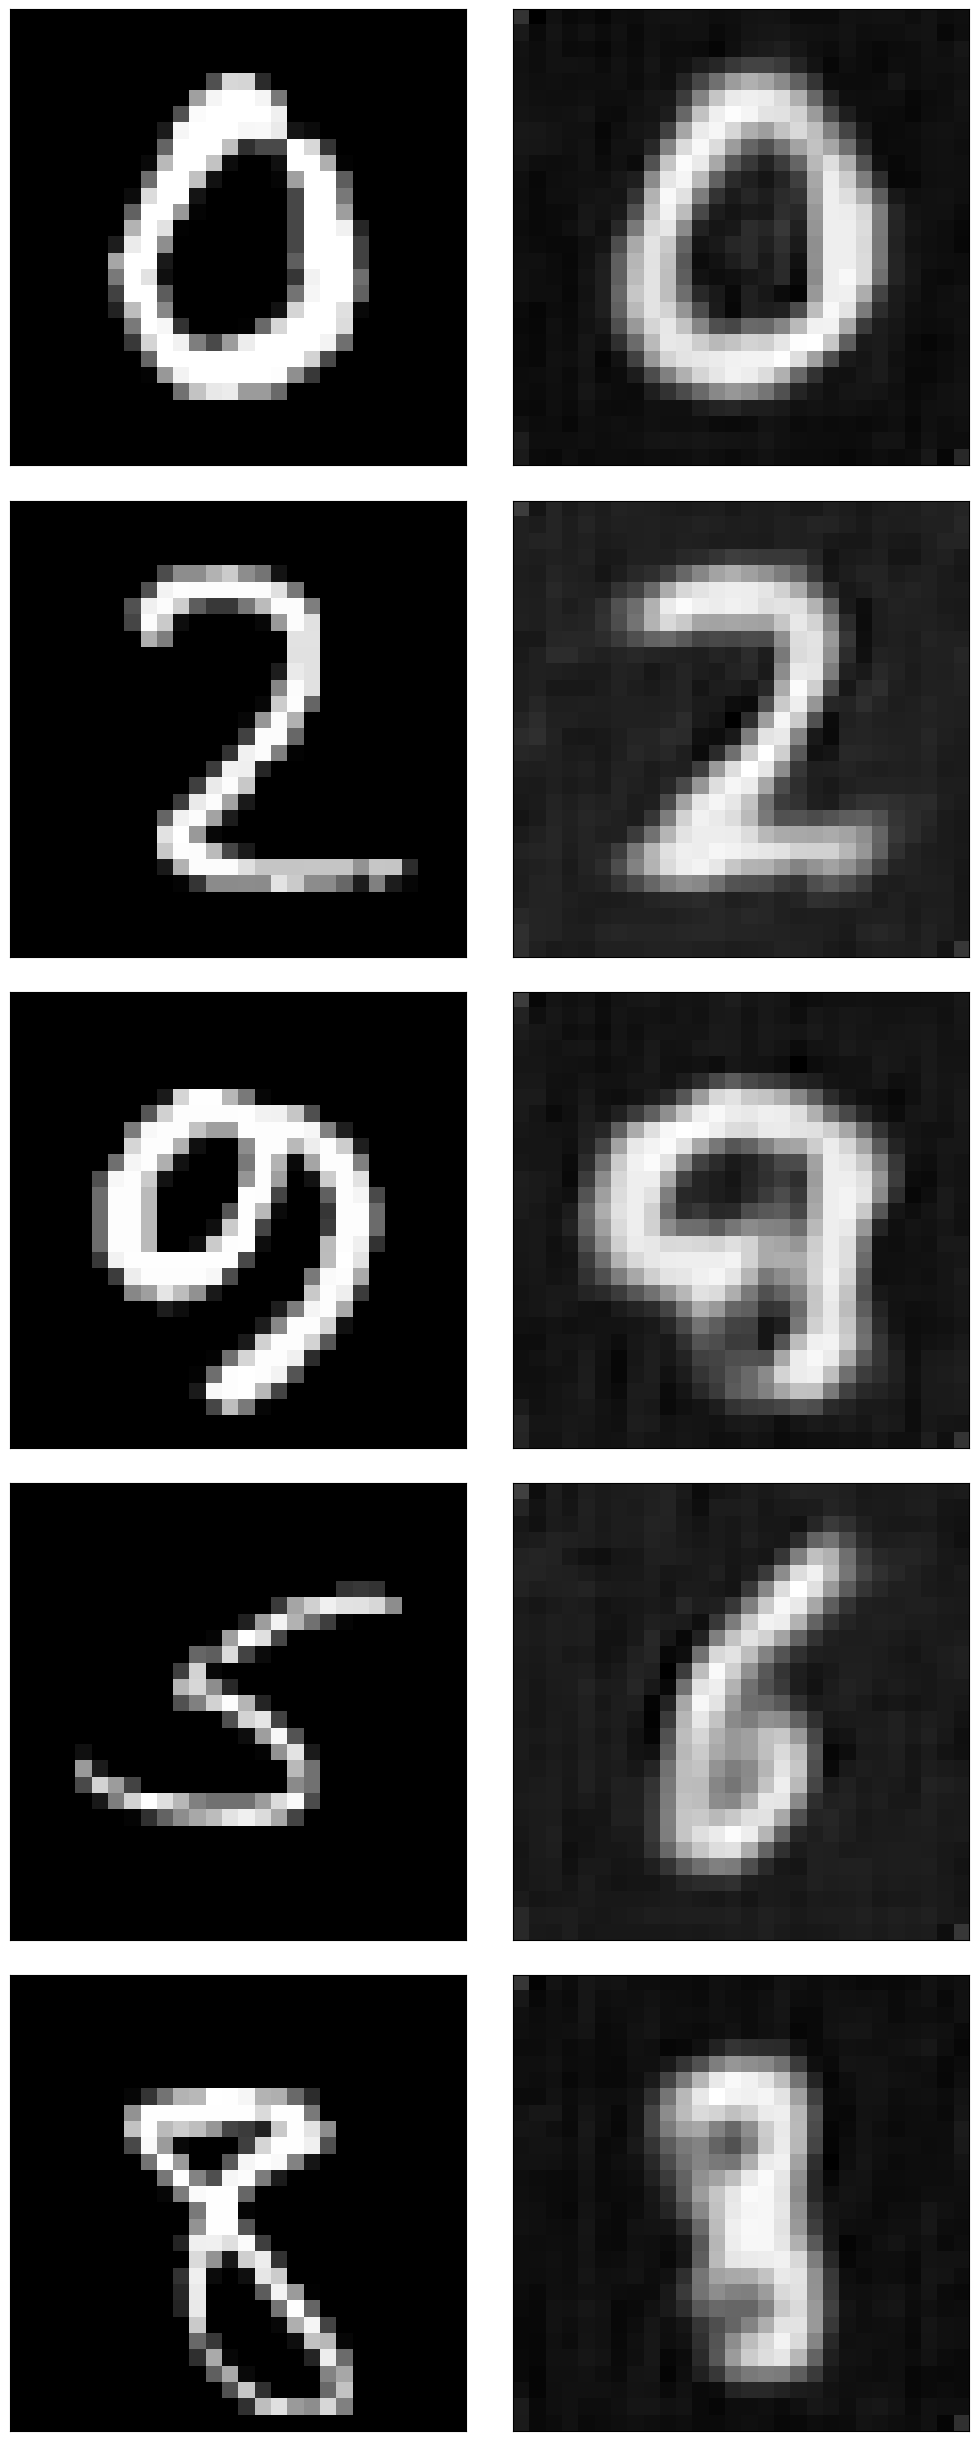

In [ ]:

network.load_state_dict(torch.load(parameters_file))
network.eval()
fig = plt.figure()
length=5
begin=0
visualization_range = np.random.choice(len(test_data), length)
example_data = torch.stack([test_data[i][0] for i in visualization_range])
network.eval()
plt.figure(figsize=(2*5, length*5))
for i in range(length):
  print(example_data[i].shape)

  data = example_data[i].movedim(0, 2)

  print(data.shape)
  plt.subplot(length,2,2*i+1)
  plt.tight_layout()
  plt.imshow(data, cmap='gray')
  plt.xticks([])
  plt.yticks([])




  with torch.no_grad():
    output = network(example_data[i].to(device).unsqueeze(0)).squeeze(0)
    print (output.shape)
    plt.subplot(length,2,2*i+2)
    plt.tight_layout()
    plt.imshow(output.cpu().movedim(0, 2) , cmap='gray')
    plt.xticks([])
    plt.yticks([])


In [ ]:
encoder = network.Encoder
decoder = network.Decoder
latent_shape = encoder(train_data[0][0].unsqueeze(0).to(device)).shape

In [ ]:
mean, var, max_val, min_val = get_stats_latent(test_loader, encoder)
print(mean, var, max_val, min_val)

tensor(0.0658) tensor(0.8044) tensor(3.1914) tensor(-3.4745)


torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 

<Figure size 640x480 with 0 Axes>

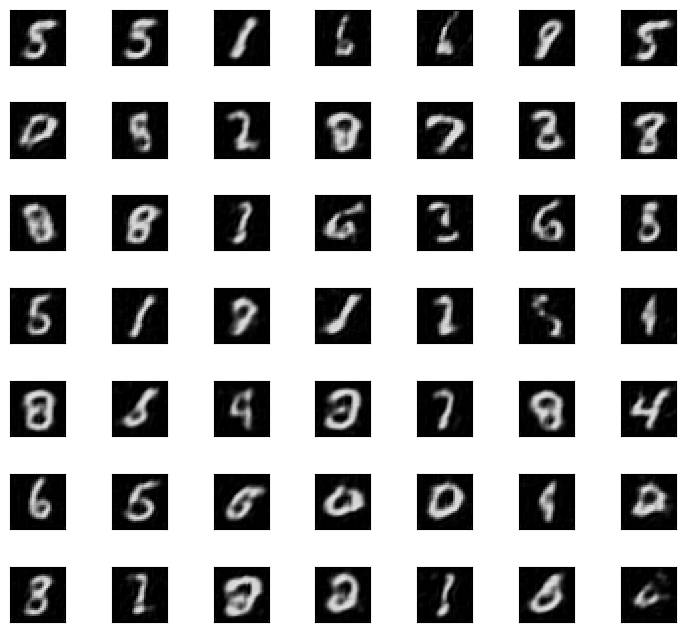

In [ ]:
network.eval()
with torch.no_grad():
  out_shape=(49, latent_shape[1])
  mean_tensor = torch.full(out_shape, mean)
  std_tensor = torch.full(out_shape, torch.sqrt(var))
  sample=torch.normal(mean_tensor, std_tensor)
  generated=decoder(sample.to(device)).to('cpu')

fig = plt.figure()
length=49
begin=0
network.eval()
plt.figure(figsize=(7, 7))
for i in range(length):

  data = generated[i].movedim(0, 2)

  print(data.shape)
  plt.subplot(7,7,i+1)
  plt.tight_layout()
  plt.imshow(data, cmap='gray', vmin=0, vmax=1)
  plt.xticks([])
  plt.yticks([])



## Variational Autoencoder

In [11]:
#Based on RESNET block
class AEBlock(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()
    # self.conv1 = nn.Conv2d(in_channels, out_channels, 1, padding='same')
    self.seq=nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, padding='same'),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, 3, padding='same'),
      nn.BatchNorm2d(out_channels))



  def forward(self, x):
    # return self.final_activation(self.conv1(x) + self.seq(x))
    return self.seq(x)

class UpConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.ct= nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
      nn.ReLU())


  def forward(self, x):
    o = self.ct(x)
    return o

class VEncoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()

    self.e1=AEBlock(1, 8)
    self.me1=nn.MaxPool2d(2)
    self.e2=AEBlock(8, 16)
    self.me2=nn.MaxPool2d(2)

    self.mean=nn.Sequential(nn.Linear(784, latent_size))
    self.var=nn.Sequential(nn.Linear(784, latent_size))



  def forward(self, x):
    i1 = self.e1(x)
    i2 = self.e2(self.me1(i1))

    pb = self.me2(i2)
    pb=pb.view(pb.shape[0], -1)



    return (self.mean(pb), torch.exp(self.var(pb)))

class VDecoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()

    self.bt=nn.Linear(latent_size, 784)


    self.ct1=UpConvBlock(16, 16)
    self.d1=AEBlock(16, 8)

    self.ct2=UpConvBlock(8, 8)
    self.d2=AEBlock(8, 1)


  def forward(self, x):
    b = self.bt(x).view((x.shape[0], 16, 7, 7))


    o1 = self.d1( self.ct1(b) )
    o2 = self.d2( self.ct2(o1) )

    return o2

# Based on https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f and https://avandekleut.github.io/vae/
class VAutoEncoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()


        self.Encoder = VEncoder(latent_size)
        self.Decoder = VDecoder(latent_size)





    def forward(self, x):
        mean, var = self.Encoder(x)
        z = mean + torch.randn_like(var) * var

        self.kl =  (0.5*var**2 + 0.5*mean**2 - torch.log(var) - 1/2).sum()
        return self.Decoder(z)


    def VAELoss(self, output, target):
      return ((output - target) ** 2).sum() + self.kl





In [12]:
random_seed = 42
torch.manual_seed(random_seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
parameters_file='/content/drive/MyDrive/modelos/AE_MNIST/parameters_var.pth'
saved_parameters_file='/content/drive/MyDrive/modelos/AE_MNIST/best_parameters_var.pth'
training_data_file='/content/drive/MyDrive/modelos/AE_MNIST/treinamento_var.pickle'
batch_size_train = 512
batch_size_test = 512
train_loader = torch.utils.data.DataLoader(
  train_data,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_data,
  batch_size=batch_size_test, shuffle=True)
device

'cuda'

In [13]:
gc.collect()
torch.cuda.empty_cache()
n_epochs = 60

learning_rate = 1e-3

log_interval=2

network = VAutoEncoder(5).to(device)

optimizer = optim.Adam(network.parameters(), lr=learning_rate)
loss_fn=network.VAELoss
scheduler = schd.StepLR(optimizer, 20, 0.5)

train_losses = []
train_counter = []
test_losses = []
test_counter=[]


In [22]:
count_parameters(network)

19969


Test set: Avg. loss: 36071.1484


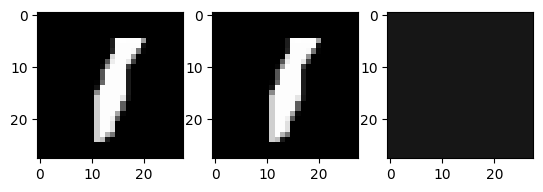

Train Epoch: 1 [0/60000 (0%)]	Loss: 447343.718750
Train Epoch: 1 [1024/60000 (2%)]	Loss: 442695.781250
Train Epoch: 1 [2048/60000 (3%)]	Loss: 436922.906250
Train Epoch: 1 [3072/60000 (5%)]	Loss: 430495.062500
Train Epoch: 1 [4096/60000 (7%)]	Loss: 423710.156250
Train Epoch: 1 [5120/60000 (8%)]	Loss: 416588.562500
Train Epoch: 1 [6144/60000 (10%)]	Loss: 407794.093750
Train Epoch: 1 [7168/60000 (12%)]	Loss: 396024.406250
Train Epoch: 1 [8192/60000 (14%)]	Loss: 385133.906250
Train Epoch: 1 [9216/60000 (15%)]	Loss: 371181.968750
Train Epoch: 1 [10240/60000 (17%)]	Loss: 357867.312500
Train Epoch: 1 [11264/60000 (19%)]	Loss: 344920.500000
Train Epoch: 1 [12288/60000 (20%)]	Loss: 328737.812500
Train Epoch: 1 [13312/60000 (22%)]	Loss: 314861.000000
Train Epoch: 1 [14336/60000 (24%)]	Loss: 303261.812500
Train Epoch: 1 [15360/60000 (25%)]	Loss: 297501.375000
Train Epoch: 1 [16384/60000 (27%)]	Loss: 288582.593750
Train Epoch: 1 [17408/60000 (29%)]	Loss: 282418.625000
Train Epoch: 1 [18432/60000 (

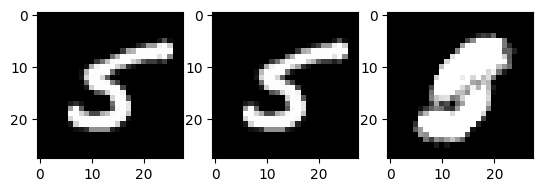

Train Epoch: 2 [0/60000 (0%)]	Loss: 202182.578125
Train Epoch: 2 [1024/60000 (2%)]	Loss: 201336.171875
Train Epoch: 2 [2048/60000 (3%)]	Loss: 197974.046875
Train Epoch: 2 [3072/60000 (5%)]	Loss: 196943.000000
Train Epoch: 2 [4096/60000 (7%)]	Loss: 195086.718750
Train Epoch: 2 [5120/60000 (8%)]	Loss: 195485.828125
Train Epoch: 2 [6144/60000 (10%)]	Loss: 193452.750000
Train Epoch: 2 [7168/60000 (12%)]	Loss: 194085.218750
Train Epoch: 2 [8192/60000 (14%)]	Loss: 190426.312500
Train Epoch: 2 [9216/60000 (15%)]	Loss: 187796.000000
Train Epoch: 2 [10240/60000 (17%)]	Loss: 189501.687500
Train Epoch: 2 [11264/60000 (19%)]	Loss: 188088.093750
Train Epoch: 2 [12288/60000 (20%)]	Loss: 184351.562500
Train Epoch: 2 [13312/60000 (22%)]	Loss: 185679.375000
Train Epoch: 2 [14336/60000 (24%)]	Loss: 185788.375000
Train Epoch: 2 [15360/60000 (25%)]	Loss: 182665.859375
Train Epoch: 2 [16384/60000 (27%)]	Loss: 182756.640625
Train Epoch: 2 [17408/60000 (29%)]	Loss: 180012.937500
Train Epoch: 2 [18432/60000 (

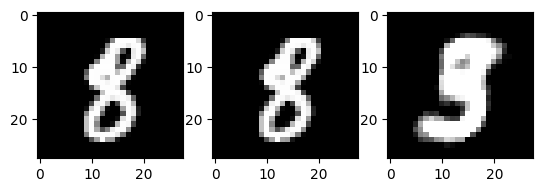

Train Epoch: 3 [0/60000 (0%)]	Loss: 141774.046875
Train Epoch: 3 [1024/60000 (2%)]	Loss: 142648.359375
Train Epoch: 3 [2048/60000 (3%)]	Loss: 141459.921875
Train Epoch: 3 [3072/60000 (5%)]	Loss: 138999.687500
Train Epoch: 3 [4096/60000 (7%)]	Loss: 140270.281250
Train Epoch: 3 [5120/60000 (8%)]	Loss: 139412.546875
Train Epoch: 3 [6144/60000 (10%)]	Loss: 138292.843750
Train Epoch: 3 [7168/60000 (12%)]	Loss: 137460.312500
Train Epoch: 3 [8192/60000 (14%)]	Loss: 135107.906250
Train Epoch: 3 [9216/60000 (15%)]	Loss: 136598.546875
Train Epoch: 3 [10240/60000 (17%)]	Loss: 133177.703125
Train Epoch: 3 [11264/60000 (19%)]	Loss: 135606.046875
Train Epoch: 3 [12288/60000 (20%)]	Loss: 133446.906250
Train Epoch: 3 [13312/60000 (22%)]	Loss: 131741.046875
Train Epoch: 3 [14336/60000 (24%)]	Loss: 132447.968750
Train Epoch: 3 [15360/60000 (25%)]	Loss: 132241.062500
Train Epoch: 3 [16384/60000 (27%)]	Loss: 131219.750000
Train Epoch: 3 [17408/60000 (29%)]	Loss: 129447.750000
Train Epoch: 3 [18432/60000 (

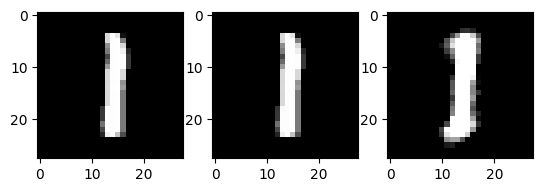

Train Epoch: 4 [0/60000 (0%)]	Loss: 102136.335938
Train Epoch: 4 [1024/60000 (2%)]	Loss: 101952.296875
Train Epoch: 4 [2048/60000 (3%)]	Loss: 102896.164062
Train Epoch: 4 [3072/60000 (5%)]	Loss: 101331.976562
Train Epoch: 4 [4096/60000 (7%)]	Loss: 99915.054688
Train Epoch: 4 [5120/60000 (8%)]	Loss: 100090.625000
Train Epoch: 4 [6144/60000 (10%)]	Loss: 100049.273438
Train Epoch: 4 [7168/60000 (12%)]	Loss: 98082.929688
Train Epoch: 4 [8192/60000 (14%)]	Loss: 99933.507812
Train Epoch: 4 [9216/60000 (15%)]	Loss: 97427.453125
Train Epoch: 4 [10240/60000 (17%)]	Loss: 98622.796875
Train Epoch: 4 [11264/60000 (19%)]	Loss: 98436.140625
Train Epoch: 4 [12288/60000 (20%)]	Loss: 95826.929688
Train Epoch: 4 [13312/60000 (22%)]	Loss: 96394.242188
Train Epoch: 4 [14336/60000 (24%)]	Loss: 95389.437500
Train Epoch: 4 [15360/60000 (25%)]	Loss: 94975.625000
Train Epoch: 4 [16384/60000 (27%)]	Loss: 93717.007812
Train Epoch: 4 [17408/60000 (29%)]	Loss: 94478.687500
Train Epoch: 4 [18432/60000 (31%)]	Loss: 

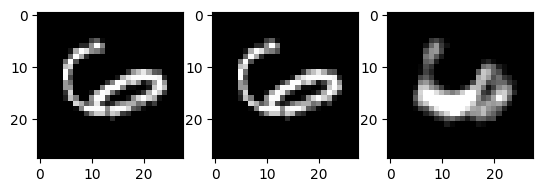

Train Epoch: 5 [0/60000 (0%)]	Loss: 73505.640625
Train Epoch: 5 [1024/60000 (2%)]	Loss: 73388.562500
Train Epoch: 5 [2048/60000 (3%)]	Loss: 73152.710938
Train Epoch: 5 [3072/60000 (5%)]	Loss: 73291.468750
Train Epoch: 5 [4096/60000 (7%)]	Loss: 72492.218750
Train Epoch: 5 [5120/60000 (8%)]	Loss: 72313.726562
Train Epoch: 5 [6144/60000 (10%)]	Loss: 72192.398438
Train Epoch: 5 [7168/60000 (12%)]	Loss: 71875.789062
Train Epoch: 5 [8192/60000 (14%)]	Loss: 71354.226562
Train Epoch: 5 [9216/60000 (15%)]	Loss: 70919.390625
Train Epoch: 5 [10240/60000 (17%)]	Loss: 71909.484375
Train Epoch: 5 [11264/60000 (19%)]	Loss: 70276.945312
Train Epoch: 5 [12288/60000 (20%)]	Loss: 70313.617188
Train Epoch: 5 [13312/60000 (22%)]	Loss: 68060.039062
Train Epoch: 5 [14336/60000 (24%)]	Loss: 67963.328125
Train Epoch: 5 [15360/60000 (25%)]	Loss: 69423.968750
Train Epoch: 5 [16384/60000 (27%)]	Loss: 67808.656250
Train Epoch: 5 [17408/60000 (29%)]	Loss: 68822.718750
Train Epoch: 5 [18432/60000 (31%)]	Loss: 67386.

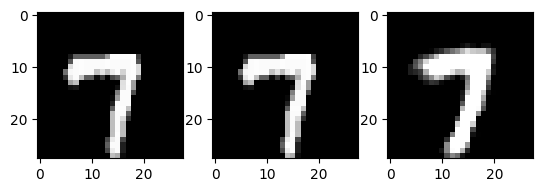

Train Epoch: 6 [0/60000 (0%)]	Loss: 55545.554688
Train Epoch: 6 [1024/60000 (2%)]	Loss: 54349.964844
Train Epoch: 6 [2048/60000 (3%)]	Loss: 52776.117188
Train Epoch: 6 [3072/60000 (5%)]	Loss: 53439.417969
Train Epoch: 6 [4096/60000 (7%)]	Loss: 52145.433594
Train Epoch: 6 [5120/60000 (8%)]	Loss: 52869.281250
Train Epoch: 6 [6144/60000 (10%)]	Loss: 51189.351562
Train Epoch: 6 [7168/60000 (12%)]	Loss: 51372.355469
Train Epoch: 6 [8192/60000 (14%)]	Loss: 51193.218750
Train Epoch: 6 [9216/60000 (15%)]	Loss: 51274.621094
Train Epoch: 6 [10240/60000 (17%)]	Loss: 52093.679688
Train Epoch: 6 [11264/60000 (19%)]	Loss: 51469.882812
Train Epoch: 6 [12288/60000 (20%)]	Loss: 50400.171875
Train Epoch: 6 [13312/60000 (22%)]	Loss: 49574.351562
Train Epoch: 6 [14336/60000 (24%)]	Loss: 50189.972656
Train Epoch: 6 [15360/60000 (25%)]	Loss: 49820.449219
Train Epoch: 6 [16384/60000 (27%)]	Loss: 49967.738281
Train Epoch: 6 [17408/60000 (29%)]	Loss: 49335.292969
Train Epoch: 6 [18432/60000 (31%)]	Loss: 49480.

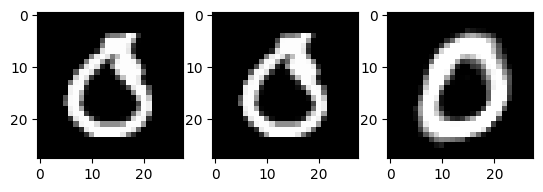

Train Epoch: 7 [0/60000 (0%)]	Loss: 40228.632812
Train Epoch: 7 [1024/60000 (2%)]	Loss: 40294.914062
Train Epoch: 7 [2048/60000 (3%)]	Loss: 40785.003906
Train Epoch: 7 [3072/60000 (5%)]	Loss: 39385.457031
Train Epoch: 7 [4096/60000 (7%)]	Loss: 38332.777344
Train Epoch: 7 [5120/60000 (8%)]	Loss: 38735.792969
Train Epoch: 7 [6144/60000 (10%)]	Loss: 38850.367188
Train Epoch: 7 [7168/60000 (12%)]	Loss: 38995.234375
Train Epoch: 7 [8192/60000 (14%)]	Loss: 38353.792969
Train Epoch: 7 [9216/60000 (15%)]	Loss: 38326.738281
Train Epoch: 7 [10240/60000 (17%)]	Loss: 38132.609375
Train Epoch: 7 [11264/60000 (19%)]	Loss: 37915.015625
Train Epoch: 7 [12288/60000 (20%)]	Loss: 38012.039062
Train Epoch: 7 [13312/60000 (22%)]	Loss: 38003.730469
Train Epoch: 7 [14336/60000 (24%)]	Loss: 36951.421875
Train Epoch: 7 [15360/60000 (25%)]	Loss: 37388.667969
Train Epoch: 7 [16384/60000 (27%)]	Loss: 36706.457031
Train Epoch: 7 [17408/60000 (29%)]	Loss: 37016.464844
Train Epoch: 7 [18432/60000 (31%)]	Loss: 36548.

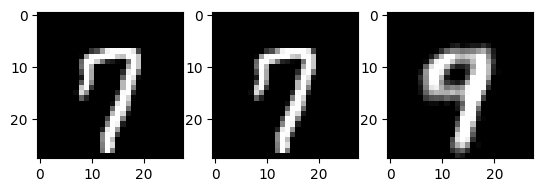

New best! Saving...
Train Epoch: 8 [0/60000 (0%)]	Loss: 31646.171875
Train Epoch: 8 [1024/60000 (2%)]	Loss: 30261.771484
Train Epoch: 8 [2048/60000 (3%)]	Loss: 29539.785156
Train Epoch: 8 [3072/60000 (5%)]	Loss: 29743.529297
Train Epoch: 8 [4096/60000 (7%)]	Loss: 30701.875000
Train Epoch: 8 [5120/60000 (8%)]	Loss: 29755.683594
Train Epoch: 8 [6144/60000 (10%)]	Loss: 29923.832031
Train Epoch: 8 [7168/60000 (12%)]	Loss: 30227.279297
Train Epoch: 8 [8192/60000 (14%)]	Loss: 29644.250000
Train Epoch: 8 [9216/60000 (15%)]	Loss: 30245.400391
Train Epoch: 8 [10240/60000 (17%)]	Loss: 29141.404297
Train Epoch: 8 [11264/60000 (19%)]	Loss: 30535.119141
Train Epoch: 8 [12288/60000 (20%)]	Loss: 29280.558594
Train Epoch: 8 [13312/60000 (22%)]	Loss: 29451.468750
Train Epoch: 8 [14336/60000 (24%)]	Loss: 29176.828125
Train Epoch: 8 [15360/60000 (25%)]	Loss: 29096.867188
Train Epoch: 8 [16384/60000 (27%)]	Loss: 28699.753906
Train Epoch: 8 [17408/60000 (29%)]	Loss: 29503.912109
Train Epoch: 8 [18432/60000

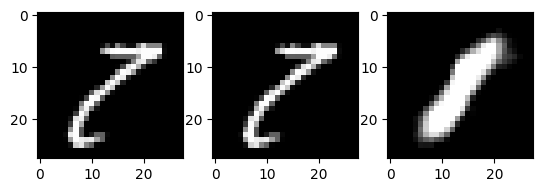

New best! Saving...
Train Epoch: 9 [0/60000 (0%)]	Loss: 25033.511719
Train Epoch: 9 [1024/60000 (2%)]	Loss: 24926.455078
Train Epoch: 9 [2048/60000 (3%)]	Loss: 24460.640625
Train Epoch: 9 [3072/60000 (5%)]	Loss: 24718.566406
Train Epoch: 9 [4096/60000 (7%)]	Loss: 24674.554688
Train Epoch: 9 [5120/60000 (8%)]	Loss: 24968.218750
Train Epoch: 9 [6144/60000 (10%)]	Loss: 24256.728516
Train Epoch: 9 [7168/60000 (12%)]	Loss: 24583.716797
Train Epoch: 9 [8192/60000 (14%)]	Loss: 24530.185547
Train Epoch: 9 [9216/60000 (15%)]	Loss: 24263.460938
Train Epoch: 9 [10240/60000 (17%)]	Loss: 24508.265625
Train Epoch: 9 [11264/60000 (19%)]	Loss: 24837.269531
Train Epoch: 9 [12288/60000 (20%)]	Loss: 23883.201172
Train Epoch: 9 [13312/60000 (22%)]	Loss: 23992.349609
Train Epoch: 9 [14336/60000 (24%)]	Loss: 24127.257812
Train Epoch: 9 [15360/60000 (25%)]	Loss: 23788.931641
Train Epoch: 9 [16384/60000 (27%)]	Loss: 23676.087891
Train Epoch: 9 [17408/60000 (29%)]	Loss: 23240.902344
Train Epoch: 9 [18432/60000

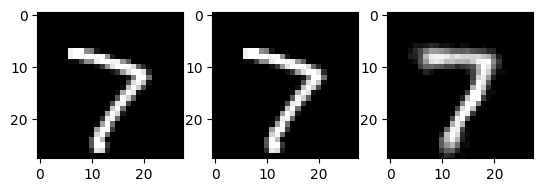

New best! Saving...
Train Epoch: 10 [0/60000 (0%)]	Loss: 21233.410156
Train Epoch: 10 [1024/60000 (2%)]	Loss: 21245.101562
Train Epoch: 10 [2048/60000 (3%)]	Loss: 21574.980469
Train Epoch: 10 [3072/60000 (5%)]	Loss: 21512.498047
Train Epoch: 10 [4096/60000 (7%)]	Loss: 20756.015625
Train Epoch: 10 [5120/60000 (8%)]	Loss: 21158.396484
Train Epoch: 10 [6144/60000 (10%)]	Loss: 20744.029297
Train Epoch: 10 [7168/60000 (12%)]	Loss: 21058.275391
Train Epoch: 10 [8192/60000 (14%)]	Loss: 21507.425781
Train Epoch: 10 [9216/60000 (15%)]	Loss: 21043.400391
Train Epoch: 10 [10240/60000 (17%)]	Loss: 20896.779297
Train Epoch: 10 [11264/60000 (19%)]	Loss: 21141.951172
Train Epoch: 10 [12288/60000 (20%)]	Loss: 20995.681641
Train Epoch: 10 [13312/60000 (22%)]	Loss: 20358.244141
Train Epoch: 10 [14336/60000 (24%)]	Loss: 20786.527344
Train Epoch: 10 [15360/60000 (25%)]	Loss: 20743.873047
Train Epoch: 10 [16384/60000 (27%)]	Loss: 21296.964844
Train Epoch: 10 [17408/60000 (29%)]	Loss: 20713.140625
Train Epo

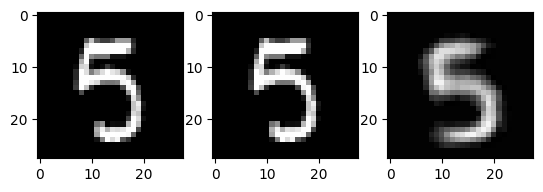

Train Epoch: 11 [0/60000 (0%)]	Loss: 19947.859375
Train Epoch: 11 [1024/60000 (2%)]	Loss: 19925.843750
Train Epoch: 11 [2048/60000 (3%)]	Loss: 18657.863281
Train Epoch: 11 [3072/60000 (5%)]	Loss: 19261.054688
Train Epoch: 11 [4096/60000 (7%)]	Loss: 19168.027344
Train Epoch: 11 [5120/60000 (8%)]	Loss: 19395.876953
Train Epoch: 11 [6144/60000 (10%)]	Loss: 19344.886719
Train Epoch: 11 [7168/60000 (12%)]	Loss: 19123.843750
Train Epoch: 11 [8192/60000 (14%)]	Loss: 19259.503906
Train Epoch: 11 [9216/60000 (15%)]	Loss: 19361.554688
Train Epoch: 11 [10240/60000 (17%)]	Loss: 18903.144531
Train Epoch: 11 [11264/60000 (19%)]	Loss: 18903.791016
Train Epoch: 11 [12288/60000 (20%)]	Loss: 19414.378906
Train Epoch: 11 [13312/60000 (22%)]	Loss: 18981.541016
Train Epoch: 11 [14336/60000 (24%)]	Loss: 19408.062500
Train Epoch: 11 [15360/60000 (25%)]	Loss: 19419.115234
Train Epoch: 11 [16384/60000 (27%)]	Loss: 19101.269531
Train Epoch: 11 [17408/60000 (29%)]	Loss: 18998.160156
Train Epoch: 11 [18432/60000 

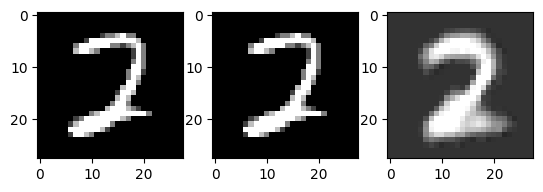

Train Epoch: 12 [0/60000 (0%)]	Loss: 18657.863281
Train Epoch: 12 [1024/60000 (2%)]	Loss: 18202.066406
Train Epoch: 12 [2048/60000 (3%)]	Loss: 18144.441406
Train Epoch: 12 [3072/60000 (5%)]	Loss: 18355.332031
Train Epoch: 12 [4096/60000 (7%)]	Loss: 18551.988281
Train Epoch: 12 [5120/60000 (8%)]	Loss: 18045.363281
Train Epoch: 12 [6144/60000 (10%)]	Loss: 18551.800781
Train Epoch: 12 [7168/60000 (12%)]	Loss: 18086.492188
Train Epoch: 12 [8192/60000 (14%)]	Loss: 17998.011719
Train Epoch: 12 [9216/60000 (15%)]	Loss: 17445.421875
Train Epoch: 12 [10240/60000 (17%)]	Loss: 17581.441406
Train Epoch: 12 [11264/60000 (19%)]	Loss: 17888.802734
Train Epoch: 12 [12288/60000 (20%)]	Loss: 17902.837891
Train Epoch: 12 [13312/60000 (22%)]	Loss: 18080.007812
Train Epoch: 12 [14336/60000 (24%)]	Loss: 17690.433594
Train Epoch: 12 [15360/60000 (25%)]	Loss: 17591.488281
Train Epoch: 12 [16384/60000 (27%)]	Loss: 17603.029297
Train Epoch: 12 [17408/60000 (29%)]	Loss: 17641.208984
Train Epoch: 12 [18432/60000 

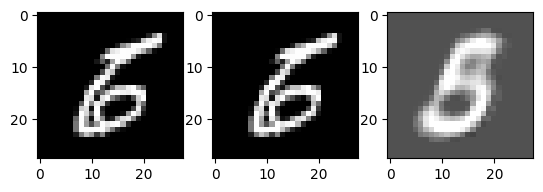

Train Epoch: 13 [0/60000 (0%)]	Loss: 17201.810547
Train Epoch: 13 [1024/60000 (2%)]	Loss: 16926.683594
Train Epoch: 13 [2048/60000 (3%)]	Loss: 17313.371094
Train Epoch: 13 [3072/60000 (5%)]	Loss: 17246.527344
Train Epoch: 13 [4096/60000 (7%)]	Loss: 16517.781250
Train Epoch: 13 [5120/60000 (8%)]	Loss: 17843.291016
Train Epoch: 13 [6144/60000 (10%)]	Loss: 17034.246094
Train Epoch: 13 [7168/60000 (12%)]	Loss: 17584.175781
Train Epoch: 13 [8192/60000 (14%)]	Loss: 17557.337891
Train Epoch: 13 [9216/60000 (15%)]	Loss: 17240.812500
Train Epoch: 13 [10240/60000 (17%)]	Loss: 17392.031250
Train Epoch: 13 [11264/60000 (19%)]	Loss: 17518.843750
Train Epoch: 13 [12288/60000 (20%)]	Loss: 17171.306641
Train Epoch: 13 [13312/60000 (22%)]	Loss: 16966.171875
Train Epoch: 13 [14336/60000 (24%)]	Loss: 17313.359375
Train Epoch: 13 [15360/60000 (25%)]	Loss: 16930.964844
Train Epoch: 13 [16384/60000 (27%)]	Loss: 17101.207031
Train Epoch: 13 [17408/60000 (29%)]	Loss: 17426.031250
Train Epoch: 13 [18432/60000 

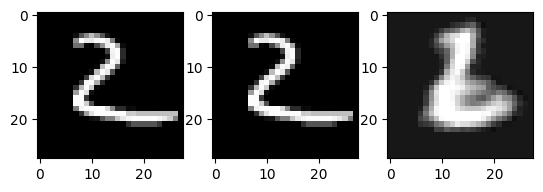

Train Epoch: 14 [0/60000 (0%)]	Loss: 17591.378906
Train Epoch: 14 [1024/60000 (2%)]	Loss: 17296.138672
Train Epoch: 14 [2048/60000 (3%)]	Loss: 17513.185547
Train Epoch: 14 [3072/60000 (5%)]	Loss: 17780.742188
Train Epoch: 14 [4096/60000 (7%)]	Loss: 17368.808594
Train Epoch: 14 [5120/60000 (8%)]	Loss: 17058.406250
Train Epoch: 14 [6144/60000 (10%)]	Loss: 17457.236328
Train Epoch: 14 [7168/60000 (12%)]	Loss: 16951.523438
Train Epoch: 14 [8192/60000 (14%)]	Loss: 17112.203125
Train Epoch: 14 [9216/60000 (15%)]	Loss: 16646.792969
Train Epoch: 14 [10240/60000 (17%)]	Loss: 17740.218750
Train Epoch: 14 [11264/60000 (19%)]	Loss: 17286.353516
Train Epoch: 14 [12288/60000 (20%)]	Loss: 17497.738281
Train Epoch: 14 [13312/60000 (22%)]	Loss: 17017.978516
Train Epoch: 14 [14336/60000 (24%)]	Loss: 17275.679688
Train Epoch: 14 [15360/60000 (25%)]	Loss: 17190.656250
Train Epoch: 14 [16384/60000 (27%)]	Loss: 17495.861328
Train Epoch: 14 [17408/60000 (29%)]	Loss: 17470.943359
Train Epoch: 14 [18432/60000 

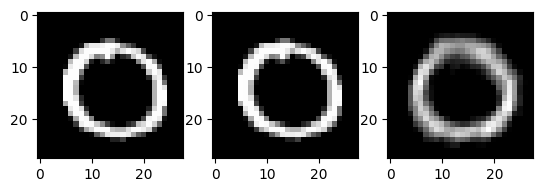

New best! Saving...
Train Epoch: 15 [0/60000 (0%)]	Loss: 17132.732422
Train Epoch: 15 [1024/60000 (2%)]	Loss: 17079.140625
Train Epoch: 15 [2048/60000 (3%)]	Loss: 16861.125000
Train Epoch: 15 [3072/60000 (5%)]	Loss: 17619.333984
Train Epoch: 15 [4096/60000 (7%)]	Loss: 16736.351562
Train Epoch: 15 [5120/60000 (8%)]	Loss: 16910.335938
Train Epoch: 15 [6144/60000 (10%)]	Loss: 16911.867188
Train Epoch: 15 [7168/60000 (12%)]	Loss: 17586.164062
Train Epoch: 15 [8192/60000 (14%)]	Loss: 17191.326172
Train Epoch: 15 [9216/60000 (15%)]	Loss: 17456.875000
Train Epoch: 15 [10240/60000 (17%)]	Loss: 17386.970703
Train Epoch: 15 [11264/60000 (19%)]	Loss: 17275.669922
Train Epoch: 15 [12288/60000 (20%)]	Loss: 17090.539062
Train Epoch: 15 [13312/60000 (22%)]	Loss: 17284.777344
Train Epoch: 15 [14336/60000 (24%)]	Loss: 17030.642578
Train Epoch: 15 [15360/60000 (25%)]	Loss: 16984.763672
Train Epoch: 15 [16384/60000 (27%)]	Loss: 17600.070312
Train Epoch: 15 [17408/60000 (29%)]	Loss: 17171.304688
Train Epo

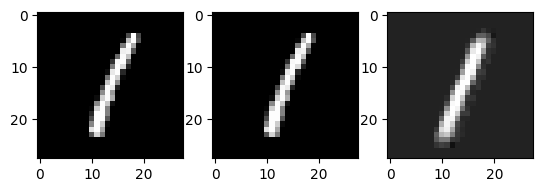

Train Epoch: 16 [0/60000 (0%)]	Loss: 17252.521484
Train Epoch: 16 [1024/60000 (2%)]	Loss: 16981.003906
Train Epoch: 16 [2048/60000 (3%)]	Loss: 17187.181641
Train Epoch: 16 [3072/60000 (5%)]	Loss: 17043.275391
Train Epoch: 16 [4096/60000 (7%)]	Loss: 17497.410156
Train Epoch: 16 [5120/60000 (8%)]	Loss: 17477.246094
Train Epoch: 16 [6144/60000 (10%)]	Loss: 17143.535156
Train Epoch: 16 [7168/60000 (12%)]	Loss: 16662.294922
Train Epoch: 16 [8192/60000 (14%)]	Loss: 17164.171875
Train Epoch: 16 [9216/60000 (15%)]	Loss: 17020.417969
Train Epoch: 16 [10240/60000 (17%)]	Loss: 16625.433594
Train Epoch: 16 [11264/60000 (19%)]	Loss: 17404.771484
Train Epoch: 16 [12288/60000 (20%)]	Loss: 17275.980469
Train Epoch: 16 [13312/60000 (22%)]	Loss: 17198.281250
Train Epoch: 16 [14336/60000 (24%)]	Loss: 17156.476562
Train Epoch: 16 [15360/60000 (25%)]	Loss: 16764.042969
Train Epoch: 16 [16384/60000 (27%)]	Loss: 17022.855469
Train Epoch: 16 [17408/60000 (29%)]	Loss: 17060.027344
Train Epoch: 16 [18432/60000 

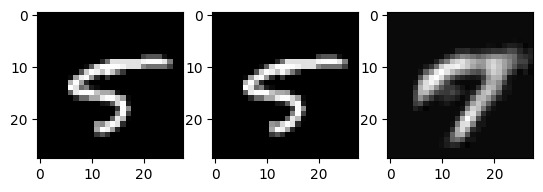

Train Epoch: 17 [0/60000 (0%)]	Loss: 17448.789062
Train Epoch: 17 [1024/60000 (2%)]	Loss: 17196.644531
Train Epoch: 17 [2048/60000 (3%)]	Loss: 17226.677734
Train Epoch: 17 [3072/60000 (5%)]	Loss: 16811.386719
Train Epoch: 17 [4096/60000 (7%)]	Loss: 17339.277344
Train Epoch: 17 [5120/60000 (8%)]	Loss: 16576.912109
Train Epoch: 17 [6144/60000 (10%)]	Loss: 17381.783203
Train Epoch: 17 [7168/60000 (12%)]	Loss: 16542.238281
Train Epoch: 17 [8192/60000 (14%)]	Loss: 17471.300781
Train Epoch: 17 [9216/60000 (15%)]	Loss: 16980.316406
Train Epoch: 17 [10240/60000 (17%)]	Loss: 16995.630859
Train Epoch: 17 [11264/60000 (19%)]	Loss: 17026.978516
Train Epoch: 17 [12288/60000 (20%)]	Loss: 16863.925781
Train Epoch: 17 [13312/60000 (22%)]	Loss: 16882.033203
Train Epoch: 17 [14336/60000 (24%)]	Loss: 16555.429688
Train Epoch: 17 [15360/60000 (25%)]	Loss: 16927.875000
Train Epoch: 17 [16384/60000 (27%)]	Loss: 16855.031250
Train Epoch: 17 [17408/60000 (29%)]	Loss: 16896.816406
Train Epoch: 17 [18432/60000 

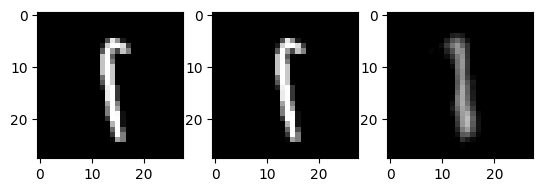

Train Epoch: 18 [0/60000 (0%)]	Loss: 16666.214844
Train Epoch: 18 [1024/60000 (2%)]	Loss: 16830.460938
Train Epoch: 18 [2048/60000 (3%)]	Loss: 16905.634766
Train Epoch: 18 [3072/60000 (5%)]	Loss: 17194.507812
Train Epoch: 18 [4096/60000 (7%)]	Loss: 16729.607422
Train Epoch: 18 [5120/60000 (8%)]	Loss: 16764.642578
Train Epoch: 18 [6144/60000 (10%)]	Loss: 16551.771484
Train Epoch: 18 [7168/60000 (12%)]	Loss: 16886.234375
Train Epoch: 18 [8192/60000 (14%)]	Loss: 17307.939453
Train Epoch: 18 [9216/60000 (15%)]	Loss: 16467.974609
Train Epoch: 18 [10240/60000 (17%)]	Loss: 17230.679688
Train Epoch: 18 [11264/60000 (19%)]	Loss: 16960.851562
Train Epoch: 18 [12288/60000 (20%)]	Loss: 17453.437500
Train Epoch: 18 [13312/60000 (22%)]	Loss: 16972.011719
Train Epoch: 18 [14336/60000 (24%)]	Loss: 17194.513672
Train Epoch: 18 [15360/60000 (25%)]	Loss: 16894.408203
Train Epoch: 18 [16384/60000 (27%)]	Loss: 17089.695312
Train Epoch: 18 [17408/60000 (29%)]	Loss: 16860.976562
Train Epoch: 18 [18432/60000 

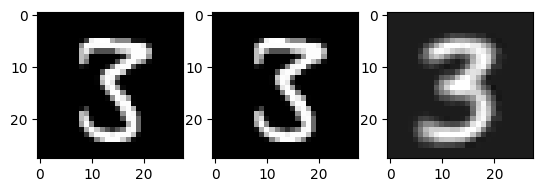

Train Epoch: 19 [0/60000 (0%)]	Loss: 16951.861328
Train Epoch: 19 [1024/60000 (2%)]	Loss: 17183.085938
Train Epoch: 19 [2048/60000 (3%)]	Loss: 17323.982422
Train Epoch: 19 [3072/60000 (5%)]	Loss: 16918.011719
Train Epoch: 19 [4096/60000 (7%)]	Loss: 16924.949219
Train Epoch: 19 [5120/60000 (8%)]	Loss: 17328.167969
Train Epoch: 19 [6144/60000 (10%)]	Loss: 16993.425781
Train Epoch: 19 [7168/60000 (12%)]	Loss: 17198.507812
Train Epoch: 19 [8192/60000 (14%)]	Loss: 17128.613281
Train Epoch: 19 [9216/60000 (15%)]	Loss: 17044.587891
Train Epoch: 19 [10240/60000 (17%)]	Loss: 16803.548828
Train Epoch: 19 [11264/60000 (19%)]	Loss: 17088.138672
Train Epoch: 19 [12288/60000 (20%)]	Loss: 16777.312500
Train Epoch: 19 [13312/60000 (22%)]	Loss: 17116.613281
Train Epoch: 19 [14336/60000 (24%)]	Loss: 16761.509766
Train Epoch: 19 [15360/60000 (25%)]	Loss: 16988.980469
Train Epoch: 19 [16384/60000 (27%)]	Loss: 16894.632812
Train Epoch: 19 [17408/60000 (29%)]	Loss: 16497.046875
Train Epoch: 19 [18432/60000 

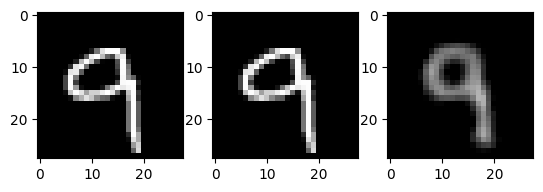

Train Epoch: 20 [0/60000 (0%)]	Loss: 16603.277344
Train Epoch: 20 [1024/60000 (2%)]	Loss: 16721.464844
Train Epoch: 20 [2048/60000 (3%)]	Loss: 16848.638672
Train Epoch: 20 [3072/60000 (5%)]	Loss: 16710.603516
Train Epoch: 20 [4096/60000 (7%)]	Loss: 16994.693359
Train Epoch: 20 [5120/60000 (8%)]	Loss: 16696.101562
Train Epoch: 20 [6144/60000 (10%)]	Loss: 16694.453125
Train Epoch: 20 [7168/60000 (12%)]	Loss: 17206.566406
Train Epoch: 20 [8192/60000 (14%)]	Loss: 16767.238281
Train Epoch: 20 [9216/60000 (15%)]	Loss: 16872.468750
Train Epoch: 20 [10240/60000 (17%)]	Loss: 16774.019531
Train Epoch: 20 [11264/60000 (19%)]	Loss: 16835.929688
Train Epoch: 20 [12288/60000 (20%)]	Loss: 16762.941406
Train Epoch: 20 [13312/60000 (22%)]	Loss: 16703.248047
Train Epoch: 20 [14336/60000 (24%)]	Loss: 16500.335938
Train Epoch: 20 [15360/60000 (25%)]	Loss: 16957.617188
Train Epoch: 20 [16384/60000 (27%)]	Loss: 16686.242188
Train Epoch: 20 [17408/60000 (29%)]	Loss: 17117.982422
Train Epoch: 20 [18432/60000 

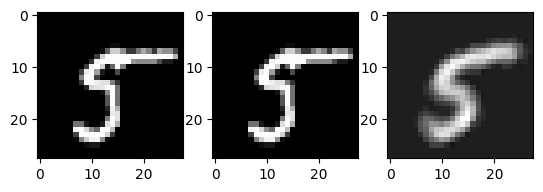

Train Epoch: 21 [0/60000 (0%)]	Loss: 17416.597656
Train Epoch: 21 [1024/60000 (2%)]	Loss: 16859.605469
Train Epoch: 21 [2048/60000 (3%)]	Loss: 17074.582031
Train Epoch: 21 [3072/60000 (5%)]	Loss: 17140.347656
Train Epoch: 21 [4096/60000 (7%)]	Loss: 16795.869141
Train Epoch: 21 [5120/60000 (8%)]	Loss: 16937.390625
Train Epoch: 21 [6144/60000 (10%)]	Loss: 16895.230469
Train Epoch: 21 [7168/60000 (12%)]	Loss: 16775.617188
Train Epoch: 21 [8192/60000 (14%)]	Loss: 16710.417969
Train Epoch: 21 [9216/60000 (15%)]	Loss: 16569.882812
Train Epoch: 21 [10240/60000 (17%)]	Loss: 16934.638672
Train Epoch: 21 [11264/60000 (19%)]	Loss: 16597.464844
Train Epoch: 21 [12288/60000 (20%)]	Loss: 16767.085938
Train Epoch: 21 [13312/60000 (22%)]	Loss: 16360.923828
Train Epoch: 21 [14336/60000 (24%)]	Loss: 16964.183594
Train Epoch: 21 [15360/60000 (25%)]	Loss: 16754.925781
Train Epoch: 21 [16384/60000 (27%)]	Loss: 17136.726562
Train Epoch: 21 [17408/60000 (29%)]	Loss: 16481.583984
Train Epoch: 21 [18432/60000 

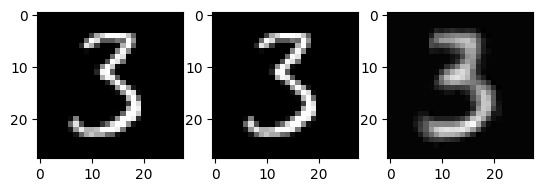

New best! Saving...
Train Epoch: 22 [0/60000 (0%)]	Loss: 16213.088867
Train Epoch: 22 [1024/60000 (2%)]	Loss: 16586.847656
Train Epoch: 22 [2048/60000 (3%)]	Loss: 17077.968750
Train Epoch: 22 [3072/60000 (5%)]	Loss: 17116.949219
Train Epoch: 22 [4096/60000 (7%)]	Loss: 16614.988281
Train Epoch: 22 [5120/60000 (8%)]	Loss: 16574.113281
Train Epoch: 22 [6144/60000 (10%)]	Loss: 16571.769531
Train Epoch: 22 [7168/60000 (12%)]	Loss: 17049.064453
Train Epoch: 22 [8192/60000 (14%)]	Loss: 16749.144531
Train Epoch: 22 [9216/60000 (15%)]	Loss: 16633.523438
Train Epoch: 22 [10240/60000 (17%)]	Loss: 16957.859375
Train Epoch: 22 [11264/60000 (19%)]	Loss: 16512.464844
Train Epoch: 22 [12288/60000 (20%)]	Loss: 16978.849609
Train Epoch: 22 [13312/60000 (22%)]	Loss: 17135.310547
Train Epoch: 22 [14336/60000 (24%)]	Loss: 17007.990234
Train Epoch: 22 [15360/60000 (25%)]	Loss: 16968.910156
Train Epoch: 22 [16384/60000 (27%)]	Loss: 16034.839844
Train Epoch: 22 [17408/60000 (29%)]	Loss: 16603.710938
Train Epo

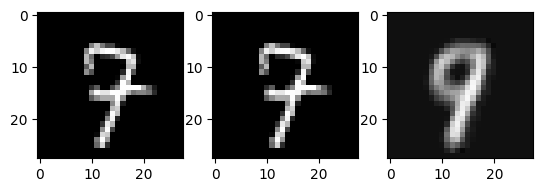

Train Epoch: 23 [0/60000 (0%)]	Loss: 16673.347656
Train Epoch: 23 [1024/60000 (2%)]	Loss: 16780.654297
Train Epoch: 23 [2048/60000 (3%)]	Loss: 16611.263672
Train Epoch: 23 [3072/60000 (5%)]	Loss: 16786.492188
Train Epoch: 23 [4096/60000 (7%)]	Loss: 16388.562500
Train Epoch: 23 [5120/60000 (8%)]	Loss: 16708.636719
Train Epoch: 23 [6144/60000 (10%)]	Loss: 16747.488281
Train Epoch: 23 [7168/60000 (12%)]	Loss: 16863.974609
Train Epoch: 23 [8192/60000 (14%)]	Loss: 16294.763672
Train Epoch: 23 [9216/60000 (15%)]	Loss: 16643.324219
Train Epoch: 23 [10240/60000 (17%)]	Loss: 16752.541016
Train Epoch: 23 [11264/60000 (19%)]	Loss: 16454.398438
Train Epoch: 23 [12288/60000 (20%)]	Loss: 16443.839844
Train Epoch: 23 [13312/60000 (22%)]	Loss: 16217.185547
Train Epoch: 23 [14336/60000 (24%)]	Loss: 16778.589844
Train Epoch: 23 [15360/60000 (25%)]	Loss: 17120.826172
Train Epoch: 23 [16384/60000 (27%)]	Loss: 17303.121094
Train Epoch: 23 [17408/60000 (29%)]	Loss: 16810.095703
Train Epoch: 23 [18432/60000 

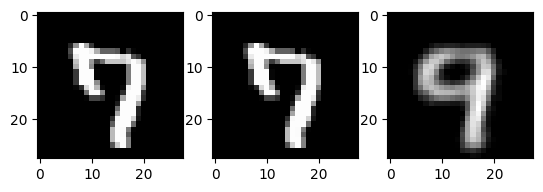

New best! Saving...
Train Epoch: 24 [0/60000 (0%)]	Loss: 16725.716797
Train Epoch: 24 [1024/60000 (2%)]	Loss: 17018.644531
Train Epoch: 24 [2048/60000 (3%)]	Loss: 16499.337891
Train Epoch: 24 [3072/60000 (5%)]	Loss: 16421.785156
Train Epoch: 24 [4096/60000 (7%)]	Loss: 17090.035156
Train Epoch: 24 [5120/60000 (8%)]	Loss: 16642.941406
Train Epoch: 24 [6144/60000 (10%)]	Loss: 16836.935547
Train Epoch: 24 [7168/60000 (12%)]	Loss: 16410.404297
Train Epoch: 24 [8192/60000 (14%)]	Loss: 17025.093750
Train Epoch: 24 [9216/60000 (15%)]	Loss: 16386.886719
Train Epoch: 24 [10240/60000 (17%)]	Loss: 16731.222656
Train Epoch: 24 [11264/60000 (19%)]	Loss: 16283.545898
Train Epoch: 24 [12288/60000 (20%)]	Loss: 16708.523438
Train Epoch: 24 [13312/60000 (22%)]	Loss: 16534.855469
Train Epoch: 24 [14336/60000 (24%)]	Loss: 16887.060547
Train Epoch: 24 [15360/60000 (25%)]	Loss: 16669.644531
Train Epoch: 24 [16384/60000 (27%)]	Loss: 16766.390625
Train Epoch: 24 [17408/60000 (29%)]	Loss: 16710.214844
Train Epo

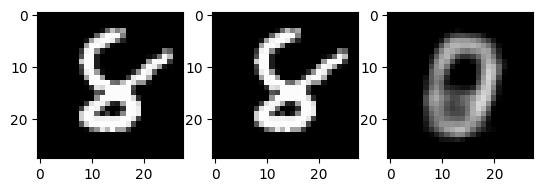

Train Epoch: 25 [0/60000 (0%)]	Loss: 16698.865234
Train Epoch: 25 [1024/60000 (2%)]	Loss: 16848.119141
Train Epoch: 25 [2048/60000 (3%)]	Loss: 16730.203125
Train Epoch: 25 [3072/60000 (5%)]	Loss: 17005.980469
Train Epoch: 25 [4096/60000 (7%)]	Loss: 16667.273438
Train Epoch: 25 [5120/60000 (8%)]	Loss: 16508.226562
Train Epoch: 25 [6144/60000 (10%)]	Loss: 16671.417969
Train Epoch: 25 [7168/60000 (12%)]	Loss: 16169.047852
Train Epoch: 25 [8192/60000 (14%)]	Loss: 16494.259766
Train Epoch: 25 [9216/60000 (15%)]	Loss: 16976.335938
Train Epoch: 25 [10240/60000 (17%)]	Loss: 16629.339844
Train Epoch: 25 [11264/60000 (19%)]	Loss: 16417.724609
Train Epoch: 25 [12288/60000 (20%)]	Loss: 16470.988281
Train Epoch: 25 [13312/60000 (22%)]	Loss: 16624.291016
Train Epoch: 25 [14336/60000 (24%)]	Loss: 16636.998047
Train Epoch: 25 [15360/60000 (25%)]	Loss: 16290.693359
Train Epoch: 25 [16384/60000 (27%)]	Loss: 16772.054688
Train Epoch: 25 [17408/60000 (29%)]	Loss: 16874.507812
Train Epoch: 25 [18432/60000 

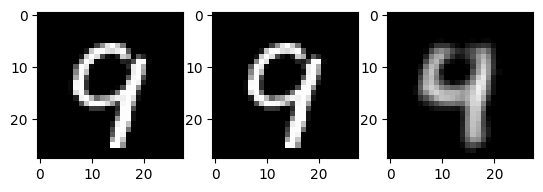

Train Epoch: 26 [0/60000 (0%)]	Loss: 16909.230469
Train Epoch: 26 [1024/60000 (2%)]	Loss: 16904.798828
Train Epoch: 26 [2048/60000 (3%)]	Loss: 16172.785156
Train Epoch: 26 [3072/60000 (5%)]	Loss: 16736.470703
Train Epoch: 26 [4096/60000 (7%)]	Loss: 16655.119141
Train Epoch: 26 [5120/60000 (8%)]	Loss: 16543.396484
Train Epoch: 26 [6144/60000 (10%)]	Loss: 16836.859375
Train Epoch: 26 [7168/60000 (12%)]	Loss: 16046.486328
Train Epoch: 26 [8192/60000 (14%)]	Loss: 16718.578125
Train Epoch: 26 [9216/60000 (15%)]	Loss: 16530.554688
Train Epoch: 26 [10240/60000 (17%)]	Loss: 16703.369141
Train Epoch: 26 [11264/60000 (19%)]	Loss: 16653.164062
Train Epoch: 26 [12288/60000 (20%)]	Loss: 16932.595703
Train Epoch: 26 [13312/60000 (22%)]	Loss: 16509.214844
Train Epoch: 26 [14336/60000 (24%)]	Loss: 16609.638672
Train Epoch: 26 [15360/60000 (25%)]	Loss: 16485.033203
Train Epoch: 26 [16384/60000 (27%)]	Loss: 16514.507812
Train Epoch: 26 [17408/60000 (29%)]	Loss: 16487.562500
Train Epoch: 26 [18432/60000 

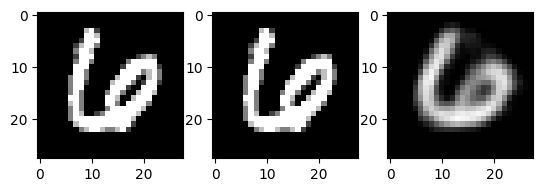

New best! Saving...
Train Epoch: 27 [0/60000 (0%)]	Loss: 17475.662109
Train Epoch: 27 [1024/60000 (2%)]	Loss: 16618.132812
Train Epoch: 27 [2048/60000 (3%)]	Loss: 16630.941406
Train Epoch: 27 [3072/60000 (5%)]	Loss: 16601.085938
Train Epoch: 27 [4096/60000 (7%)]	Loss: 16697.082031
Train Epoch: 27 [5120/60000 (8%)]	Loss: 16623.730469
Train Epoch: 27 [6144/60000 (10%)]	Loss: 16757.812500
Train Epoch: 27 [7168/60000 (12%)]	Loss: 16593.648438
Train Epoch: 27 [8192/60000 (14%)]	Loss: 16643.285156
Train Epoch: 27 [9216/60000 (15%)]	Loss: 16330.608398
Train Epoch: 27 [10240/60000 (17%)]	Loss: 16495.738281
Train Epoch: 27 [11264/60000 (19%)]	Loss: 16135.196289
Train Epoch: 27 [12288/60000 (20%)]	Loss: 16668.066406
Train Epoch: 27 [13312/60000 (22%)]	Loss: 16719.447266
Train Epoch: 27 [14336/60000 (24%)]	Loss: 16817.515625
Train Epoch: 27 [15360/60000 (25%)]	Loss: 16818.441406
Train Epoch: 27 [16384/60000 (27%)]	Loss: 16212.099609
Train Epoch: 27 [17408/60000 (29%)]	Loss: 16742.009766
Train Epo

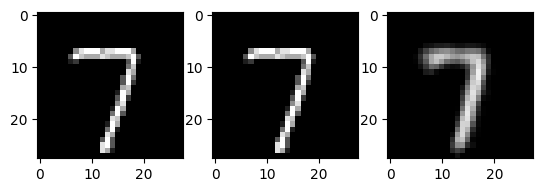

Train Epoch: 28 [0/60000 (0%)]	Loss: 16736.923828
Train Epoch: 28 [1024/60000 (2%)]	Loss: 16553.789062
Train Epoch: 28 [2048/60000 (3%)]	Loss: 16318.496094
Train Epoch: 28 [3072/60000 (5%)]	Loss: 16768.427734
Train Epoch: 28 [4096/60000 (7%)]	Loss: 16765.927734
Train Epoch: 28 [5120/60000 (8%)]	Loss: 16541.351562
Train Epoch: 28 [6144/60000 (10%)]	Loss: 16488.583984
Train Epoch: 28 [7168/60000 (12%)]	Loss: 16780.951172
Train Epoch: 28 [8192/60000 (14%)]	Loss: 16389.089844
Train Epoch: 28 [9216/60000 (15%)]	Loss: 16559.273438
Train Epoch: 28 [10240/60000 (17%)]	Loss: 16563.738281
Train Epoch: 28 [11264/60000 (19%)]	Loss: 16648.750000
Train Epoch: 28 [12288/60000 (20%)]	Loss: 16517.503906
Train Epoch: 28 [13312/60000 (22%)]	Loss: 17024.826172
Train Epoch: 28 [14336/60000 (24%)]	Loss: 16745.080078
Train Epoch: 28 [15360/60000 (25%)]	Loss: 17160.892578
Train Epoch: 28 [16384/60000 (27%)]	Loss: 16394.664062
Train Epoch: 28 [17408/60000 (29%)]	Loss: 16743.939453
Train Epoch: 28 [18432/60000 

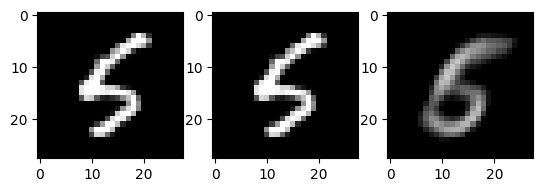

Train Epoch: 29 [0/60000 (0%)]	Loss: 16822.683594
Train Epoch: 29 [1024/60000 (2%)]	Loss: 16821.191406
Train Epoch: 29 [2048/60000 (3%)]	Loss: 16404.742188
Train Epoch: 29 [3072/60000 (5%)]	Loss: 16591.886719
Train Epoch: 29 [4096/60000 (7%)]	Loss: 16626.326172
Train Epoch: 29 [5120/60000 (8%)]	Loss: 16727.160156
Train Epoch: 29 [6144/60000 (10%)]	Loss: 16898.283203
Train Epoch: 29 [7168/60000 (12%)]	Loss: 16630.742188
Train Epoch: 29 [8192/60000 (14%)]	Loss: 16377.634766
Train Epoch: 29 [9216/60000 (15%)]	Loss: 16913.892578
Train Epoch: 29 [10240/60000 (17%)]	Loss: 16674.222656
Train Epoch: 29 [11264/60000 (19%)]	Loss: 16697.464844
Train Epoch: 29 [12288/60000 (20%)]	Loss: 17024.818359
Train Epoch: 29 [13312/60000 (22%)]	Loss: 16745.240234
Train Epoch: 29 [14336/60000 (24%)]	Loss: 16657.199219
Train Epoch: 29 [15360/60000 (25%)]	Loss: 17212.570312
Train Epoch: 29 [16384/60000 (27%)]	Loss: 16430.283203
Train Epoch: 29 [17408/60000 (29%)]	Loss: 17246.751953
Train Epoch: 29 [18432/60000 

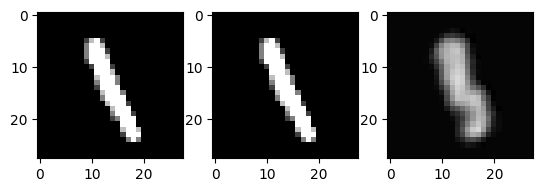

Train Epoch: 30 [0/60000 (0%)]	Loss: 16161.256836
Train Epoch: 30 [1024/60000 (2%)]	Loss: 16381.452148
Train Epoch: 30 [2048/60000 (3%)]	Loss: 16179.919922
Train Epoch: 30 [3072/60000 (5%)]	Loss: 17222.060547
Train Epoch: 30 [4096/60000 (7%)]	Loss: 16297.449219
Train Epoch: 30 [5120/60000 (8%)]	Loss: 16476.345703
Train Epoch: 30 [6144/60000 (10%)]	Loss: 16472.335938
Train Epoch: 30 [7168/60000 (12%)]	Loss: 16829.337891
Train Epoch: 30 [8192/60000 (14%)]	Loss: 16219.470703
Train Epoch: 30 [9216/60000 (15%)]	Loss: 16344.166016
Train Epoch: 30 [10240/60000 (17%)]	Loss: 16481.738281
Train Epoch: 30 [11264/60000 (19%)]	Loss: 16761.611328
Train Epoch: 30 [12288/60000 (20%)]	Loss: 16793.656250
Train Epoch: 30 [13312/60000 (22%)]	Loss: 16461.828125
Train Epoch: 30 [14336/60000 (24%)]	Loss: 17093.685547
Train Epoch: 30 [15360/60000 (25%)]	Loss: 16397.453125
Train Epoch: 30 [16384/60000 (27%)]	Loss: 16608.023438
Train Epoch: 30 [17408/60000 (29%)]	Loss: 16714.677734
Train Epoch: 30 [18432/60000 

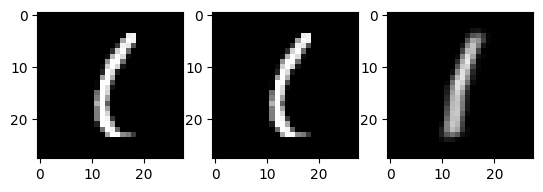

Train Epoch: 31 [0/60000 (0%)]	Loss: 16403.117188
Train Epoch: 31 [1024/60000 (2%)]	Loss: 16447.121094
Train Epoch: 31 [2048/60000 (3%)]	Loss: 16547.789062
Train Epoch: 31 [3072/60000 (5%)]	Loss: 16836.962891
Train Epoch: 31 [4096/60000 (7%)]	Loss: 16726.984375
Train Epoch: 31 [5120/60000 (8%)]	Loss: 16471.738281
Train Epoch: 31 [6144/60000 (10%)]	Loss: 16866.636719
Train Epoch: 31 [7168/60000 (12%)]	Loss: 16791.914062
Train Epoch: 31 [8192/60000 (14%)]	Loss: 16180.941406
Train Epoch: 31 [9216/60000 (15%)]	Loss: 16739.685547
Train Epoch: 31 [10240/60000 (17%)]	Loss: 16841.503906
Train Epoch: 31 [11264/60000 (19%)]	Loss: 16137.446289
Train Epoch: 31 [12288/60000 (20%)]	Loss: 16782.308594
Train Epoch: 31 [13312/60000 (22%)]	Loss: 16312.391602
Train Epoch: 31 [14336/60000 (24%)]	Loss: 16362.699219
Train Epoch: 31 [15360/60000 (25%)]	Loss: 16472.597656
Train Epoch: 31 [16384/60000 (27%)]	Loss: 16743.953125
Train Epoch: 31 [17408/60000 (29%)]	Loss: 16670.175781
Train Epoch: 31 [18432/60000 

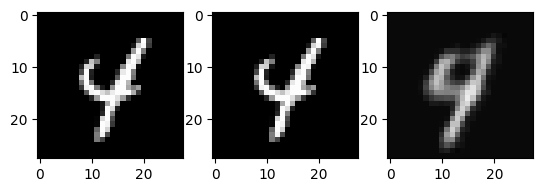

Train Epoch: 32 [0/60000 (0%)]	Loss: 16967.636719
Train Epoch: 32 [1024/60000 (2%)]	Loss: 16604.654297
Train Epoch: 32 [2048/60000 (3%)]	Loss: 16258.701172
Train Epoch: 32 [3072/60000 (5%)]	Loss: 16679.923828
Train Epoch: 32 [4096/60000 (7%)]	Loss: 17009.054688
Train Epoch: 32 [5120/60000 (8%)]	Loss: 16541.236328
Train Epoch: 32 [6144/60000 (10%)]	Loss: 16931.917969
Train Epoch: 32 [7168/60000 (12%)]	Loss: 16356.072266
Train Epoch: 32 [8192/60000 (14%)]	Loss: 16769.068359
Train Epoch: 32 [9216/60000 (15%)]	Loss: 16161.042969
Train Epoch: 32 [10240/60000 (17%)]	Loss: 16789.025391
Train Epoch: 32 [11264/60000 (19%)]	Loss: 16276.716797
Train Epoch: 32 [12288/60000 (20%)]	Loss: 16709.744141
Train Epoch: 32 [13312/60000 (22%)]	Loss: 16521.761719
Train Epoch: 32 [14336/60000 (24%)]	Loss: 16854.466797
Train Epoch: 32 [15360/60000 (25%)]	Loss: 16723.912109
Train Epoch: 32 [16384/60000 (27%)]	Loss: 16523.902344
Train Epoch: 32 [17408/60000 (29%)]	Loss: 16800.414062
Train Epoch: 32 [18432/60000 

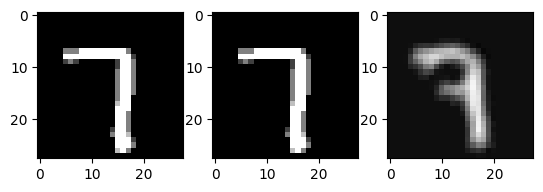

Train Epoch: 33 [0/60000 (0%)]	Loss: 16572.929688
Train Epoch: 33 [1024/60000 (2%)]	Loss: 16583.240234
Train Epoch: 33 [2048/60000 (3%)]	Loss: 16481.746094
Train Epoch: 33 [3072/60000 (5%)]	Loss: 16440.121094
Train Epoch: 33 [4096/60000 (7%)]	Loss: 16536.013672
Train Epoch: 33 [5120/60000 (8%)]	Loss: 16242.858398
Train Epoch: 33 [6144/60000 (10%)]	Loss: 16267.943359
Train Epoch: 33 [7168/60000 (12%)]	Loss: 17211.937500
Train Epoch: 33 [8192/60000 (14%)]	Loss: 16662.726562
Train Epoch: 33 [9216/60000 (15%)]	Loss: 16733.972656
Train Epoch: 33 [10240/60000 (17%)]	Loss: 16625.132812
Train Epoch: 33 [11264/60000 (19%)]	Loss: 16674.757812
Train Epoch: 33 [12288/60000 (20%)]	Loss: 16211.907227
Train Epoch: 33 [13312/60000 (22%)]	Loss: 16334.865234
Train Epoch: 33 [14336/60000 (24%)]	Loss: 15965.542969
Train Epoch: 33 [15360/60000 (25%)]	Loss: 16252.412109
Train Epoch: 33 [16384/60000 (27%)]	Loss: 16197.271484
Train Epoch: 33 [17408/60000 (29%)]	Loss: 16784.865234
Train Epoch: 33 [18432/60000 

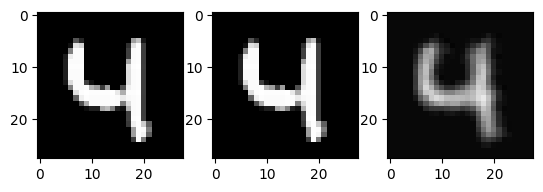

Train Epoch: 34 [0/60000 (0%)]	Loss: 16809.332031
Train Epoch: 34 [1024/60000 (2%)]	Loss: 15858.287109
Train Epoch: 34 [2048/60000 (3%)]	Loss: 16502.001953
Train Epoch: 34 [3072/60000 (5%)]	Loss: 16668.537109
Train Epoch: 34 [4096/60000 (7%)]	Loss: 16516.248047
Train Epoch: 34 [5120/60000 (8%)]	Loss: 16415.347656
Train Epoch: 34 [6144/60000 (10%)]	Loss: 16199.950195
Train Epoch: 34 [7168/60000 (12%)]	Loss: 16746.710938
Train Epoch: 34 [8192/60000 (14%)]	Loss: 16798.681641
Train Epoch: 34 [9216/60000 (15%)]	Loss: 16916.507812
Train Epoch: 34 [10240/60000 (17%)]	Loss: 16686.347656
Train Epoch: 34 [11264/60000 (19%)]	Loss: 16495.777344
Train Epoch: 34 [12288/60000 (20%)]	Loss: 16475.181641
Train Epoch: 34 [13312/60000 (22%)]	Loss: 16495.175781
Train Epoch: 34 [14336/60000 (24%)]	Loss: 16144.808594
Train Epoch: 34 [15360/60000 (25%)]	Loss: 16748.234375
Train Epoch: 34 [16384/60000 (27%)]	Loss: 16620.226562
Train Epoch: 34 [17408/60000 (29%)]	Loss: 16573.726562
Train Epoch: 34 [18432/60000 

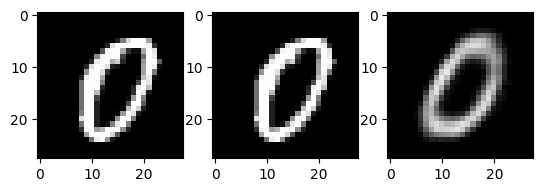

New best! Saving...
Train Epoch: 35 [0/60000 (0%)]	Loss: 16576.957031
Train Epoch: 35 [1024/60000 (2%)]	Loss: 16048.318359
Train Epoch: 35 [2048/60000 (3%)]	Loss: 16161.396484
Train Epoch: 35 [3072/60000 (5%)]	Loss: 16205.770508
Train Epoch: 35 [4096/60000 (7%)]	Loss: 16091.302734
Train Epoch: 35 [5120/60000 (8%)]	Loss: 16372.577148
Train Epoch: 35 [6144/60000 (10%)]	Loss: 17094.343750
Train Epoch: 35 [7168/60000 (12%)]	Loss: 16350.395508
Train Epoch: 35 [8192/60000 (14%)]	Loss: 16508.197266
Train Epoch: 35 [9216/60000 (15%)]	Loss: 16390.468750
Train Epoch: 35 [10240/60000 (17%)]	Loss: 16366.781250
Train Epoch: 35 [11264/60000 (19%)]	Loss: 16262.783203
Train Epoch: 35 [12288/60000 (20%)]	Loss: 16550.070312
Train Epoch: 35 [13312/60000 (22%)]	Loss: 16942.978516
Train Epoch: 35 [14336/60000 (24%)]	Loss: 16763.658203
Train Epoch: 35 [15360/60000 (25%)]	Loss: 16807.546875
Train Epoch: 35 [16384/60000 (27%)]	Loss: 16687.957031
Train Epoch: 35 [17408/60000 (29%)]	Loss: 16722.078125
Train Epo

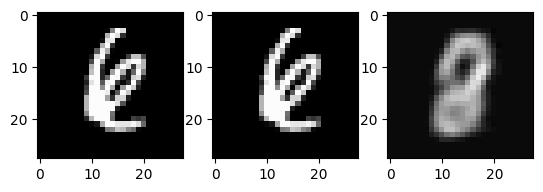

Train Epoch: 36 [0/60000 (0%)]	Loss: 16577.751953
Train Epoch: 36 [1024/60000 (2%)]	Loss: 16735.039062
Train Epoch: 36 [2048/60000 (3%)]	Loss: 15752.125977
Train Epoch: 36 [3072/60000 (5%)]	Loss: 16558.269531
Train Epoch: 36 [4096/60000 (7%)]	Loss: 16230.378906
Train Epoch: 36 [5120/60000 (8%)]	Loss: 16548.156250
Train Epoch: 36 [6144/60000 (10%)]	Loss: 16296.542969
Train Epoch: 36 [7168/60000 (12%)]	Loss: 16617.523438
Train Epoch: 36 [8192/60000 (14%)]	Loss: 16229.048828
Train Epoch: 36 [9216/60000 (15%)]	Loss: 16380.548828
Train Epoch: 36 [10240/60000 (17%)]	Loss: 16388.605469
Train Epoch: 36 [11264/60000 (19%)]	Loss: 16456.460938
Train Epoch: 36 [12288/60000 (20%)]	Loss: 17018.896484
Train Epoch: 36 [13312/60000 (22%)]	Loss: 16776.662109
Train Epoch: 36 [14336/60000 (24%)]	Loss: 16733.386719
Train Epoch: 36 [15360/60000 (25%)]	Loss: 16655.203125
Train Epoch: 36 [16384/60000 (27%)]	Loss: 16614.494141
Train Epoch: 36 [17408/60000 (29%)]	Loss: 16207.621094
Train Epoch: 36 [18432/60000 

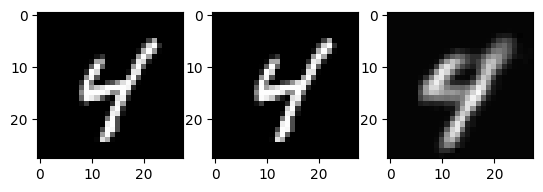

Train Epoch: 37 [0/60000 (0%)]	Loss: 16517.128906
Train Epoch: 37 [1024/60000 (2%)]	Loss: 16260.216797
Train Epoch: 37 [2048/60000 (3%)]	Loss: 16787.074219
Train Epoch: 37 [3072/60000 (5%)]	Loss: 16351.791992
Train Epoch: 37 [4096/60000 (7%)]	Loss: 16860.185547
Train Epoch: 37 [5120/60000 (8%)]	Loss: 16241.800781
Train Epoch: 37 [6144/60000 (10%)]	Loss: 16823.615234
Train Epoch: 37 [7168/60000 (12%)]	Loss: 16687.843750
Train Epoch: 37 [8192/60000 (14%)]	Loss: 16191.031250
Train Epoch: 37 [9216/60000 (15%)]	Loss: 16469.822266
Train Epoch: 37 [10240/60000 (17%)]	Loss: 15950.306641
Train Epoch: 37 [11264/60000 (19%)]	Loss: 16538.824219
Train Epoch: 37 [12288/60000 (20%)]	Loss: 16506.242188
Train Epoch: 37 [13312/60000 (22%)]	Loss: 16155.865234
Train Epoch: 37 [14336/60000 (24%)]	Loss: 16557.230469
Train Epoch: 37 [15360/60000 (25%)]	Loss: 16473.425781
Train Epoch: 37 [16384/60000 (27%)]	Loss: 16531.617188
Train Epoch: 37 [17408/60000 (29%)]	Loss: 16512.761719
Train Epoch: 37 [18432/60000 

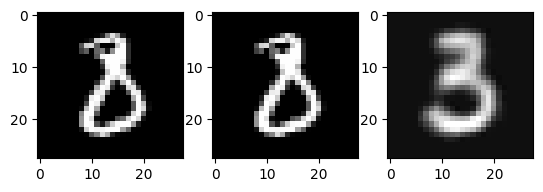

Train Epoch: 38 [0/60000 (0%)]	Loss: 16634.628906
Train Epoch: 38 [1024/60000 (2%)]	Loss: 16293.902344
Train Epoch: 38 [2048/60000 (3%)]	Loss: 16317.588867
Train Epoch: 38 [3072/60000 (5%)]	Loss: 16422.023438
Train Epoch: 38 [4096/60000 (7%)]	Loss: 16078.427734
Train Epoch: 38 [5120/60000 (8%)]	Loss: 15798.958984
Train Epoch: 38 [6144/60000 (10%)]	Loss: 16167.873047
Train Epoch: 38 [7168/60000 (12%)]	Loss: 15900.386719
Train Epoch: 38 [8192/60000 (14%)]	Loss: 16428.324219
Train Epoch: 38 [9216/60000 (15%)]	Loss: 16461.974609
Train Epoch: 38 [10240/60000 (17%)]	Loss: 16681.828125
Train Epoch: 38 [11264/60000 (19%)]	Loss: 16615.871094
Train Epoch: 38 [12288/60000 (20%)]	Loss: 16887.880859
Train Epoch: 38 [13312/60000 (22%)]	Loss: 16647.585938
Train Epoch: 38 [14336/60000 (24%)]	Loss: 16329.884766
Train Epoch: 38 [15360/60000 (25%)]	Loss: 16548.830078
Train Epoch: 38 [16384/60000 (27%)]	Loss: 16526.429688
Train Epoch: 38 [17408/60000 (29%)]	Loss: 16519.792969
Train Epoch: 38 [18432/60000 

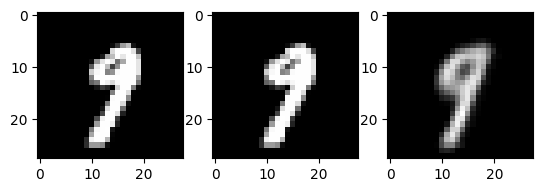

Train Epoch: 39 [0/60000 (0%)]	Loss: 16617.914062
Train Epoch: 39 [1024/60000 (2%)]	Loss: 16579.179688
Train Epoch: 39 [2048/60000 (3%)]	Loss: 16202.299805
Train Epoch: 39 [3072/60000 (5%)]	Loss: 16494.546875
Train Epoch: 39 [4096/60000 (7%)]	Loss: 16311.056641
Train Epoch: 39 [5120/60000 (8%)]	Loss: 16238.888672
Train Epoch: 39 [6144/60000 (10%)]	Loss: 16634.826172
Train Epoch: 39 [7168/60000 (12%)]	Loss: 16578.496094
Train Epoch: 39 [8192/60000 (14%)]	Loss: 16815.886719
Train Epoch: 39 [9216/60000 (15%)]	Loss: 16305.496094
Train Epoch: 39 [10240/60000 (17%)]	Loss: 16767.583984
Train Epoch: 39 [11264/60000 (19%)]	Loss: 16575.476562
Train Epoch: 39 [12288/60000 (20%)]	Loss: 16528.974609
Train Epoch: 39 [13312/60000 (22%)]	Loss: 16210.409180
Train Epoch: 39 [14336/60000 (24%)]	Loss: 16608.115234
Train Epoch: 39 [15360/60000 (25%)]	Loss: 16321.609375
Train Epoch: 39 [16384/60000 (27%)]	Loss: 16699.205078
Train Epoch: 39 [17408/60000 (29%)]	Loss: 16291.468750
Train Epoch: 39 [18432/60000 

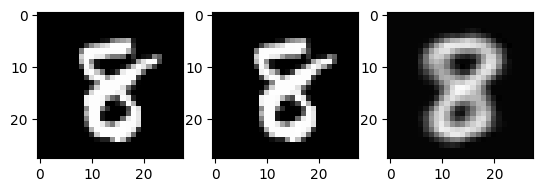

Train Epoch: 40 [0/60000 (0%)]	Loss: 16341.894531
Train Epoch: 40 [1024/60000 (2%)]	Loss: 16432.658203
Train Epoch: 40 [2048/60000 (3%)]	Loss: 16815.160156
Train Epoch: 40 [3072/60000 (5%)]	Loss: 16705.025391
Train Epoch: 40 [4096/60000 (7%)]	Loss: 16355.303711
Train Epoch: 40 [5120/60000 (8%)]	Loss: 16497.289062
Train Epoch: 40 [6144/60000 (10%)]	Loss: 16718.476562
Train Epoch: 40 [7168/60000 (12%)]	Loss: 15934.155273
Train Epoch: 40 [8192/60000 (14%)]	Loss: 16652.005859
Train Epoch: 40 [9216/60000 (15%)]	Loss: 16602.142578
Train Epoch: 40 [10240/60000 (17%)]	Loss: 16727.173828
Train Epoch: 40 [11264/60000 (19%)]	Loss: 16914.617188
Train Epoch: 40 [12288/60000 (20%)]	Loss: 15943.986328
Train Epoch: 40 [13312/60000 (22%)]	Loss: 16100.576172
Train Epoch: 40 [14336/60000 (24%)]	Loss: 15883.845703
Train Epoch: 40 [15360/60000 (25%)]	Loss: 16465.013672
Train Epoch: 40 [16384/60000 (27%)]	Loss: 16465.941406
Train Epoch: 40 [17408/60000 (29%)]	Loss: 16367.378906
Train Epoch: 40 [18432/60000 

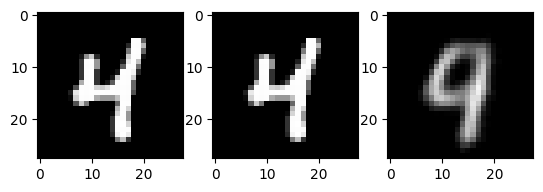

New best! Saving...
Train Epoch: 41 [0/60000 (0%)]	Loss: 17008.115234
Train Epoch: 41 [1024/60000 (2%)]	Loss: 16486.968750
Train Epoch: 41 [2048/60000 (3%)]	Loss: 16777.656250
Train Epoch: 41 [3072/60000 (5%)]	Loss: 16747.957031
Train Epoch: 41 [4096/60000 (7%)]	Loss: 16296.007812
Train Epoch: 41 [5120/60000 (8%)]	Loss: 16380.808594
Train Epoch: 41 [6144/60000 (10%)]	Loss: 15980.998047
Train Epoch: 41 [7168/60000 (12%)]	Loss: 16352.650391
Train Epoch: 41 [8192/60000 (14%)]	Loss: 16221.419922
Train Epoch: 41 [9216/60000 (15%)]	Loss: 16012.310547
Train Epoch: 41 [10240/60000 (17%)]	Loss: 16597.394531
Train Epoch: 41 [11264/60000 (19%)]	Loss: 16208.435547
Train Epoch: 41 [12288/60000 (20%)]	Loss: 16246.187500
Train Epoch: 41 [13312/60000 (22%)]	Loss: 16126.548828
Train Epoch: 41 [14336/60000 (24%)]	Loss: 16343.216797
Train Epoch: 41 [15360/60000 (25%)]	Loss: 16745.050781
Train Epoch: 41 [16384/60000 (27%)]	Loss: 16718.654297
Train Epoch: 41 [17408/60000 (29%)]	Loss: 16194.067383
Train Epo

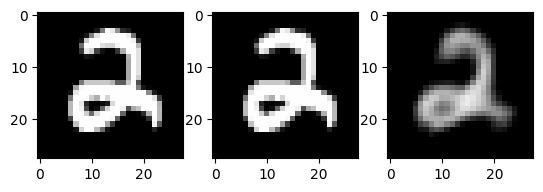

Train Epoch: 42 [0/60000 (0%)]	Loss: 16898.058594
Train Epoch: 42 [1024/60000 (2%)]	Loss: 16540.011719
Train Epoch: 42 [2048/60000 (3%)]	Loss: 16622.218750
Train Epoch: 42 [3072/60000 (5%)]	Loss: 16199.626953
Train Epoch: 42 [4096/60000 (7%)]	Loss: 16872.949219
Train Epoch: 42 [5120/60000 (8%)]	Loss: 16235.552734
Train Epoch: 42 [6144/60000 (10%)]	Loss: 16405.277344
Train Epoch: 42 [7168/60000 (12%)]	Loss: 16438.708984
Train Epoch: 42 [8192/60000 (14%)]	Loss: 16503.498047
Train Epoch: 42 [9216/60000 (15%)]	Loss: 16163.861328
Train Epoch: 42 [10240/60000 (17%)]	Loss: 15887.795898
Train Epoch: 42 [11264/60000 (19%)]	Loss: 16284.968750
Train Epoch: 42 [12288/60000 (20%)]	Loss: 16559.906250
Train Epoch: 42 [13312/60000 (22%)]	Loss: 16554.718750
Train Epoch: 42 [14336/60000 (24%)]	Loss: 15898.087891
Train Epoch: 42 [15360/60000 (25%)]	Loss: 15952.665039
Train Epoch: 42 [16384/60000 (27%)]	Loss: 16494.574219
Train Epoch: 42 [17408/60000 (29%)]	Loss: 16467.154297
Train Epoch: 42 [18432/60000 

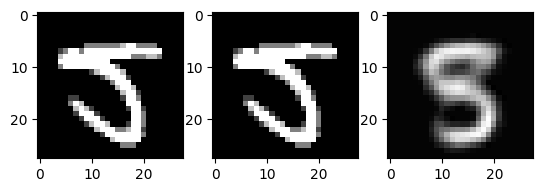

New best! Saving...
Train Epoch: 43 [0/60000 (0%)]	Loss: 16739.296875
Train Epoch: 43 [1024/60000 (2%)]	Loss: 16368.947266
Train Epoch: 43 [2048/60000 (3%)]	Loss: 16366.101562
Train Epoch: 43 [3072/60000 (5%)]	Loss: 16490.925781
Train Epoch: 43 [4096/60000 (7%)]	Loss: 16255.958984
Train Epoch: 43 [5120/60000 (8%)]	Loss: 16374.962891
Train Epoch: 43 [6144/60000 (10%)]	Loss: 16125.106445
Train Epoch: 43 [7168/60000 (12%)]	Loss: 16098.804688
Train Epoch: 43 [8192/60000 (14%)]	Loss: 16144.845703
Train Epoch: 43 [9216/60000 (15%)]	Loss: 16627.414062
Train Epoch: 43 [10240/60000 (17%)]	Loss: 16460.097656
Train Epoch: 43 [11264/60000 (19%)]	Loss: 16845.158203
Train Epoch: 43 [12288/60000 (20%)]	Loss: 16286.280273
Train Epoch: 43 [13312/60000 (22%)]	Loss: 16568.375000
Train Epoch: 43 [14336/60000 (24%)]	Loss: 16457.951172
Train Epoch: 43 [15360/60000 (25%)]	Loss: 16000.710938
Train Epoch: 43 [16384/60000 (27%)]	Loss: 16563.257812
Train Epoch: 43 [17408/60000 (29%)]	Loss: 16415.294922
Train Epo

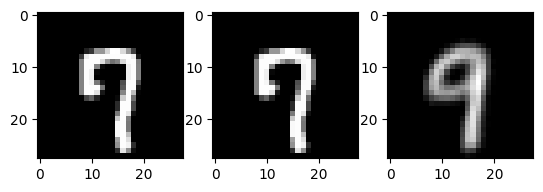

New best! Saving...
Train Epoch: 44 [0/60000 (0%)]	Loss: 16263.946289
Train Epoch: 44 [1024/60000 (2%)]	Loss: 16313.298828
Train Epoch: 44 [2048/60000 (3%)]	Loss: 16123.867188
Train Epoch: 44 [3072/60000 (5%)]	Loss: 16541.953125
Train Epoch: 44 [4096/60000 (7%)]	Loss: 16776.617188
Train Epoch: 44 [5120/60000 (8%)]	Loss: 16280.978516
Train Epoch: 44 [6144/60000 (10%)]	Loss: 16279.894531
Train Epoch: 44 [7168/60000 (12%)]	Loss: 16167.915039
Train Epoch: 44 [8192/60000 (14%)]	Loss: 15784.339844
Train Epoch: 44 [9216/60000 (15%)]	Loss: 16587.320312
Train Epoch: 44 [10240/60000 (17%)]	Loss: 16900.972656
Train Epoch: 44 [11264/60000 (19%)]	Loss: 15780.545898
Train Epoch: 44 [12288/60000 (20%)]	Loss: 16500.064453
Train Epoch: 44 [13312/60000 (22%)]	Loss: 16183.806641
Train Epoch: 44 [14336/60000 (24%)]	Loss: 16213.105469
Train Epoch: 44 [15360/60000 (25%)]	Loss: 16657.097656
Train Epoch: 44 [16384/60000 (27%)]	Loss: 15935.117188
Train Epoch: 44 [17408/60000 (29%)]	Loss: 16777.531250
Train Epo

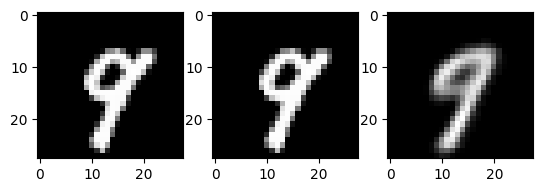

New best! Saving...
Train Epoch: 45 [0/60000 (0%)]	Loss: 16527.166016
Train Epoch: 45 [1024/60000 (2%)]	Loss: 16713.949219
Train Epoch: 45 [2048/60000 (3%)]	Loss: 16240.505859
Train Epoch: 45 [3072/60000 (5%)]	Loss: 16218.069336
Train Epoch: 45 [4096/60000 (7%)]	Loss: 16474.675781
Train Epoch: 45 [5120/60000 (8%)]	Loss: 16015.927734
Train Epoch: 45 [6144/60000 (10%)]	Loss: 16322.800781
Train Epoch: 45 [7168/60000 (12%)]	Loss: 16264.251953
Train Epoch: 45 [8192/60000 (14%)]	Loss: 16250.567383
Train Epoch: 45 [9216/60000 (15%)]	Loss: 15681.190430
Train Epoch: 45 [10240/60000 (17%)]	Loss: 16321.430664
Train Epoch: 45 [11264/60000 (19%)]	Loss: 16175.057617
Train Epoch: 45 [12288/60000 (20%)]	Loss: 16510.302734
Train Epoch: 45 [13312/60000 (22%)]	Loss: 16061.362305
Train Epoch: 45 [14336/60000 (24%)]	Loss: 16015.533203
Train Epoch: 45 [15360/60000 (25%)]	Loss: 16368.088867
Train Epoch: 45 [16384/60000 (27%)]	Loss: 16526.974609
Train Epoch: 45 [17408/60000 (29%)]	Loss: 16471.671875
Train Epo

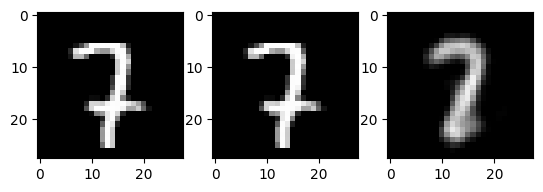

Train Epoch: 46 [0/60000 (0%)]	Loss: 16567.888672
Train Epoch: 46 [1024/60000 (2%)]	Loss: 16160.707031
Train Epoch: 46 [2048/60000 (3%)]	Loss: 16289.317383
Train Epoch: 46 [3072/60000 (5%)]	Loss: 16182.734375
Train Epoch: 46 [4096/60000 (7%)]	Loss: 16327.107422
Train Epoch: 46 [5120/60000 (8%)]	Loss: 16473.679688
Train Epoch: 46 [6144/60000 (10%)]	Loss: 16279.862305
Train Epoch: 46 [7168/60000 (12%)]	Loss: 16828.890625
Train Epoch: 46 [8192/60000 (14%)]	Loss: 16194.486328
Train Epoch: 46 [9216/60000 (15%)]	Loss: 15742.607422
Train Epoch: 46 [10240/60000 (17%)]	Loss: 16111.554688
Train Epoch: 46 [11264/60000 (19%)]	Loss: 16113.607422
Train Epoch: 46 [12288/60000 (20%)]	Loss: 16020.947266
Train Epoch: 46 [13312/60000 (22%)]	Loss: 16295.033203
Train Epoch: 46 [14336/60000 (24%)]	Loss: 17224.347656
Train Epoch: 46 [15360/60000 (25%)]	Loss: 16479.056641
Train Epoch: 46 [16384/60000 (27%)]	Loss: 16251.605469
Train Epoch: 46 [17408/60000 (29%)]	Loss: 16631.718750
Train Epoch: 46 [18432/60000 

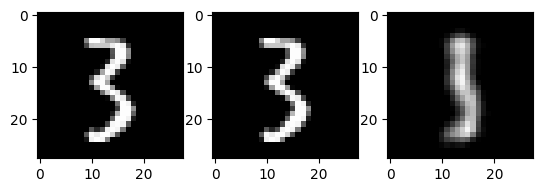

New best! Saving...
Train Epoch: 47 [0/60000 (0%)]	Loss: 16217.539062
Train Epoch: 47 [1024/60000 (2%)]	Loss: 16303.513672
Train Epoch: 47 [2048/60000 (3%)]	Loss: 16295.195312
Train Epoch: 47 [3072/60000 (5%)]	Loss: 16066.851562
Train Epoch: 47 [4096/60000 (7%)]	Loss: 16463.675781
Train Epoch: 47 [5120/60000 (8%)]	Loss: 16015.943359
Train Epoch: 47 [6144/60000 (10%)]	Loss: 15987.712891
Train Epoch: 47 [7168/60000 (12%)]	Loss: 16527.636719
Train Epoch: 47 [8192/60000 (14%)]	Loss: 15966.212891
Train Epoch: 47 [9216/60000 (15%)]	Loss: 16374.973633
Train Epoch: 47 [10240/60000 (17%)]	Loss: 16632.941406
Train Epoch: 47 [11264/60000 (19%)]	Loss: 16374.089844
Train Epoch: 47 [12288/60000 (20%)]	Loss: 15920.331055
Train Epoch: 47 [13312/60000 (22%)]	Loss: 16341.155273
Train Epoch: 47 [14336/60000 (24%)]	Loss: 16460.085938
Train Epoch: 47 [15360/60000 (25%)]	Loss: 16756.314453
Train Epoch: 47 [16384/60000 (27%)]	Loss: 16253.673828
Train Epoch: 47 [17408/60000 (29%)]	Loss: 16693.515625
Train Epo

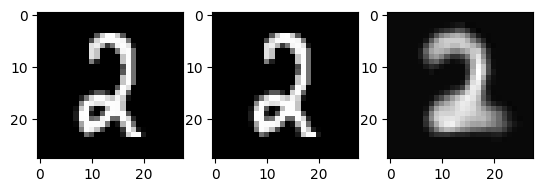

Train Epoch: 48 [0/60000 (0%)]	Loss: 15880.190430
Train Epoch: 48 [1024/60000 (2%)]	Loss: 16362.297852
Train Epoch: 48 [2048/60000 (3%)]	Loss: 15781.234375
Train Epoch: 48 [3072/60000 (5%)]	Loss: 16254.066406
Train Epoch: 48 [4096/60000 (7%)]	Loss: 16446.464844
Train Epoch: 48 [5120/60000 (8%)]	Loss: 16223.314453
Train Epoch: 48 [6144/60000 (10%)]	Loss: 16143.799805
Train Epoch: 48 [7168/60000 (12%)]	Loss: 16495.623047
Train Epoch: 48 [8192/60000 (14%)]	Loss: 16312.298828
Train Epoch: 48 [9216/60000 (15%)]	Loss: 15891.757812
Train Epoch: 48 [10240/60000 (17%)]	Loss: 16401.519531
Train Epoch: 48 [11264/60000 (19%)]	Loss: 16682.910156
Train Epoch: 48 [12288/60000 (20%)]	Loss: 16109.669922
Train Epoch: 48 [13312/60000 (22%)]	Loss: 16552.089844
Train Epoch: 48 [14336/60000 (24%)]	Loss: 16199.688477
Train Epoch: 48 [15360/60000 (25%)]	Loss: 16152.654297
Train Epoch: 48 [16384/60000 (27%)]	Loss: 16175.417969
Train Epoch: 48 [17408/60000 (29%)]	Loss: 16439.414062
Train Epoch: 48 [18432/60000 

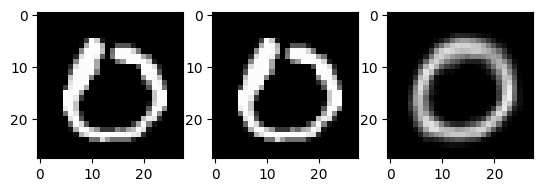

New best! Saving...
Train Epoch: 49 [0/60000 (0%)]	Loss: 15766.652344
Train Epoch: 49 [1024/60000 (2%)]	Loss: 16231.785156
Train Epoch: 49 [2048/60000 (3%)]	Loss: 16086.309570
Train Epoch: 49 [3072/60000 (5%)]	Loss: 16369.411133
Train Epoch: 49 [4096/60000 (7%)]	Loss: 15854.957031
Train Epoch: 49 [5120/60000 (8%)]	Loss: 15770.111328
Train Epoch: 49 [6144/60000 (10%)]	Loss: 16322.520508
Train Epoch: 49 [7168/60000 (12%)]	Loss: 16922.449219
Train Epoch: 49 [8192/60000 (14%)]	Loss: 15943.399414
Train Epoch: 49 [9216/60000 (15%)]	Loss: 16227.814453
Train Epoch: 49 [10240/60000 (17%)]	Loss: 15977.900391
Train Epoch: 49 [11264/60000 (19%)]	Loss: 15887.593750
Train Epoch: 49 [12288/60000 (20%)]	Loss: 16372.063477
Train Epoch: 49 [13312/60000 (22%)]	Loss: 16269.792969
Train Epoch: 49 [14336/60000 (24%)]	Loss: 16298.284180
Train Epoch: 49 [15360/60000 (25%)]	Loss: 16041.567383
Train Epoch: 49 [16384/60000 (27%)]	Loss: 16587.701172
Train Epoch: 49 [17408/60000 (29%)]	Loss: 15999.680664
Train Epo

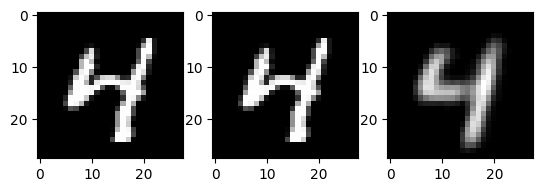

Train Epoch: 50 [0/60000 (0%)]	Loss: 16292.023438
Train Epoch: 50 [1024/60000 (2%)]	Loss: 16585.263672
Train Epoch: 50 [2048/60000 (3%)]	Loss: 16345.981445
Train Epoch: 50 [3072/60000 (5%)]	Loss: 15841.240234
Train Epoch: 50 [4096/60000 (7%)]	Loss: 15963.089844
Train Epoch: 50 [5120/60000 (8%)]	Loss: 16426.402344
Train Epoch: 50 [6144/60000 (10%)]	Loss: 16047.460938
Train Epoch: 50 [7168/60000 (12%)]	Loss: 16261.896484
Train Epoch: 50 [8192/60000 (14%)]	Loss: 16081.840820
Train Epoch: 50 [9216/60000 (15%)]	Loss: 16153.259766
Train Epoch: 50 [10240/60000 (17%)]	Loss: 16089.285156
Train Epoch: 50 [11264/60000 (19%)]	Loss: 16068.987305
Train Epoch: 50 [12288/60000 (20%)]	Loss: 16152.925781
Train Epoch: 50 [13312/60000 (22%)]	Loss: 15964.895508
Train Epoch: 50 [14336/60000 (24%)]	Loss: 16249.177734
Train Epoch: 50 [15360/60000 (25%)]	Loss: 16222.134766
Train Epoch: 50 [16384/60000 (27%)]	Loss: 16273.953125
Train Epoch: 50 [17408/60000 (29%)]	Loss: 15746.548828
Train Epoch: 50 [18432/60000 

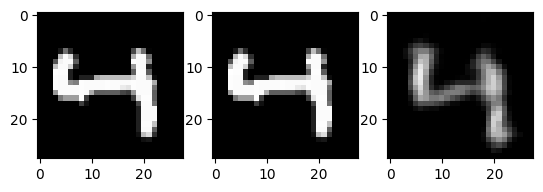

New best! Saving...
Train Epoch: 51 [0/60000 (0%)]	Loss: 16058.273438
Train Epoch: 51 [1024/60000 (2%)]	Loss: 16352.308594
Train Epoch: 51 [2048/60000 (3%)]	Loss: 16289.250000
Train Epoch: 51 [3072/60000 (5%)]	Loss: 16533.570312
Train Epoch: 51 [4096/60000 (7%)]	Loss: 16419.289062
Train Epoch: 51 [5120/60000 (8%)]	Loss: 16565.144531
Train Epoch: 51 [6144/60000 (10%)]	Loss: 16162.303711
Train Epoch: 51 [7168/60000 (12%)]	Loss: 15984.901367
Train Epoch: 51 [8192/60000 (14%)]	Loss: 16315.858398
Train Epoch: 51 [9216/60000 (15%)]	Loss: 15790.044922
Train Epoch: 51 [10240/60000 (17%)]	Loss: 16283.253906
Train Epoch: 51 [11264/60000 (19%)]	Loss: 16185.609375
Train Epoch: 51 [12288/60000 (20%)]	Loss: 16109.043945
Train Epoch: 51 [13312/60000 (22%)]	Loss: 16393.154297
Train Epoch: 51 [14336/60000 (24%)]	Loss: 15742.835938
Train Epoch: 51 [15360/60000 (25%)]	Loss: 16357.096680
Train Epoch: 51 [16384/60000 (27%)]	Loss: 16154.912109
Train Epoch: 51 [17408/60000 (29%)]	Loss: 16054.134766
Train Epo

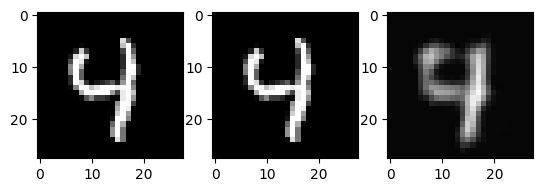

Train Epoch: 52 [0/60000 (0%)]	Loss: 16755.439453
Train Epoch: 52 [1024/60000 (2%)]	Loss: 16090.107422
Train Epoch: 52 [2048/60000 (3%)]	Loss: 16019.179688
Train Epoch: 52 [3072/60000 (5%)]	Loss: 16335.403320
Train Epoch: 52 [4096/60000 (7%)]	Loss: 16201.344727
Train Epoch: 52 [5120/60000 (8%)]	Loss: 16138.283203
Train Epoch: 52 [6144/60000 (10%)]	Loss: 16148.522461
Train Epoch: 52 [7168/60000 (12%)]	Loss: 16351.515625
Train Epoch: 52 [8192/60000 (14%)]	Loss: 16350.125000
Train Epoch: 52 [9216/60000 (15%)]	Loss: 16440.873047
Train Epoch: 52 [10240/60000 (17%)]	Loss: 16647.892578
Train Epoch: 52 [11264/60000 (19%)]	Loss: 16442.400391
Train Epoch: 52 [12288/60000 (20%)]	Loss: 16357.721680
Train Epoch: 52 [13312/60000 (22%)]	Loss: 15789.812500
Train Epoch: 52 [14336/60000 (24%)]	Loss: 16288.674805
Train Epoch: 52 [15360/60000 (25%)]	Loss: 15910.208008
Train Epoch: 52 [16384/60000 (27%)]	Loss: 16269.589844
Train Epoch: 52 [17408/60000 (29%)]	Loss: 17029.757812
Train Epoch: 52 [18432/60000 

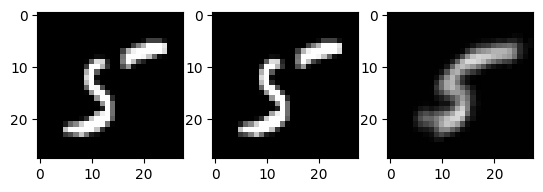

Train Epoch: 53 [0/60000 (0%)]	Loss: 16253.628906
Train Epoch: 53 [1024/60000 (2%)]	Loss: 16403.242188
Train Epoch: 53 [2048/60000 (3%)]	Loss: 15911.461914
Train Epoch: 53 [3072/60000 (5%)]	Loss: 16568.574219
Train Epoch: 53 [4096/60000 (7%)]	Loss: 16424.736328
Train Epoch: 53 [5120/60000 (8%)]	Loss: 16426.421875
Train Epoch: 53 [6144/60000 (10%)]	Loss: 16050.476562
Train Epoch: 53 [7168/60000 (12%)]	Loss: 16201.603516
Train Epoch: 53 [8192/60000 (14%)]	Loss: 16355.547852
Train Epoch: 53 [9216/60000 (15%)]	Loss: 16655.914062
Train Epoch: 53 [10240/60000 (17%)]	Loss: 16143.031250
Train Epoch: 53 [11264/60000 (19%)]	Loss: 16788.873047
Train Epoch: 53 [12288/60000 (20%)]	Loss: 16211.533203
Train Epoch: 53 [13312/60000 (22%)]	Loss: 16360.315430
Train Epoch: 53 [14336/60000 (24%)]	Loss: 16372.023438
Train Epoch: 53 [15360/60000 (25%)]	Loss: 16188.035156
Train Epoch: 53 [16384/60000 (27%)]	Loss: 15937.880859
Train Epoch: 53 [17408/60000 (29%)]	Loss: 16206.429688
Train Epoch: 53 [18432/60000 

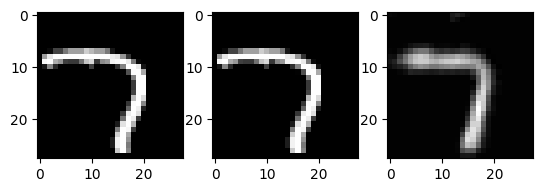

Train Epoch: 54 [0/60000 (0%)]	Loss: 16355.146484
Train Epoch: 54 [1024/60000 (2%)]	Loss: 16572.591797
Train Epoch: 54 [2048/60000 (3%)]	Loss: 16344.949219
Train Epoch: 54 [3072/60000 (5%)]	Loss: 16673.371094
Train Epoch: 54 [4096/60000 (7%)]	Loss: 16050.423828
Train Epoch: 54 [5120/60000 (8%)]	Loss: 16360.781250
Train Epoch: 54 [6144/60000 (10%)]	Loss: 16602.464844
Train Epoch: 54 [7168/60000 (12%)]	Loss: 16080.969727
Train Epoch: 54 [8192/60000 (14%)]	Loss: 16250.521484
Train Epoch: 54 [9216/60000 (15%)]	Loss: 16647.886719
Train Epoch: 54 [10240/60000 (17%)]	Loss: 16353.294922
Train Epoch: 54 [11264/60000 (19%)]	Loss: 15959.707031
Train Epoch: 54 [12288/60000 (20%)]	Loss: 16312.606445
Train Epoch: 54 [13312/60000 (22%)]	Loss: 16318.717773
Train Epoch: 54 [14336/60000 (24%)]	Loss: 16314.116211
Train Epoch: 54 [15360/60000 (25%)]	Loss: 16311.541992
Train Epoch: 54 [16384/60000 (27%)]	Loss: 16077.038086
Train Epoch: 54 [17408/60000 (29%)]	Loss: 15805.831055
Train Epoch: 54 [18432/60000 

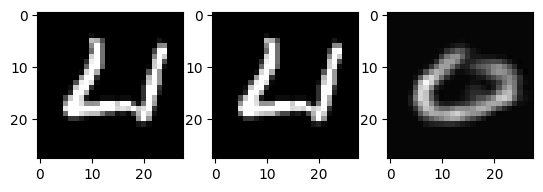

Train Epoch: 55 [0/60000 (0%)]	Loss: 16259.462891
Train Epoch: 55 [1024/60000 (2%)]	Loss: 16104.117188
Train Epoch: 55 [2048/60000 (3%)]	Loss: 16633.779297
Train Epoch: 55 [3072/60000 (5%)]	Loss: 15876.619141
Train Epoch: 55 [4096/60000 (7%)]	Loss: 16439.158203
Train Epoch: 55 [5120/60000 (8%)]	Loss: 16137.819336
Train Epoch: 55 [6144/60000 (10%)]	Loss: 15555.039062
Train Epoch: 55 [7168/60000 (12%)]	Loss: 16339.116211
Train Epoch: 55 [8192/60000 (14%)]	Loss: 16307.759766
Train Epoch: 55 [9216/60000 (15%)]	Loss: 16184.322266
Train Epoch: 55 [10240/60000 (17%)]	Loss: 16118.709961
Train Epoch: 55 [11264/60000 (19%)]	Loss: 16338.447266
Train Epoch: 55 [12288/60000 (20%)]	Loss: 16513.148438
Train Epoch: 55 [13312/60000 (22%)]	Loss: 16446.044922
Train Epoch: 55 [14336/60000 (24%)]	Loss: 15865.864258
Train Epoch: 55 [15360/60000 (25%)]	Loss: 16603.875000
Train Epoch: 55 [16384/60000 (27%)]	Loss: 16235.150391
Train Epoch: 55 [17408/60000 (29%)]	Loss: 16153.009766
Train Epoch: 55 [18432/60000 

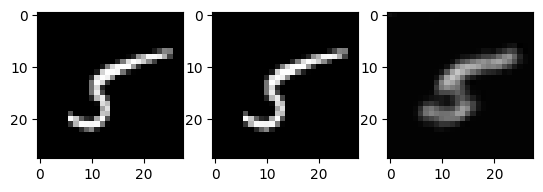

Train Epoch: 56 [0/60000 (0%)]	Loss: 16326.881836
Train Epoch: 56 [1024/60000 (2%)]	Loss: 16499.781250
Train Epoch: 56 [2048/60000 (3%)]	Loss: 16686.554688
Train Epoch: 56 [3072/60000 (5%)]	Loss: 16238.494141
Train Epoch: 56 [4096/60000 (7%)]	Loss: 15869.507812
Train Epoch: 56 [5120/60000 (8%)]	Loss: 15737.384766
Train Epoch: 56 [6144/60000 (10%)]	Loss: 16838.058594
Train Epoch: 56 [7168/60000 (12%)]	Loss: 16137.667969
Train Epoch: 56 [8192/60000 (14%)]	Loss: 16499.130859
Train Epoch: 56 [9216/60000 (15%)]	Loss: 15988.822266
Train Epoch: 56 [10240/60000 (17%)]	Loss: 16651.373047
Train Epoch: 56 [11264/60000 (19%)]	Loss: 16396.019531
Train Epoch: 56 [12288/60000 (20%)]	Loss: 15810.512695
Train Epoch: 56 [13312/60000 (22%)]	Loss: 16269.772461
Train Epoch: 56 [14336/60000 (24%)]	Loss: 16046.360352
Train Epoch: 56 [15360/60000 (25%)]	Loss: 16032.141602
Train Epoch: 56 [16384/60000 (27%)]	Loss: 16336.821289
Train Epoch: 56 [17408/60000 (29%)]	Loss: 16389.765625
Train Epoch: 56 [18432/60000 

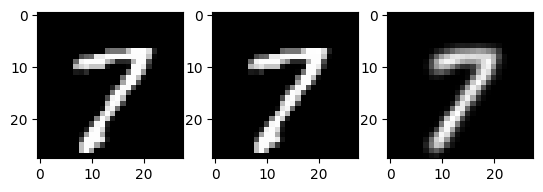

New best! Saving...
Train Epoch: 57 [0/60000 (0%)]	Loss: 16205.740234
Train Epoch: 57 [1024/60000 (2%)]	Loss: 15986.421875
Train Epoch: 57 [2048/60000 (3%)]	Loss: 16771.718750
Train Epoch: 57 [3072/60000 (5%)]	Loss: 16591.890625
Train Epoch: 57 [4096/60000 (7%)]	Loss: 16049.346680
Train Epoch: 57 [5120/60000 (8%)]	Loss: 16295.924805
Train Epoch: 57 [6144/60000 (10%)]	Loss: 16186.087891
Train Epoch: 57 [7168/60000 (12%)]	Loss: 16132.859375
Train Epoch: 57 [8192/60000 (14%)]	Loss: 16365.015625
Train Epoch: 57 [9216/60000 (15%)]	Loss: 16157.049805
Train Epoch: 57 [10240/60000 (17%)]	Loss: 15978.191406
Train Epoch: 57 [11264/60000 (19%)]	Loss: 16296.570312
Train Epoch: 57 [12288/60000 (20%)]	Loss: 16317.831055
Train Epoch: 57 [13312/60000 (22%)]	Loss: 15910.434570
Train Epoch: 57 [14336/60000 (24%)]	Loss: 16593.304688
Train Epoch: 57 [15360/60000 (25%)]	Loss: 16074.230469
Train Epoch: 57 [16384/60000 (27%)]	Loss: 16332.104492
Train Epoch: 57 [17408/60000 (29%)]	Loss: 16003.148438
Train Epo

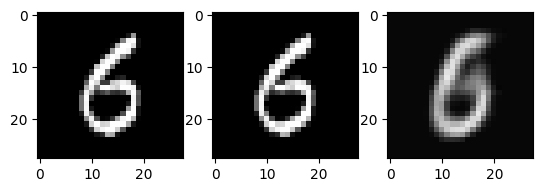

Train Epoch: 58 [0/60000 (0%)]	Loss: 15887.423828
Train Epoch: 58 [1024/60000 (2%)]	Loss: 16045.578125
Train Epoch: 58 [2048/60000 (3%)]	Loss: 16517.125000
Train Epoch: 58 [3072/60000 (5%)]	Loss: 16531.835938
Train Epoch: 58 [4096/60000 (7%)]	Loss: 16161.080078
Train Epoch: 58 [5120/60000 (8%)]	Loss: 16315.429688
Train Epoch: 58 [6144/60000 (10%)]	Loss: 16478.578125
Train Epoch: 58 [7168/60000 (12%)]	Loss: 16018.853516
Train Epoch: 58 [8192/60000 (14%)]	Loss: 16434.367188
Train Epoch: 58 [9216/60000 (15%)]	Loss: 16095.255859
Train Epoch: 58 [10240/60000 (17%)]	Loss: 15853.873047
Train Epoch: 58 [11264/60000 (19%)]	Loss: 16083.232422
Train Epoch: 58 [12288/60000 (20%)]	Loss: 16813.277344
Train Epoch: 58 [13312/60000 (22%)]	Loss: 16088.790039
Train Epoch: 58 [14336/60000 (24%)]	Loss: 15829.632812
Train Epoch: 58 [15360/60000 (25%)]	Loss: 16286.235352
Train Epoch: 58 [16384/60000 (27%)]	Loss: 16310.248047
Train Epoch: 58 [17408/60000 (29%)]	Loss: 16143.821289
Train Epoch: 58 [18432/60000 

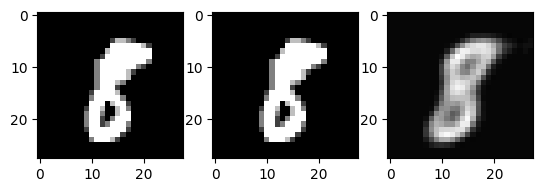

Train Epoch: 59 [0/60000 (0%)]	Loss: 15974.298828
Train Epoch: 59 [1024/60000 (2%)]	Loss: 15940.851562
Train Epoch: 59 [2048/60000 (3%)]	Loss: 15941.017578
Train Epoch: 59 [3072/60000 (5%)]	Loss: 16511.361328
Train Epoch: 59 [4096/60000 (7%)]	Loss: 15909.299805
Train Epoch: 59 [5120/60000 (8%)]	Loss: 16252.561523
Train Epoch: 59 [6144/60000 (10%)]	Loss: 15561.355469
Train Epoch: 59 [7168/60000 (12%)]	Loss: 15960.913086
Train Epoch: 59 [8192/60000 (14%)]	Loss: 16297.239258
Train Epoch: 59 [9216/60000 (15%)]	Loss: 16003.683594
Train Epoch: 59 [10240/60000 (17%)]	Loss: 16056.410156
Train Epoch: 59 [11264/60000 (19%)]	Loss: 16484.246094
Train Epoch: 59 [12288/60000 (20%)]	Loss: 15857.879883
Train Epoch: 59 [13312/60000 (22%)]	Loss: 15980.856445
Train Epoch: 59 [14336/60000 (24%)]	Loss: 16378.565430
Train Epoch: 59 [15360/60000 (25%)]	Loss: 16089.992188
Train Epoch: 59 [16384/60000 (27%)]	Loss: 16356.214844
Train Epoch: 59 [17408/60000 (29%)]	Loss: 16392.837891
Train Epoch: 59 [18432/60000 

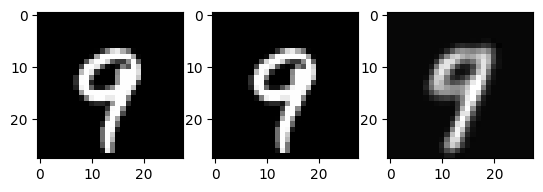

Train Epoch: 60 [0/60000 (0%)]	Loss: 16504.011719
Train Epoch: 60 [1024/60000 (2%)]	Loss: 16808.791016
Train Epoch: 60 [2048/60000 (3%)]	Loss: 16176.074219
Train Epoch: 60 [3072/60000 (5%)]	Loss: 16164.437500
Train Epoch: 60 [4096/60000 (7%)]	Loss: 16375.275391
Train Epoch: 60 [5120/60000 (8%)]	Loss: 16000.847656
Train Epoch: 60 [6144/60000 (10%)]	Loss: 16055.924805
Train Epoch: 60 [7168/60000 (12%)]	Loss: 16195.238281
Train Epoch: 60 [8192/60000 (14%)]	Loss: 16200.593750
Train Epoch: 60 [9216/60000 (15%)]	Loss: 16431.843750
Train Epoch: 60 [10240/60000 (17%)]	Loss: 16611.517578
Train Epoch: 60 [11264/60000 (19%)]	Loss: 16552.931641
Train Epoch: 60 [12288/60000 (20%)]	Loss: 16525.968750
Train Epoch: 60 [13312/60000 (22%)]	Loss: 15900.244141
Train Epoch: 60 [14336/60000 (24%)]	Loss: 16321.258789
Train Epoch: 60 [15360/60000 (25%)]	Loss: 16438.839844
Train Epoch: 60 [16384/60000 (27%)]	Loss: 15580.580078
Train Epoch: 60 [17408/60000 (29%)]	Loss: 16227.205078
Train Epoch: 60 [18432/60000 

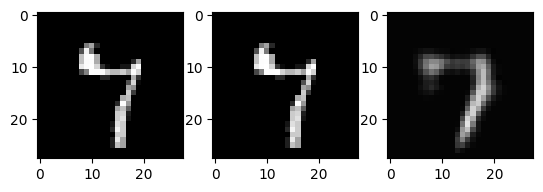

In [ ]:
test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
best=test_losses[-1]
for epoch in range(1, n_epochs + 1):
  train(network, train_loader, epoch, optimizer, loss_fn, log_interval, batch_size_train, train_losses, train_counter)
  test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
  if test_losses[-1] < best:
    best=test_losses[-1]
    print("New best! Saving...")
    torch.save(network.state_dict(), parameters_file)
  scheduler.step()

torch.save((train_counter, train_losses, test_losses), training_data_file)

Best: 16399.052734375


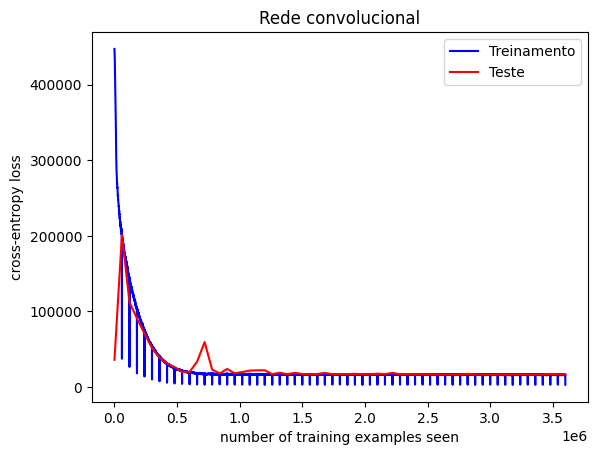

In [15]:
fig = plt.figure()
(train_counter, train_losses, test_losses) = torch.load( training_data_file)

test_counter = [i*len(train_loader.dataset) for i in range(len(test_losses))]
for i in range(len(train_losses)):
  train_losses[i] = train_losses[i]

for i in range(len(test_losses)):
  test_losses[i] = test_losses[i].cpu().detach()

plt.plot(train_counter, train_losses, color='blue', label='Treinamento')
plt.plot(test_counter, test_losses, color='red', label='Teste')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross-entropy loss')
plt.legend()
plt.title("Rede convolucional")

print(f"Best: {min(test_losses)}")

torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([1, 28, 28])


<Figure size 640x480 with 0 Axes>

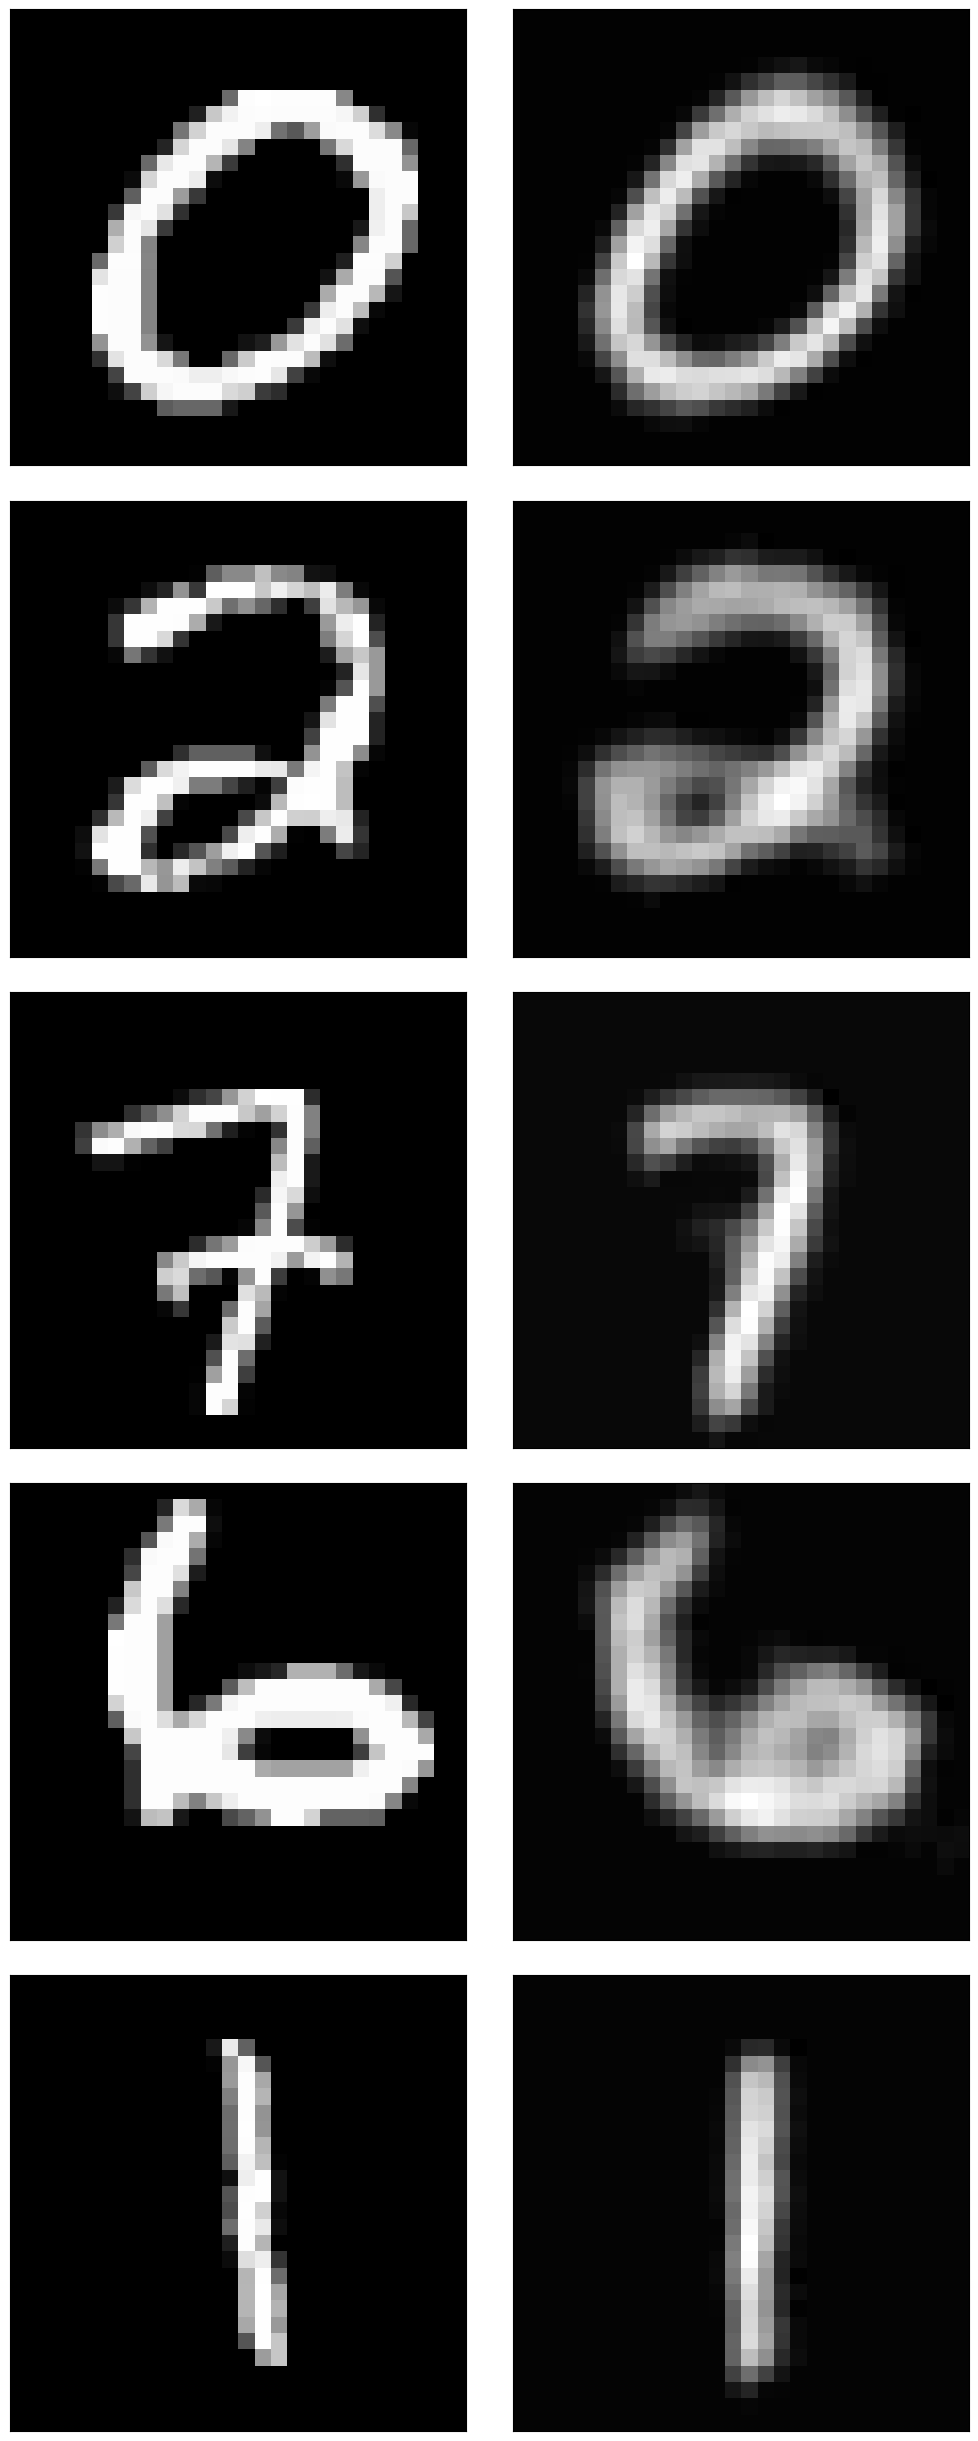

In [17]:

network.load_state_dict(torch.load(parameters_file))
network.eval()
fig = plt.figure()
length=5
begin=0
visualization_range = np.random.choice(len(test_data), length)
example_data = torch.stack([test_data[i][0] for i in visualization_range])
network.eval()
plt.figure(figsize=(2*5, length*5))
for i in range(length):
  print(example_data[i].shape)

  data = example_data[i].movedim(0, 2)

  print(data.shape)
  plt.subplot(length,2,2*i+1)
  plt.tight_layout()
  plt.imshow(data, cmap='gray')
  plt.xticks([])
  plt.yticks([])




  with torch.no_grad():
    output = network(example_data[i].to(device).unsqueeze(0)).squeeze(0)
    print (output.shape)
    plt.subplot(length,2,2*i+2)
    plt.tight_layout()
    plt.imshow(output.cpu().movedim(0, 2) , cmap='gray')
    plt.xticks([])
    plt.yticks([])


In [18]:
encoder = network.Encoder
decoder = network.Decoder
latent_shape = encoder(train_data[0][0].unsqueeze(0).to(device))[0].shape

In [19]:
mean =0
var=1

torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 

<Figure size 640x480 with 0 Axes>

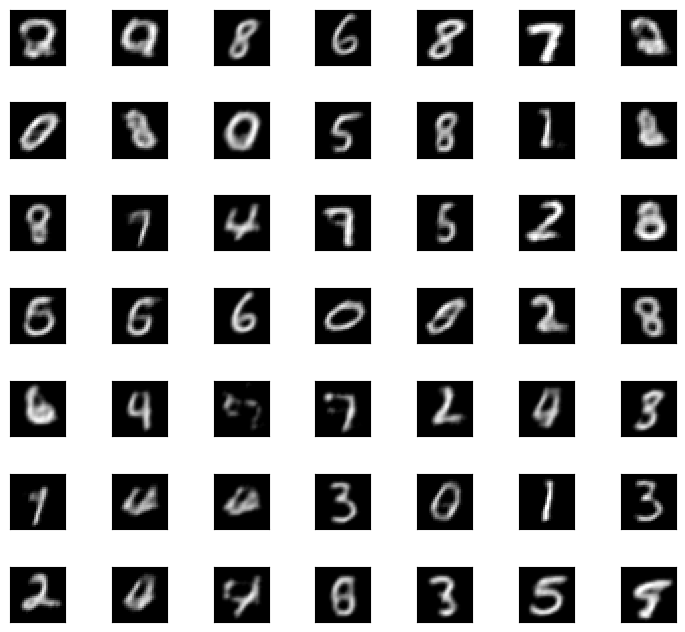

In [20]:
network.eval()
with torch.no_grad():
  sample=torch.randn((49, 5))
  generated=decoder(sample.to(device)).to('cpu')

fig = plt.figure()
length=49
begin=0
network.eval()
plt.figure(figsize=(7, 7))
for i in range(length):

  data = generated[i].movedim(0, 2)

  print(data.shape)
  plt.subplot(7,7,i+1)
  plt.tight_layout()
  plt.imshow(data, cmap='gray', vmin=0, vmax=1)
  plt.xticks([])
  plt.yticks([])

